# SCOTUS Predictions

This notebook will use data from the Supreme Court Database (found [here](http://supremecourtdatabase.org/about.php)), pared down to include data from only our current supreme court justices (including the late Ruth Bader Ginsburg, in her honor), and not including the newest Associate Justice Amy Coney Barrett, considering there is not yet any data on her votes included in the data base.

The main model will be used to determine how each justice's vote might lean (conservative or liberal, codes for these meanings based on different issues can be found [here](http://supremecourtdatabase.org/documentation.php?var=decisionDirection)), given certain issues, issue areas, the term, the leaning of the entire court on the issue, whether or not there is a possible declaration of Unconstitutionality, and the legal provisions considered in the case. 

The second 'just for fun' model, takes data about certain cases and will predict how the late Ruth Bader Ginsburg would have voted in the case. I call it WWRBGD, short for "What Would Ruth Bader Ginsburg Do?"

## Notebook Preparation and Data Exploration

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
from pprint import pprint
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

sns.set_style('dark')
sns.set(font_scale=1)

In [ ]:
from google.colab import files

In [ ]:
original_df = pd.read_csv('https://raw.githubusercontent.com/meeshmg/DataSets/main/scotus_final.csv')
original_df.head()

caseId     docketId  ... firstAgreement secondAgreement
0  2018-001  2018-001-01  ...            NaN             NaN
1  2018-002  2018-002-01  ...            NaN             NaN
2  2018-003  2018-003-01  ...            NaN             NaN
3  2018-004  2018-004-01  ...            NaN             NaN
4  2018-005  2018-005-01  ...            NaN             NaN

[5 rows x 61 columns]

There are many columns in this data set, many of which are quite irrelevant. 

THINGS TO KEEP:

- Term
- Issue
- Issue Area
- Justice Name
- Legal Provisions Considered by the Court
- Declaration of Unconstitutionality
- Decision Direction
- Direction of Individual Justices's Votes (TARGET)

In [ ]:
# Save all justices names to a list
justice_names = original_df['justiceName'].value_counts().index.tolist()
keep_list = ['term','issue','issueArea','decisionDirection','lawType','declarationUncon','justiceName','direction']

In [ ]:
df = original_df[keep_list]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14366 entries, 0 to 14365
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   term               14366 non-null  int64  
 1   issue              14329 non-null  float64
 2   issueArea          14329 non-null  float64
 3   decisionDirection  14329 non-null  float64
 4   lawType            13738 non-null  float64
 5   declarationUncon   14365 non-null  float64
 6   justiceName        14366 non-null  object 
 7   direction          13728 non-null  float64
dtypes: float64(6), int64(1), object(1)
memory usage: 898.0+ KB


###Label Encoding Variables From Codes to Words for Easier Interpretation

BEFORE One Hot Encoding all these catergorical variables into dummy variables, I will first label encode all the records (that are in numbers) to strings based on the data documentation, for easier interpretation later. 

The only feature I will not label encode to its string values is 'Issues', as there are too many to do efficiently.

Issues codes can be found [here](http://supremecourtdatabase.org/documentation.php?var=issue)

In [ ]:
# Label Encoding for Issue Area

issueAreas = ['Criminal Procedure','Civil Rights','First Amendment','Due Process','Privacy','Attorneys','Unions','Economic Activity','Judicial Power','Federalism','Interstate Relations','Federal Taxation','Miscellaneous','Private Action']

for i in range(len(issueAreas)):
  df.loc[df['issueArea'] == i+1,'issueArea'] = issueAreas[i]

# Label encoding for Decision Direction
df.loc[df.decisionDirection == 1.0,'decisionDirection'] = 'conservative'
df.loc[df.decisionDirection == 2.0,'decisionDirection'] = 'liberal'

# Label encoding for the Law considered in the decision
lawTypes = ['Constitution',
'Constitutional Amendment',
'Federal Statute',
'Court Rules',
'Other',
'Infrequently litigated statutes',
'State or local law or regulation',
'No Legal Provision']

df.loc[df['lawType'] == 1.0,'lawType'] = lawTypes[0]
df.loc[df['lawType'] == 2.0,'lawType'] = lawTypes[1]
df.loc[df['lawType'] == 3.0,'lawType'] = lawTypes[2]
df.loc[df['lawType'] == 4.0,'lawType'] = lawTypes[3]
df.loc[df['lawType'] == 5.0,'lawType'] = lawTypes[4]
df.loc[df['lawType'] == 6.0,'lawType'] = lawTypes[5]
df.loc[df['lawType'] == 8.0,'lawType'] = lawTypes[6]
df.loc[df['lawType'] == 9.0,'lawType'] = lawTypes[7]

declaresUncon = ['no decl of Uncon','congress act Uncon','state/terr law/reg/prov Uncon','muni/local ord Uncon']
# Label encoding for whether there was a declaration of Unconstitutionality
for i in range(len(declaresUncon)):
  df.loc[df['declarationUncon'] == i+1,'declarationUncon'] = declaresUncon[i]

# Label encoding the target variable, the judge's direction of decision
df.loc[df.direction == 1.0,'direction'] = 'conservative'
df.loc[df.direction == 2.0,'direction'] = 'liberal'

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

Codebook for what 'Conservative' and 'Liberal' mean in context of certain issue areas can be found [here](http://supremecourtdatabase.org/documentation.php?var=decisionDirection)

### Cleaning and Exploration

#### Missing Values & Outliers

There are missing values in the columns that we kept in the DataFrame, however there really are no outliers. With the exception of "term" potentially, all the inputs will be categorical dummy variables. While term potentially has the option to be continuous as the years range from 1991 to 2020, the difference in scaling might mess up the model and create some inconsistencies, and there are few enough term years that they will likely be  converted into dummy variables as well. 

In [ ]:
print('Percent Null:')
print('-'*40)
null_percentages = df.isnull().sum() *100 / df.isnull().count()
for i in range(len(df.columns)):
  if null_percentages[i] > 0:
    print('{}: {}'.format(null_percentages.index[i],null_percentages[i]))

Percent Null:
----------------------------------------
issue: 0.2575525546429069
issueArea: 0.2575525546429069
decisionDirection: 0.2575525546429069
lawType: 4.371432549074203
declarationUncon: 0.006960879855213699
direction: 4.44104134762634


It is interesting to find the Liberal Scores of each judge. 

In [ ]:
# This is an interesting aspect, to figure out what percentage of the time these justices vote a certain way. 
all_liberal_scores = []
for name in justice_names:
  cons_lean = df.loc[df['justiceName'] == name,'direction'].loc[df.direction == 'conservative'].count()
  lib_lean = df.loc[df['justiceName'] == name,'direction'].loc[df.direction == 'liberal'].count()
  if cons_lean > lib_lean:
    print('{} is conservative {:.2f} % of the time'.format(name,((cons_lean*100)/(cons_lean+lib_lean))))
  else:
    print('{} is liberal {:.2f} % of the time'.format(name,((lib_lean*100)/(cons_lean+lib_lean))))
  overall_lib_score = lib_lean*100 / (cons_lean + lib_lean)
  all_liberal_scores.append(overall_lib_score)


CThomas is conservative 69.30 % of the time
RBGinsburg is liberal 62.30 % of the time
SGBreyer is liberal 58.91 % of the time
JGRoberts is conservative 58.04 % of the time
SAAlito is conservative 65.30 % of the time
SSotomayor is liberal 64.10 % of the time
EKagan is liberal 61.53 % of the time
NMGorsuch is conservative 61.94 % of the time
BMKavanaugh is conservative 58.74 % of the time


In [ ]:
all_liberal_scores= [30.703959773727217,
 62.3007623007623,
 58.90561880279104,
 41.961067051189616,
 34.70456245325355,
 64.0973630831643,
 61.52927120669056,
 38.05668016194332,
 41.25874125874126]

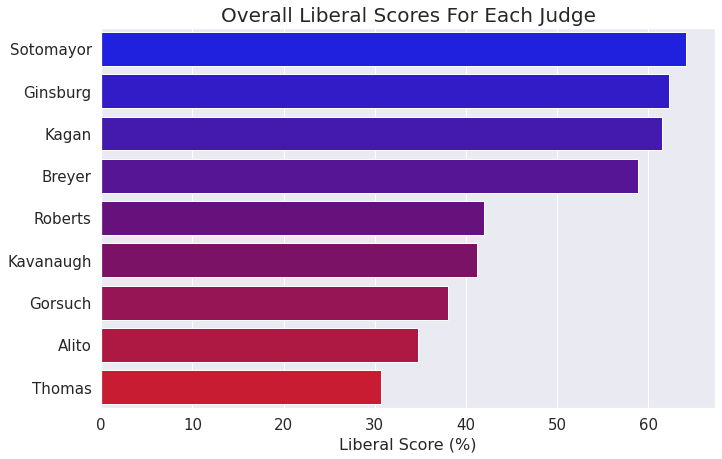

In [ ]:
overall_lib_score_df = pd.DataFrame({'Justice Name':justice_names,'Liberal Score':all_liberal_scores})
overall_lib_score_df = overall_lib_score_df.sort_values(by='Liberal Score',ascending=False)
lib_scores = plt.figure(figsize=(11,7))
sns.barplot(x=overall_lib_score_df['Liberal Score'],y=overall_lib_score_df['Justice Name'],palette= sns.color_palette('blend:blue,red',10))
plt.title('Overall Liberal Scores For Each Judge',fontsize=20)
plt.xlabel('Liberal Score (%)',fontsize=16)
plt.ylabel(None)
plt.yticks(np.arange(len(justice_names)),['Sotomayor','Ginsburg','Kagan','Breyer','Roberts','Kavanaugh','Gorsuch','Alito','Thomas'])
plt.tick_params(labelsize=15)

plt.show()

In [ ]:
lib_scores.savefig('libscores.png')
files.download('libscores.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Even though I know which way each justice tends to lean in terms of voting conserative or liberal, I choose to drop all null values, considering I want the prediction to be based very purely on the judges' purest decisions rather than any kind of trend. When I drop all null values, I still have plenty of data.

In [ ]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13175 entries, 4 to 14365
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   term               13175 non-null  int64  
 1   issue              13175 non-null  float64
 2   issueArea          13175 non-null  object 
 3   decisionDirection  13175 non-null  object 
 4   lawType            13175 non-null  object 
 5   declarationUncon   13175 non-null  object 
 6   justiceName        13175 non-null  object 
 7   direction          13175 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 926.4+ KB


#### Exploration & Visualization

While there are no continuous variables with which we can explore a boxplot or examine normality of, there is still some intersting information to visualize from the data. 

##### Liberal Scores of Justices by Issue Area

We will exampine the overall liberal scores of every justice based on each issue.

In [ ]:
issueAreas2 = []
justice_names2 = []
issue_lib_scores = []
for i in range(len(issueAreas)):
  for j in range(len(justice_names)):
    if len(df.loc[df['issueArea'] == issueAreas[i],['issueArea','direction','justiceName']].loc[df['justiceName'] == justice_names[j],['direction']].loc[df['direction'] == 'liberal'].value_counts()) > 0:
      lib_count = df.loc[df['issueArea'] == issueAreas[i],['issueArea','direction','justiceName']].loc[df['justiceName'] == justice_names[j],['direction']].loc[df['direction'] == 'liberal'].value_counts()[0]
    else:
      lib_count = 0
    if len(df.loc[df['issueArea'] == issueAreas[i],['issueArea','direction','justiceName']].loc[df['justiceName'] == justice_names[j],['direction']].loc[df['direction'] == 'conservative'].value_counts()) > 0:
      cons_count = df.loc[df['issueArea'] == issueAreas[i],['issueArea','direction','justiceName']].loc[df['justiceName'] == justice_names[j],['direction']].loc[df['direction'] == 'conservative'].value_counts()[0]
    else:
      cons_count = 0
    if cons_count + lib_count != 0:
      lib_score = lib_count *100 / (cons_count+lib_count)
    else:
      lib_score = None
    issueAreas2.append(issueAreas[i])
    justice_names2.append(justice_names[j])
    issue_lib_scores.append(lib_score)  
            
lib_lean_df = pd.DataFrame({'issueArea':issueAreas2,'justiceName':justice_names2,'lib_score':issue_lib_scores})
lib_lean_df = lib_lean_df.sort_values(by=['issueArea','lib_score'])
lib_lean_df.dropna(inplace=True)
lib_score_pivot = pd.pivot_table(lib_lean_df, index=['issueArea'],columns=['justiceName'],values=['lib_score'],aggfunc=np.mean)
lib_score_pivot                                                                                                                                                                         

lib_score              ...                      
justiceName          BMKavanaugh     CThomas  ...   SGBreyer SSotomayor
issueArea                                     ...                      
Attorneys              50.000000   45.945946  ...  66.666667  72.222222
Civil Rights           34.615385   21.675774  ...  67.025862  71.895425
Criminal Procedure     37.500000   22.962963  ...  54.966887  65.714286
Due Process            25.000000   25.742574  ...  72.222222  80.645161
Economic Activity      46.153846   42.708333  ...  51.464435  53.023256
Federal Taxation      100.000000   53.333333  ...  78.260870  90.000000
Federalism             46.153846   38.317757  ...  71.111111  66.071429
First Amendment        45.454545   30.681818  ...  64.556962  68.493151
Interstate Relations         NaN  100.000000  ...   0.000000        NaN
Judicial Power         35.714286   35.309278  ...  48.071217  60.162602
Miscellaneous         100.000000   80.000000  ...  40.000000  60.000000
Privacy                 0.000000   22.222222  ...  50.000000  50.000000
Private Action        100.000000    0.000000  ...  50.000000  50.000000
Unions                  0.000000   25.423729  ...  78.181818  77.777778

[14 rows x 9 columns]

A NaN indicates that this justice has not voted on an issue of this Issue Area.

We can visualize the liberal scores per issue for each justice.

In [ ]:
justice_names_sorted = justice_names.copy()
justice_names_sorted.sort()

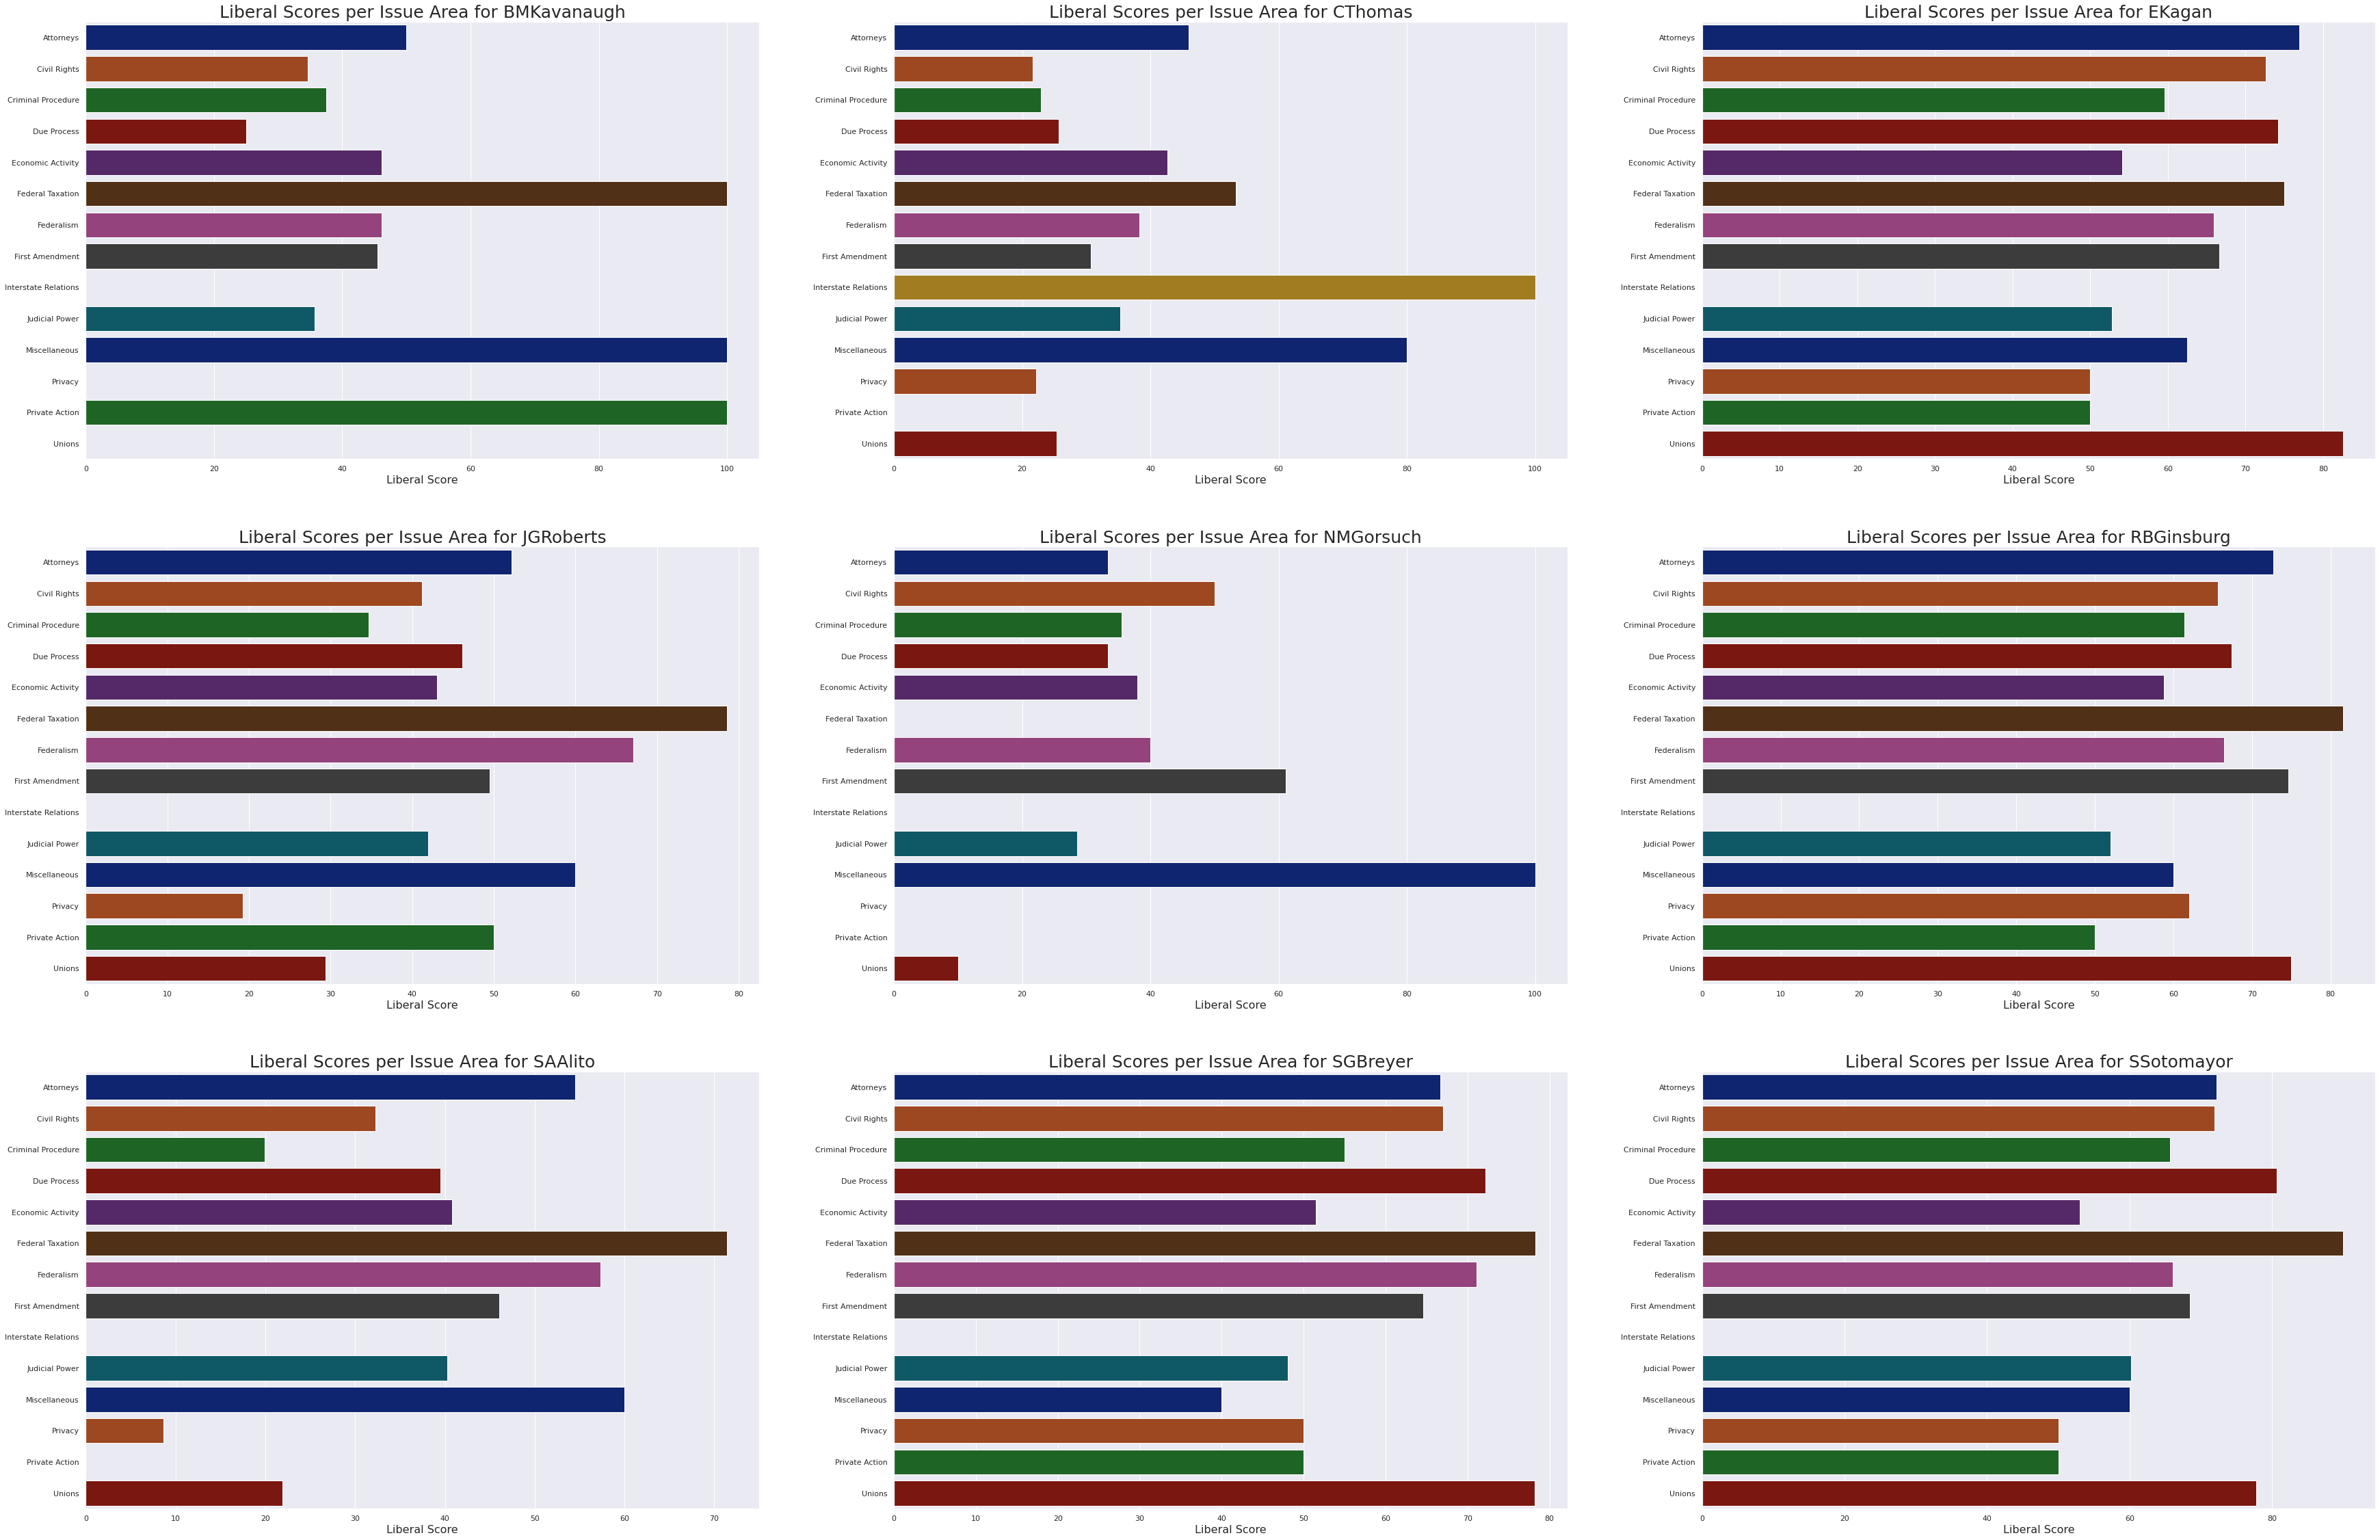

In [ ]:
plt.figure(figsize = (60,40))
for i in range(len(justice_names_sorted)):
  plt.subplot(3,3,i+1)
  sns.barplot(x=lib_score_pivot.iloc[:,i].values,y=lib_score_pivot.iloc[:,i].index,palette= sns.color_palette('dark'))
  plt.xlabel('Liberal Score',fontdict={'fontsize':16})
  plt.ylabel(None)
  plt.title('Liberal Scores per Issue Area for {}'.format(justice_names_sorted[i]),fontdict={'fontsize':25})
plt.show()

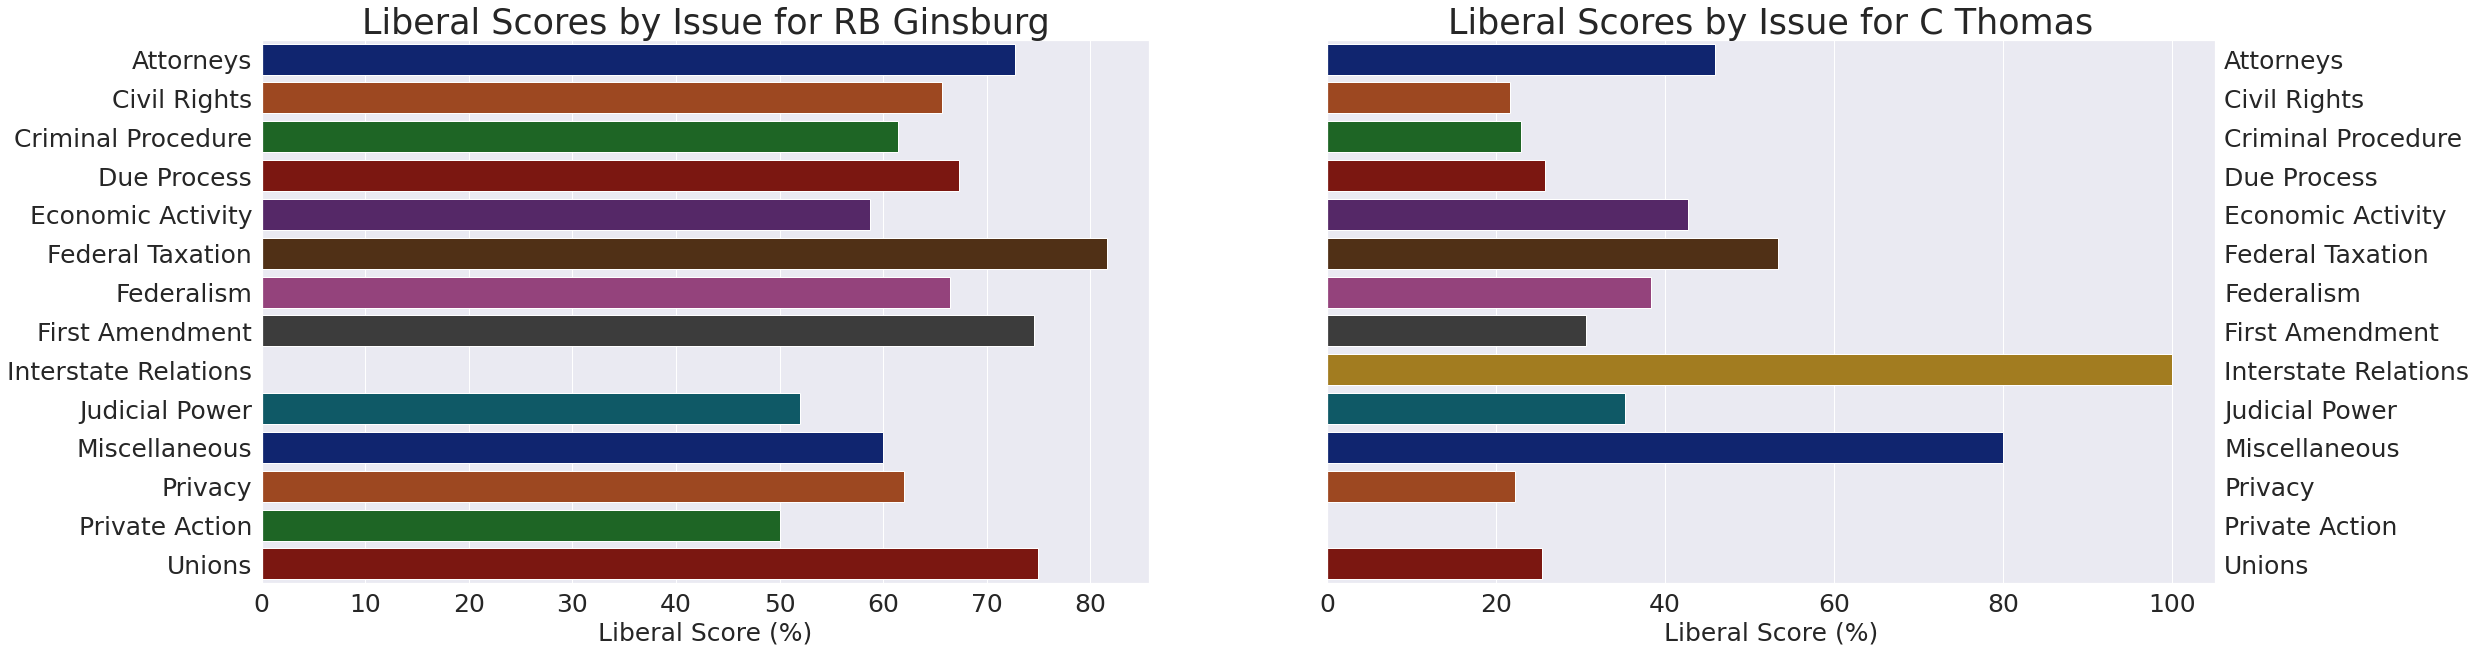

In [ ]:
rbg_v_ct = plt.figure(figsize = (35,10))
plt.subplot(1,2,1)
sns.barplot(x=lib_score_pivot.iloc[:,5].values,y=lib_score_pivot.iloc[:,5].index,palette= sns.color_palette('dark'))
plt.title('Liberal Scores by Issue for RB Ginsburg',fontsize=35)
plt.xlabel('Liberal Score (%)',fontsize=25)
plt.ylabel(None)
plt.tick_params(labelsize=25)
plt.subplot(1,2,2)
sns.barplot(x=lib_score_pivot.iloc[:,1].values,y=lib_score_pivot.iloc[:,1].index,palette= sns.color_palette('dark'))
plt.title('Liberal Scores by Issue for C Thomas',fontsize=35)
plt.xlabel('Liberal Score (%)',fontsize=25)
plt.ylabel(None)
plt.tick_params(labelsize=25,labelright=True,labelleft=False)
plt.show()

In [ ]:
rbg_v_ct.savefig('rbg_v_cthomas.png')
files.download('rbg_v_cthomas.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##### Judge's Voting over time

We included 'term' as a possible factor for predicting how the judges will vote. We'll examine each judge's liberal score over the entirety of their term. 

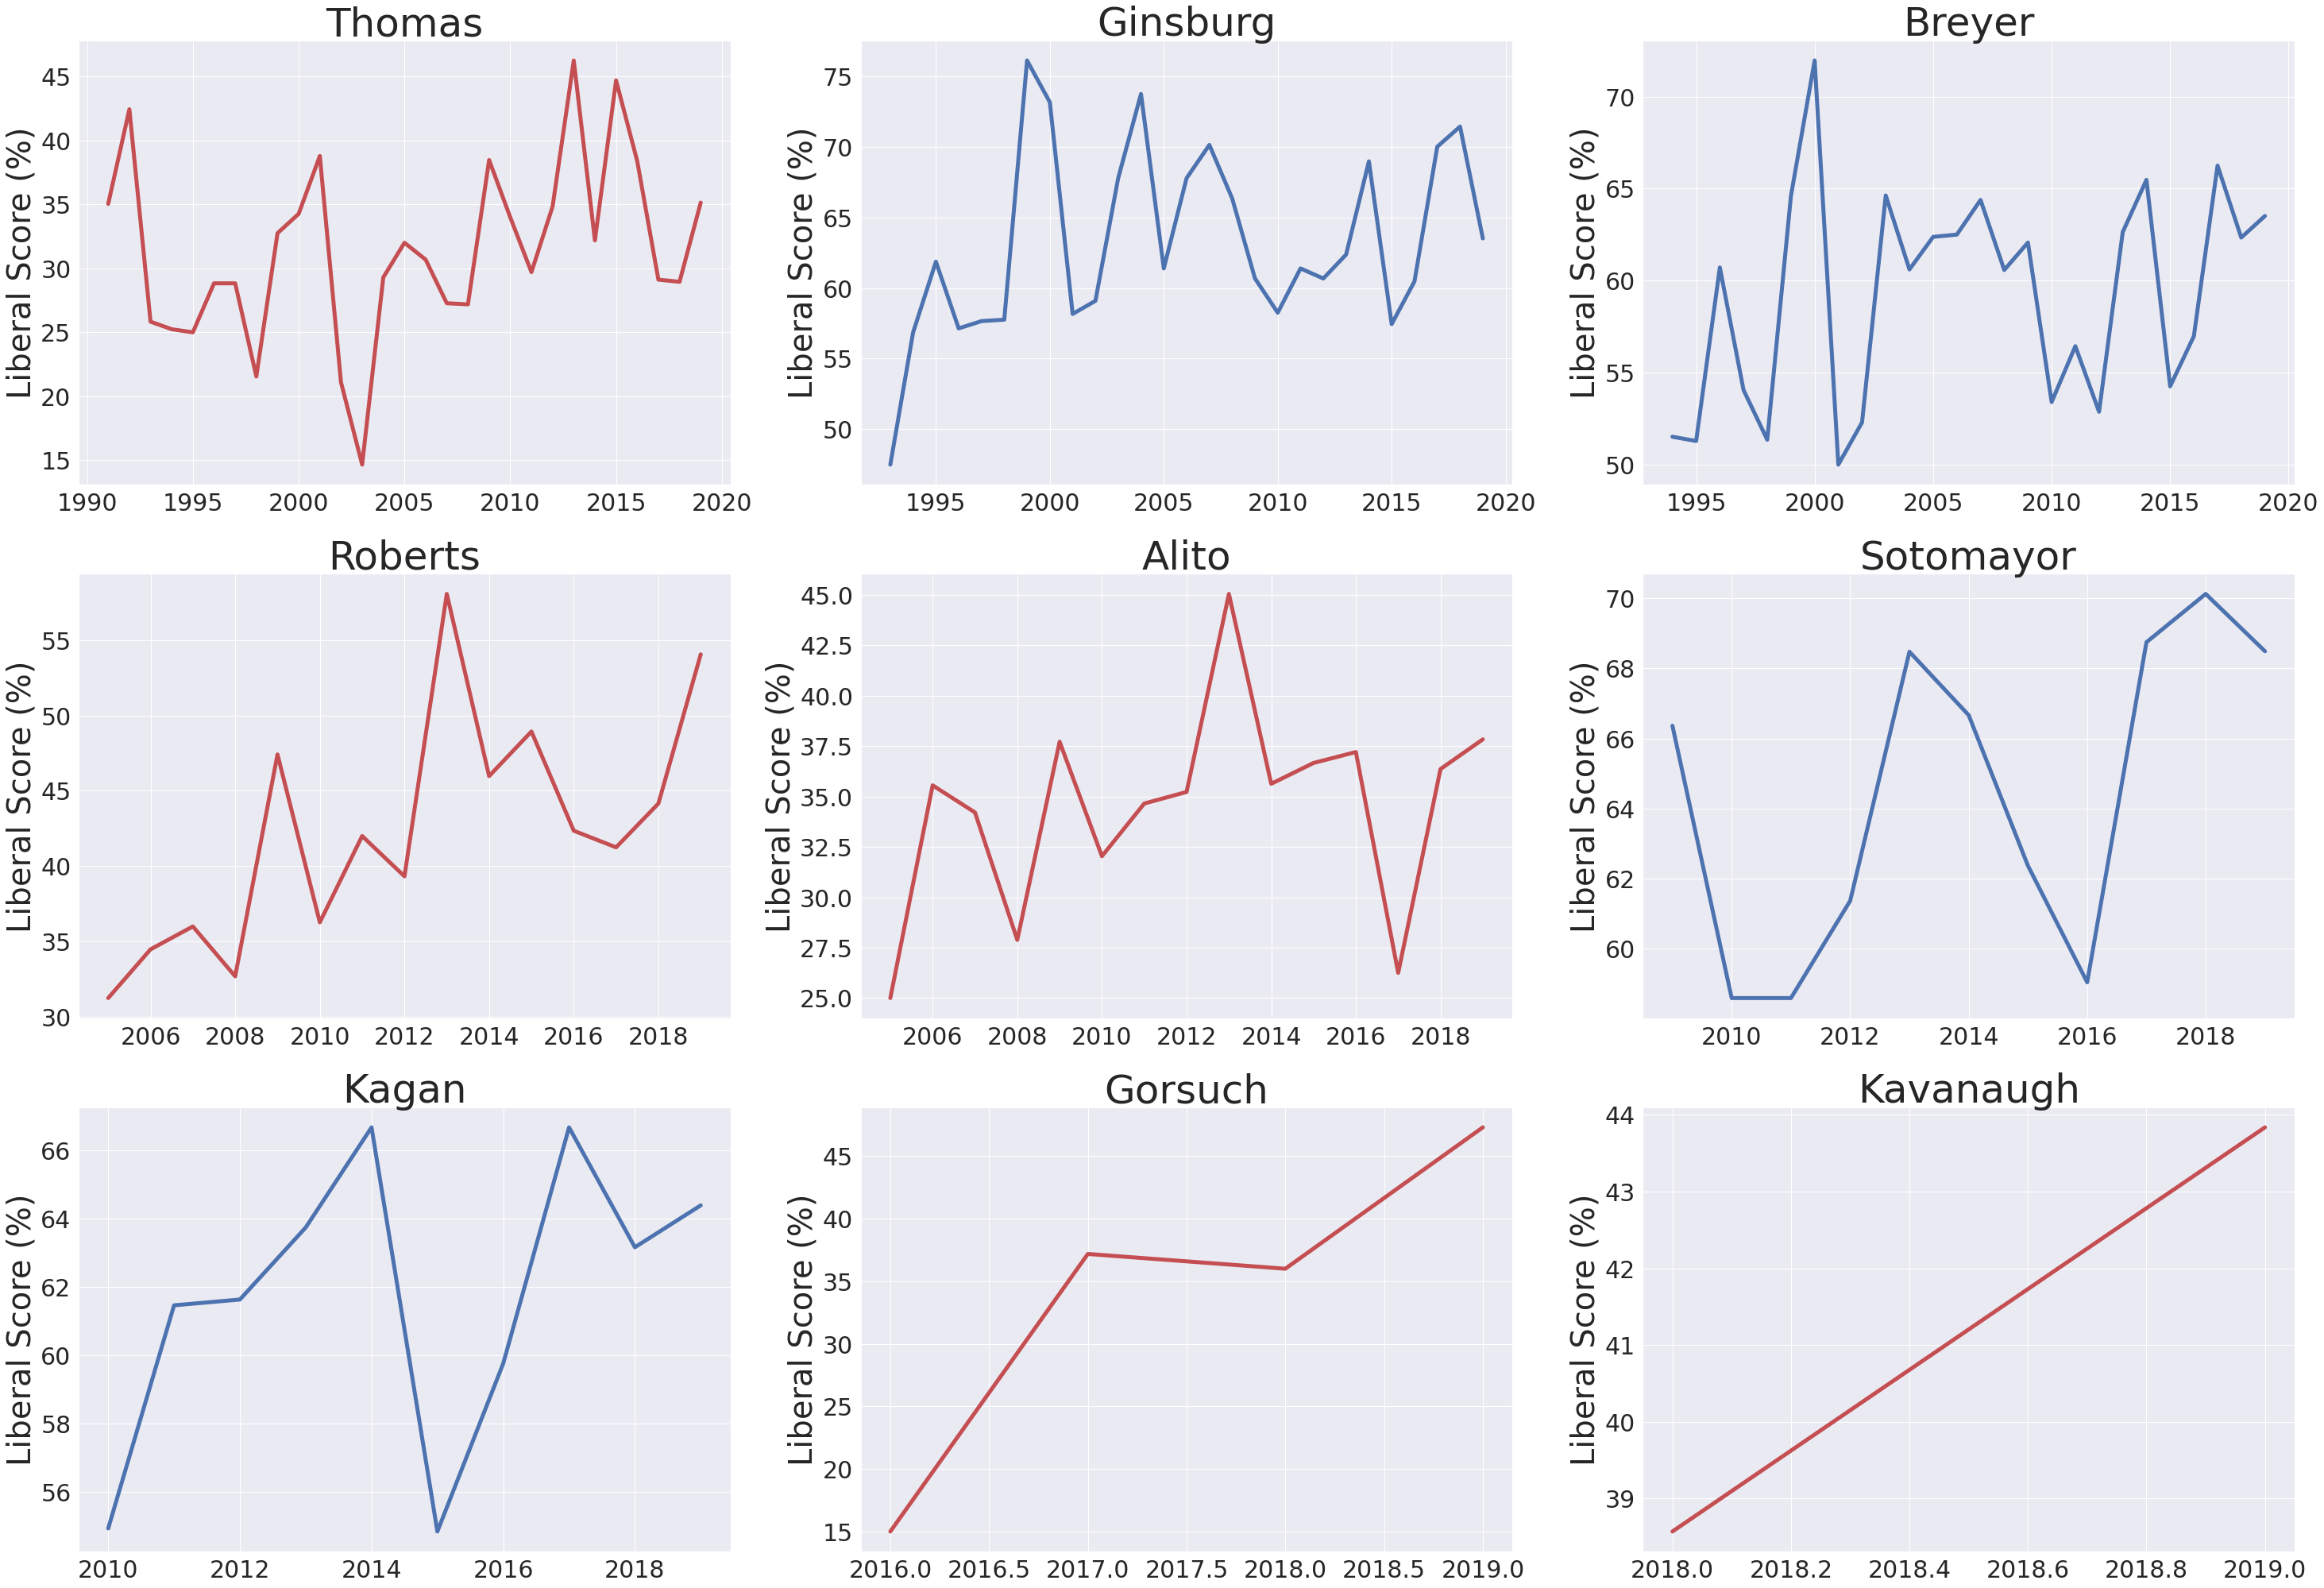

In [ ]:
name_list = []
year_list = []
lib_score_by_year_list = []
for name in justice_names:
  for year in df.loc[df.justiceName == name,'term'].unique().tolist():
    cons_lean = df.loc[df.term == year].loc[df.justiceName == name,'direction'].loc[df.direction == 'conservative'].count()
    lib_lean = df.loc[df.term == year].loc[df.justiceName == name,'direction'].loc[df.direction == 'liberal'].count()
    lib_score_by_year = lib_lean *100 / (cons_lean+lib_lean)
    name_list.append(name)
    year_list.append(year)
    lib_score_by_year_list.append(lib_score_by_year)

by_year_df = pd.DataFrame({'justiceName':name_list,'term':year_list,'lib_score':lib_score_by_year_list})
last_names = ['Thomas','Ginsburg','Breyer','Roberts','Alito','Sotomayor','Kagan','Gorsuch','Kavanaugh']
color_list = ['-r','-b','-b','-r','-r','-b','-b','-r','-r']

lib_time = plt.figure(figsize = (50,35))
plt.title('Liberal Scores Over Time',fontsize=50)
for i in range(len(justice_names)):
  plt.subplot(3,3,i+1)
  plt.plot(by_year_df.loc[by_year_df.justiceName == justice_names[i],'term'],by_year_df.loc[by_year_df.justiceName == justice_names[i],'lib_score'],color_list[i],linewidth=5.0)
  plt.ylabel('Liberal Score (%)',fontdict={'fontsize':40})
  plt.title('{}'.format(last_names[i]),fontdict={'fontsize':50})
  plt.tick_params(labelsize=30)
plt.show()

In [ ]:
lib_time.savefig('libtime.png')
files.download('libtime.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

While in general most of the judges are more liberal some years and much more conservative others, it does seem to be the case that most judge's trend is voting more liberal over time. In the few years that Justice Gorsuch has been in office, his liberal score has steadily increased. We see a similar trend with Justice Kavanaugh. We can't jump to conclusions however, as other justice's trend lines over time, such as Justice Kagain's, show a steady increase for many years followed by a deep plunge in 2015.

Overall, I expect term to be an interesting and somewhat predictive factor for how a justice will vote. 

#### Balance of Target Variable Classes

We want the target variable classes to be balanced. The target variable here is direction, whether a Supreme Court Justice will vote 'conservative' or 'liberal' given certain issues. 

In [ ]:
df.direction.value_counts()

conservative    6675
liberal         6500
Name: direction, dtype: int64

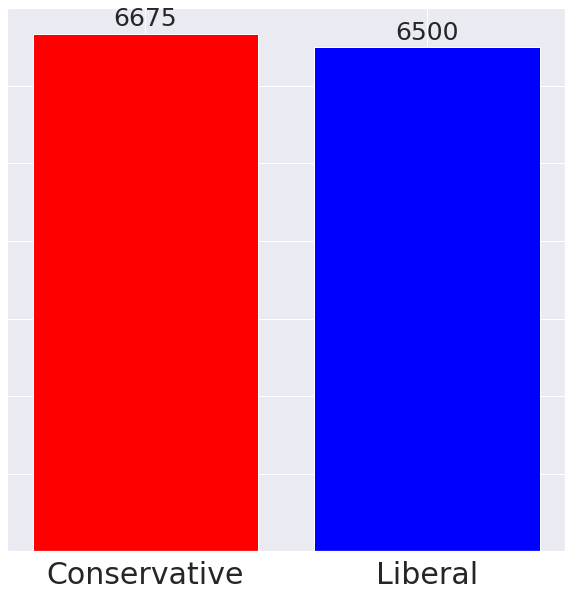

In [ ]:
height = [6675,6500]
bars = ('Conservative','Liberal')
y_pos = np.arange(len(bars))

target_bal = plt.figure(figsize=(10,10))

plt.bar(y_pos,height,color=['red','blue'])
plt.xticks(y_pos, bars)
plt.annotate('{}'.format(height[0]),xy = (y_pos[0],height[0]),xytext=(0,3),fontsize=25,textcoords='offset points',ha='center',va='bottom')
plt.annotate('{}'.format(height[1]),xy = (y_pos[1],height[1]),xytext=(0,3),fontsize=25,textcoords='offset points',ha='center',va='bottom')
plt.tick_params(labelsize=30)
plt.tick_params(axis='y',labelleft=False)
plt.show()

In [ ]:
target_bal.savefig('targetbal.png')
files.download('targetbal.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The classe are reasonably balanced and a case of bias towards a majority class is not likely. 

##### Potential Imbalance Between Judge's Case Numbers

Certain judges, such as Clarence Thomas and Stephen Breyer have been on the court for much longer, so naturally they will have more records about how they voted than other judges. This may not cause too much of an issue, but as a natural consequence of this, it is likely that predictions of how Clarence Thomas will vote will tend to be more accurate than others, and the Clarence Thomas dummy variable will likely be more important than the rest, once we can investigate feature importance.

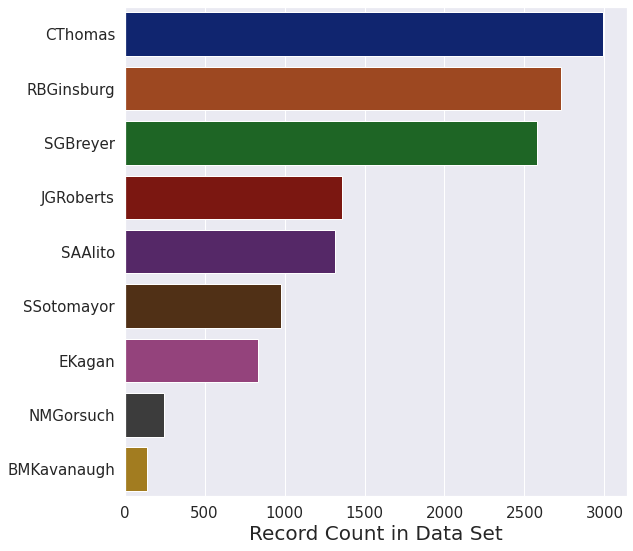

In [ ]:
record_percs = []
for name in justice_names:
  record_perc = len(df.loc[df.justiceName== name])
  record_percs.append(record_perc)
rec_counts = plt.figure(figsize=(9,9))
sns.barplot(x=record_percs,y=justice_names,palette= sns.color_palette('dark'))
plt.xlabel('Record Count in Data Set',fontsize=20)
plt.tick_params(labelsize=15)
plt.show()

In [ ]:
rec_counts.savefig('rec_counts.png')
files.download('rec_counts.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### One Hot Encoding all Categorical Variables to Dummy Variables

In [ ]:
df = pd.concat([df,pd.get_dummies(df['issue'],prefix='issue',drop_first=True)],axis=1)
issue_dummy_names = pd.get_dummies(df['issue'],prefix='issue',drop_first=True).columns.tolist()

df = pd.concat([df,pd.get_dummies(df['issueArea'],prefix='issueArea',drop_first=True)],axis=1)
issueArea_dummy_names = pd.get_dummies(df['issueArea'],prefix='issueArea',drop_first=True).columns.tolist()

dummy_variable_names = []
df = pd.concat([df,pd.get_dummies(df['lawType'],prefix='lawType',drop_first=True)],axis=1)
dummy_variable_names = dummy_variable_names + pd.get_dummies(df['lawType'],prefix='lawType',drop_first=True).columns.tolist()

df = pd.concat([df,pd.get_dummies(df['declarationUncon'],prefix='declarationUncon',drop_first=True)],axis=1)
dummy_variable_names = dummy_variable_names + pd.get_dummies(df['declarationUncon'],prefix='declarationUncon',drop_first=True).columns.tolist()

df = pd.concat([df,pd.get_dummies(df['justiceName'],prefix='justiceName',drop_first=True)],axis=1)
dummy_variable_names = dummy_variable_names + pd.get_dummies(df['justiceName'],prefix='justiceName',drop_first=True).columns.tolist()

df = pd.concat([df,pd.get_dummies(df['term'],prefix='term',drop_first=True)],axis=1)
dummy_term_years = pd.get_dummies(df['term'],prefix='term',drop_first=True).columns.tolist()

In [ ]:
df.shape

(13175, 274)

In [ ]:
13175 / 274

48.083941605839414

## Feature Engineering

### Feature Ranking with SelectKBest

There are 276 features when all categorical variables are encoded to dummies.

Acceptable feature to observation ratio is 1:15, and our ratio of features to observations is ~ 1:47. So, this is still a perfectly acceptable number of features, but I still want to give myself the option of narrowing down the featuers by using the chi-squared test to determine the features which are the most related to the target variable. 

We will do that here in this section, and find the top 25, 50, 100, and 200 features among this feature set.

In [ ]:
X = df[dummy_term_years + dummy_variable_names + issueArea_dummy_names + issue_dummy_names]
Y = df['direction']
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.3,random_state=42)

fs = SelectKBest(score_func=chi2,k='all')
fs.fit(X_train,y_train)
X_train_fs = fs.transform(X_train)
X_test_fs = fs.transform(X_test)

feature_list = X.columns.tolist()

score_df = pd.DataFrame({'feature': feature_list,'fs_score':fs.scores_})

top_200_features = score_df.sort_values(by='fs_score',ascending=False).head(200)['feature'].values.tolist()
top_100_features = score_df.sort_values(by='fs_score',ascending=False).head(100)['feature'].values.tolist()
top_75_features = score_df.sort_values(by='fs_score',ascending=False).head(75)['feature'].values.tolist()
top_50_features = score_df.sort_values(by='fs_score',ascending=False).head(50)['feature'].values.tolist()
top_25_features = score_df.sort_values(by='fs_score',ascending=False).head(25)['feature'].values.tolist()

# Just make sure the justices themselves are in every feature set 
top_25_features = top_25_features + ['justiceName_NMGorsuch']

top_features = [top_25_features,top_50_features,top_75_features,top_100_features,top_200_features,feature_list]

### Determining which feature set is better.

Does the model perform better with minimal features or many?

In [ ]:
iter = 1 
print('Solver: saga with l1 regularization')
for features in top_features:
  X = df[features]
  Y = df['direction']
  X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=.3,random_state=42)
  lr = LogisticRegression(solver='saga',C=10.0,penalty='l1',max_iter=1000,random_state=42)
  lr.fit(X_train,y_train)
  train_score = lr.score(X_train,y_train)
  test_score = lr.score(X_test,y_test)
  print('-'*40)
  print(f'Scores for Iteration {iter}:\nTrain Accuracy: {train_score}\nTest Accuracy: {test_score}')
  iter = iter + 1 

Solver: saga with l1 regularization
----------------------------------------
Scores for Iteration 1:
Train Accuracy: 0.6557145955324225
Test Accuracy: 0.6508980521123198
----------------------------------------
Scores for Iteration 2:
Train Accuracy: 0.670353502494036
Test Accuracy: 0.6569693903364533
----------------------------------------
Scores for Iteration 3:
Train Accuracy: 0.6745825200607244
Test Accuracy: 0.6574753351884645
----------------------------------------
Scores for Iteration 4:
Train Accuracy: 0.6761006289308176
Test Accuracy: 0.6627877561345813
----------------------------------------
Scores for Iteration 5:
Train Accuracy: 0.6873780091086532
Test Accuracy: 0.6729066531748039
----------------------------------------
Scores for Iteration 6:
Train Accuracy: 0.6873780091086532
Test Accuracy: 0.6718947634707817


In [ ]:
iter = 1 
print('Solver: lbfgs with l2 regularization')
for features in top_features:
  X = df[features]
  Y = df['direction']
  X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=.3,random_state=42)
  lr = LogisticRegression(solver='lbfgs',C=10.0,penalty='l2',max_iter=1000,random_state=42)
  lr.fit(X_train,y_train)
  train_score = lr.score(X_train,y_train)
  test_score = lr.score(X_test,y_test)
  print('-'*40)
  print(f'Scores for Iteration {iter}:\nTrain Accuracy: {train_score}\nTest Accuracy: {test_score}')
  iter = iter + 1 

Solver: lbfgs with l2 regularization
----------------------------------------
Scores for Iteration 1:
Train Accuracy: 0.6557145955324225
Test Accuracy: 0.6508980521123198
----------------------------------------
Scores for Iteration 2:
Train Accuracy: 0.670353502494036
Test Accuracy: 0.6569693903364533
----------------------------------------
Scores for Iteration 3:
Train Accuracy: 0.6746909564085881
Test Accuracy: 0.6574753351884645
----------------------------------------
Scores for Iteration 4:
Train Accuracy: 0.6763175016265452
Test Accuracy: 0.6625347837085758
----------------------------------------
Scores for Iteration 5:
Train Accuracy: 0.6877033181522446
Test Accuracy: 0.6729066531748039
----------------------------------------
Scores for Iteration 6:
Train Accuracy: 0.6870527000650618
Test Accuracy: 0.6724007083227929


Two things are clear here: first of all using the 'lbfgs' solver results in similar accuracy as the 'saga' solver, and is much quicker.

Additionally, the accuracy, at least using Logistic Regression, is slightly better using only the top 200 features, but negligibly so. I will use the entire feature set for now.

### Using the 'Issue' vs. 'Issue Area'

In [ ]:
# X1 uses only the Issue Dummy Names
X1 = df[dummy_term_years + issue_dummy_names + dummy_variable_names]
# X2 uses only the issue Area Dummy Names
X2 = df[dummy_term_years + issueArea_dummy_names + dummy_variable_names]
# X3 uses them both
X3 = df[dummy_term_years + issue_dummy_names + issueArea_dummy_names + dummy_variable_names]
Y = df['direction']

X1_train, X1_test, y_train, y_test = train_test_split(X1,Y,test_size= 0.2,random_state = 42)
X2_train, X2_test, y_train, y_test = train_test_split(X2,Y,test_size= 0.2,random_state = 42)
X3_train,X3_test,y_train,y_test = train_test_split(X3,Y,test_size=.2,random_state=42)

In [ ]:
lr = LogisticRegression(C=1,solver='saga',random_state=42)
cv_scores_x1 = cross_val_score(lr,X1_train,y_train,cv=5)
print('Accuracy Scores for Feature Set X1: {}\nMean Accuracy Score for Featuer Set X1 = {}'.format(cv_scores_x1,cv_scores_x1.mean()))
print('-' * 40)
cv_scores_x2 = cross_val_score(lr,X2_train,y_train,cv=5)
print('Accuracy Scores for Feature Set X2: {}\nMean Accuracy Score for Featuer Set X2 = {}'.format(cv_scores_x2,cv_scores_x2.mean()))
print('-' * 40)
cv_scores_x3 = cross_val_score(lr,X3_train,y_train,cv=5)
print('Accuracy Scores for Feature Set X3: {}\nMean Accuracy Score for Featuer Set X3 = {}'.format(cv_scores_x3,cv_scores_x3.mean()))

Accuracy Scores for Feature Set X1: [0.66034156 0.67694497 0.68121442 0.65559772 0.67362429]
Mean Accuracy Score for Featuer Set X1 = 0.6695445920303605
----------------------------------------
Accuracy Scores for Feature Set X2: [0.62381404 0.64848197 0.62808349 0.63757116 0.64611006]
Mean Accuracy Score for Featuer Set X2 = 0.6368121442125237
----------------------------------------
Accuracy Scores for Feature Set X3: [0.66223909 0.67267552 0.68121442 0.65607211 0.67457306]
Mean Accuracy Score for Featuer Set X3 = 0.6693548387096774


The highest average accuracy score is for the feature set that only includes the issues as opposed to the issue areas, but neglibibly. Because the issue areas are often easier to understand than the issues, I will include both. 

## Models

In [ ]:
X = df[feature_list]
Y = df['direction']
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.3,random_state=42)

In [ ]:
# Write a function for the confusion matrix
def plot_confusion_matrix(cm,classes,normalize,title='Confusion Matrix', cmap=plt.cm.Blues):
  """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
    print('Normalized Confusion Matrix')
  else:
    print('Confusion Matrix, without Normalization')
  plt.grid(False)
  plt.imshow(cm,interpolation='nearest',cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks,classes)
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2
  
  for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j,i, format(cm[i,j], fmt),
             horizontalalignment = 'center', verticalalignment = 'center',
             color='white' if cm[i,j] > thresh else 'black')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

In [ ]:
# Write a function to evaluate the model after we run it and output the confusion matrices for plotting
def run_evaluate_model(model,X,Y):
  # split x and y
  X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.3,random_state=42)

  # fit the model
  model.fit(X_train,y_train)
  
  # Predict outcomes for X_train and y_train
  # Save outcomes to variables
  predict_train = model.predict(X_train)
  predict_test = model.predict(X_test)

  # Create Confusion Matrices
  cmtrain = confusion_matrix(y_train,predict_train)
  cmtest = confusion_matrix(y_test,predict_test)

  # Calculate and print the accuracy of the model on the test data.
  test_score = model.score(X_test,y_test)
  train_score = model.score(X_train,y_train)
  test_precision = cmtest[1][1] / (cmtest[1][1] + cmtest[0][1])
  train_precision = cmtrain[1][1] / (cmtrain[1][1] + cmtrain[0][1])
  train_recall = cmtrain[1][1] / (cmtrain[1][1] + cmtrain[1][0])
  test_recall = cmtest[1][1] / (cmtest[1][1] + cmtest[1][0])

  print('Scores on Training Data:')
  print('-'*20)
  print('Accuracy: {}\nPrecision: {}\nRecall: {}'.format(train_score,train_precision,train_recall))
  print('-'*40)
  print('Scores on Test Data:')
  print('-'*20)
  print('Accuracy: {}\nPrecision: {}\nRecall: {}'.format(test_score,test_precision,test_recall))
  print('-'*40)

  return cmtrain,cmtest

### Logistic Regression

#### Base Model

In [ ]:
lr = LogisticRegression(solver='lbfgs',C=1,max_iter = 1000, random_state=42)

cmtrain_lr,cmtest_lr = run_evaluate_model(lr,X,Y)

Scores on Training Data:
--------------------
Accuracy: 0.682498373454782
Precision: 0.673194356706675
Recall: 0.6991034331948393
----------------------------------------
Scores on Test Data:
--------------------
Accuracy: 0.6655704528206425
Precision: 0.6493827160493827
Recall: 0.6824078879086664
----------------------------------------


Confusion Matrix, without Normalization


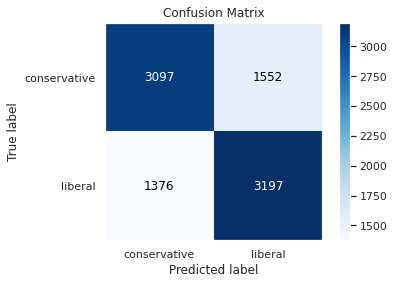

In [ ]:
plot_confusion_matrix(cmtrain_lr,['conservative','liberal'],False)

Confusion Matrix, without Normalization


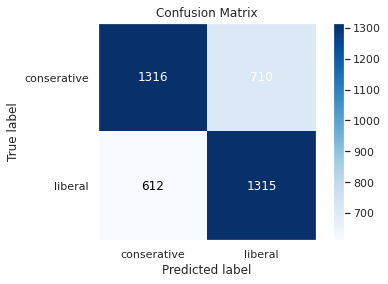

In [ ]:
plot_confusion_matrix(cmtest_lr,['conserative','liberal'],False)

#### Experimenting with Different Parameters

##### Solver: 'lbfgs' or 'saga'?

In [ ]:
solver_list = ['lbfgs','saga']
params = dict(solver=solver_list)
lr = LogisticRegression(C=1,n_jobs=-1,random_state=42)
clf = GridSearchCV(lr,params,cv=5)
clf.fit(X_train,y_train)
scores = clf.cv_results_['mean_test_score']

for score, solver in zip(scores, solver_list):
  print(f'{solver} {score:.3f}')

lbfgs 0.665
saga 0.665


They are basically the same, and 'lbfgs' we saw earlier is much faster, so that's what we'll use here. 

##### Validation curve for C-values

In [ ]:
# Use a loop to test the effect of varying the C parameter from 0.05 to 1.5 in increments of 0.05.
c_vals = np.arange(0.05,1.5,0.05)
test_accuracy = []
train_accuracy = []

for c in c_vals:
  lr = LogisticRegression(solver='lbfgs',C=c,max_iter=1000,random_state=42)
  lr.fit(X_train,y_train)
  test_accuracy.append(lr.score(X_test,y_test))
  train_accuracy.append(lr.score(X_train,y_train))

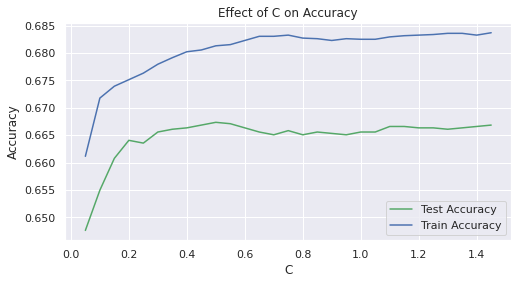

In [ ]:
# Plot a graph to show the accuracy of the test data versus the accuracy of the training data. Select an appropriate value for C and explain why that may be the best value.
fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(1,1,1)
ax1.plot(c_vals,test_accuracy,'-g',label='Test Accuracy')
ax1.plot(c_vals,train_accuracy,'-b',label='Train Accuracy')
ax1.set(xlabel='C',ylabel='Accuracy')
ax1.set_title('Effect of C on Accuracy')
ax1.legend()
plt.show()

In [ ]:
fig.savefig('c_vals.png')
files.download('c_vals.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Find where the Maximum Teset Accuracy Occurs
for i in range(len(test_accuracy)):
  if test_accuracy[i] == max(test_accuracy):
    index = i
    print('Best C-Value: {}'.format(c_vals[index]))

Best C-Value: 0.5


In [ ]:
c_vals2 = [.001, .01, .1, 1, 10, 100, 1000]
test_accuracy2 = []
train_accuracy2 = []
for c in c_vals2:
  lr = LogisticRegression(solver='lbfgs',max_iter=10000,C=c,random_state=42)
  lr.fit(X_train,y_train)
  test_accuracy2.append(lr.score(X_test,y_test))
  train_accuracy2.append(lr.score(X_train,y_train))

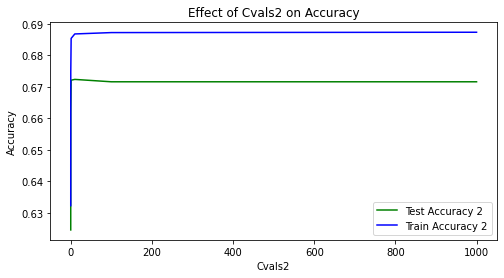

In [ ]:
# Plot a graph to show the accuracy of the test data versus the accuracy of the training data. Select an appropriate value for C and explain why that may be the best value.
fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(1,1,1)
ax1.plot(c_vals2,test_accuracy2,'-g',label='Test Accuracy 2')
ax1.plot(c_vals2,train_accuracy2,'-b',label='Train Accuracy 2')
ax1.set(xlabel='Cvals2',ylabel='Accuracy')
ax1.set_title('Effect of Cvals2 on Accuracy')
ax1.legend()
plt.show()

Based on these validation curves, it's clear that the ideal measure of C is around 2.0 

It is possible that we could increase the scores of the Logistic Regression model by finding optimal values for C and max_iters, but we will try other models first and then come back to this if necessary.

#### Best Logistic Regression Model

In [ ]:
final_lr_params = {'C':0.5,'max_iter':1000,'solver':'lbfgs'}

lr_final = LogisticRegression(**final_lr_params)

lr_final.fit(X_train,y_train)
lr_final_trainscore = lr_final.score(X_train,y_train)
lr_final_testscore = lr_final.score(X_test,y_test)

cmtrain_lr_final,cmtest_lr_final = run_evaluate_model(lr_final,X,Y)

Scores on Training Data:
--------------------
Accuracy: 0.6813055736282801
Precision: 0.6723628691983122
Recall: 0.6969166848895693
----------------------------------------
Scores on Test Data:
--------------------
Accuracy: 0.6673412598026816
Precision: 0.650887573964497
Recall: 0.6850025947067981
----------------------------------------


Confusion Matrix, without Normalization


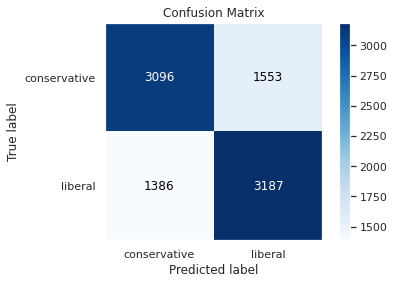

In [ ]:
plot_confusion_matrix(cmtrain_lr_final,['conservative','liberal'],False)

Confusion Matrix, without Normalization


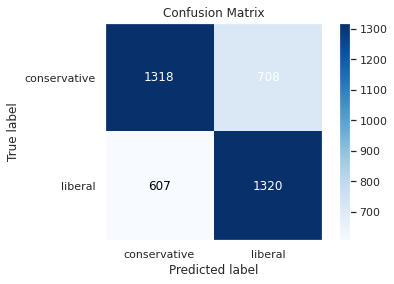

In [ ]:
plot_confusion_matrix(cmtest_lr_final,['conservative','liberal'],False)

### Random Forest

#### Base Model

In [ ]:
rf = RandomForestClassifier(random_state=42)

In [ ]:
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [ ]:
default_params = {'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [ ]:
cmtrain,cmtest=run_evaluate_model(rf,X,Y)

Scores on Training Data:
--------------------
Accuracy: 0.9483842984168294
Precision: 0.9499231276081704
Recall: 0.9457686420293024
----------------------------------------
Scores on Test Data:
--------------------
Accuracy: 0.706046040981533
Precision: 0.690963554667998
Recall: 0.7182148417228853
----------------------------------------


Confusion Matrix, without Normalization


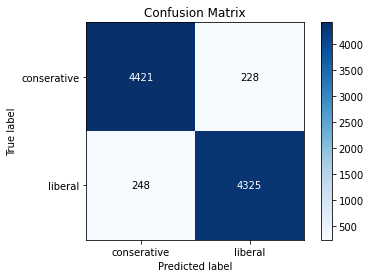

In [ ]:
plot_confusion_matrix(cmtrain,['conserative','liberal'],False)

Confusion Matrix, without Normalization


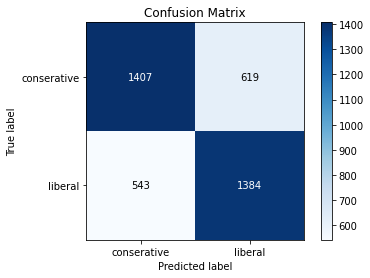

In [ ]:
plot_confusion_matrix(cmtest,['conserative','liberal'],False)

Indeed, the accuracy is better than when using Logistic Regression. We'll stick with Random Forest.

The training data set, however, is performing MUCH better than the test data set, let's see if we can adjust the parameters to prevent overfitting.

#### Hyperparameter Search

##### Random Search

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 36.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 66.6min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [ ]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 30,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 400}

In [ ]:
best_random_params = {'bootstrap': True,
 'max_depth': 30,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 400}

##### Grid Search CV Based on Best Random Params Found

###### Grid Search 1 

In [ ]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [25,30,40,50],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1,2],
    'min_samples_split': [3,5,7],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)


In [ ]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed: 18.0min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [ ]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 40,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 7,
 'n_estimators': 300}

In [ ]:
best_grid_params1 = {'bootstrap': True,
 'max_depth': 40,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 7,
 'n_estimators': 300}

In [ ]:
max_feature_list = ['sqrt','auto']

for max_feature_op in max_feature_list:
  params = {'bootstrap': True,
            'max_depth': 40,
            'max_features': max_feature_op,
            'min_samples_leaf': 1,
            'min_samples_split': 7,
            'n_estimators': 500}
  rf = RandomForestClassifier(**params)
  print('max_feature param: {}'.format(max_feature_op))
  run_evaluate_model(rf,X,Y)
  print('-'*40)

max_feature param: sqrt
Scores on Training Data:
--------------------
Accuracy: 0.8630448926480156
Precision: 0.854997854997855
Recall: 0.8716378744806472
----------------------------------------
Scores on Test Data:
--------------------
Accuracy: 0.7131292689096889
Precision: 0.6954164613109907
Recall: 0.7322262584327971
----------------------------------------
----------------------------------------
max_feature param: auto
Scores on Training Data:
--------------------
Accuracy: 0.8632617653437432
Precision: 0.8546038543897216
Recall: 0.8727312486332823
----------------------------------------
Scores on Test Data:
--------------------
Accuracy: 0.7123703516316722
Precision: 0.695351137487636
Recall: 0.7296315516346653
----------------------------------------
----------------------------------------


In [ ]:
leaf_ops = [1,2,3]

for leaf_op in leaf_ops:
  params = {'bootstrap': True,
            'max_depth': 40,
            'max_features': 'sqrt',
            'min_samples_leaf': leaf_op,
            'min_samples_split': 7,
            'n_estimators': 500}
  rf = RandomForestClassifier(**params)
  print('min_sample_leaf: {}'.format(leaf_op))
  run_evaluate_model(rf,X,Y)
  print('-'*40)

min_sample_leaf: 1
Scores on Training Data:
--------------------
Accuracy: 0.8614183474300585
Precision: 0.8539205155746509
Recall: 0.8692324513448502
----------------------------------------
Scores on Test Data:
--------------------
Accuracy: 0.7146471034657222
Precision: 0.6990533134030892
Recall: 0.7280747275557862
----------------------------------------
----------------------------------------
min_sample_leaf: 2
Scores on Training Data:
--------------------
Accuracy: 0.7808501409672522
Precision: 0.7645107794361525
Recall: 0.8064727749835994
----------------------------------------
Scores on Test Data:
--------------------
Accuracy: 0.7019984821654439
Precision: 0.6803081367356765
Recall: 0.7332641411520499
----------------------------------------
----------------------------------------
min_sample_leaf: 3
Scores on Training Data:
--------------------
Accuracy: 0.7443070917371503
Precision: 0.727833779057807
Recall: 0.7736715504045485
----------------------------------------
Score

In [ ]:
depths = [40,45,50,55,60]

for depth in depths:
  params = {'bootstrap': True,
            'max_depth': depth,
            'max_features': 'sqrt',
            'min_samples_leaf': 1,
            'min_samples_split': 7,
            'n_estimators': 500}
  rf = RandomForestClassifier(**params)
  print('max_depth: {}'.format(depth))
  run_evaluate_model(rf,X,Y)
  print('-'*40)

max_depth: 40
Scores on Training Data:
--------------------
Accuracy: 0.8604424202992843
Precision: 0.8512184694313809
Recall: 0.8707631751585393
----------------------------------------
Scores on Test Data:
--------------------
Accuracy: 0.7095876549456109
Precision: 0.6927263730826324
Recall: 0.7265179034769071
----------------------------------------
----------------------------------------
max_depth: 45
Scores on Training Data:
--------------------
Accuracy: 0.8747560182173064
Precision: 0.8692739844425238
Recall: 0.8797288432101465
----------------------------------------
Scores on Test Data:
--------------------
Accuracy: 0.7083227928155831
Precision: 0.6917740336967294
Recall: 0.7244421380384016
----------------------------------------
----------------------------------------
max_depth: 50
Scores on Training Data:
--------------------
Accuracy: 0.8874430709173715
Precision: 0.8824929668902834
Recall: 0.8917559588891318
----------------------------------------
Scores on Test Data

###### Grid Search 2

In [ ]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [40,50,60,70,80],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1,2],
    'min_samples_split': [7,8,9],
    'n_estimators': [450, 475, 500, 525, 550]
}

In [ ]:
# Create a based model
rf = RandomForestClassifier()

In [ ]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 150 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 15.9min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 37.0min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed: 46.3min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [ ]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 50,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 7,
 'n_estimators': 550}

In [ ]:
best_grid_params2 = {'bootstrap': True,
 'max_depth': 50,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 7,
 'n_estimators': 550,
 'random_state': 42}


##### Evaluation Models Based on Default, Random and Grid Search Params

In [ ]:
default_params

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

###### Default Params

In [ ]:
rf_default = RandomForestClassifier(**default_params)
cmtrain_default,cmtest_default = run_evaluate_model(rf_default,X,Y)

Scores on Training Data:
--------------------
Accuracy: 0.9483842984168294
Precision: 0.9499231276081704
Recall: 0.9457686420293024
----------------------------------------
Scores on Test Data:
--------------------
Accuracy: 0.706046040981533
Precision: 0.690963554667998
Recall: 0.7182148417228853
----------------------------------------


Confusion Matrix, without Normalization


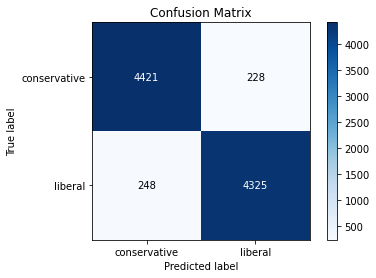

In [ ]:
plot_confusion_matrix(cmtrain_default,['conservative','liberal'],False)

Confusion Matrix, without Normalization


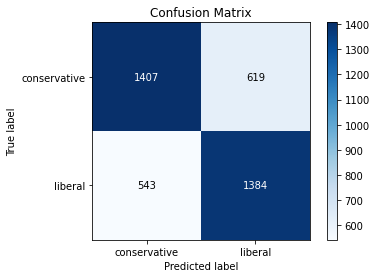

In [ ]:
plot_confusion_matrix(cmtest_default,['conservative','liberal'],False)

###### Best Random Search Parameters

In [ ]:
rf_random = RandomForestClassifier(**best_random_params)
cmtrain_random,cmtest_random = run_evaluate_model(rf_random,X,Y)

Scores on Training Data:
--------------------
Accuracy: 0.8366948601171112
Precision: 0.8246876984967182
Recall: 0.8517384649026897
----------------------------------------
Scores on Test Data:
--------------------
Accuracy: 0.7030103718694662
Precision: 0.6830335439961108
Recall: 0.7291126102750389
----------------------------------------


Confusion Matrix, without Normalization


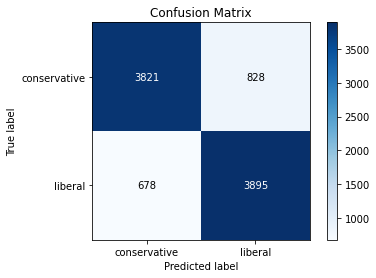

In [ ]:
plot_confusion_matrix(cmtrain_random,['conservative','liberal'],False)

Confusion Matrix, without Normalization


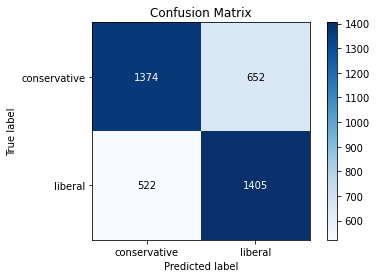

In [ ]:
plot_confusion_matrix(cmtest_random,['conservative','liberal'],False)

###### Best Grid Search 1 Parameters

In [ ]:
rf_grid1 = RandomForestClassifier(**best_grid_params1)
cmtrain_grid1,cmtest_grid1 = run_evaluate_model(rf_grid1,X,Y)

Scores on Training Data:
--------------------
Accuracy: 0.8646714378659727
Precision: 0.8577576931353561
Recall: 0.8716378744806472
----------------------------------------
Scores on Test Data:
--------------------
Accuracy: 0.7126233240576777
Precision: 0.6964729259811226
Recall: 0.7275557861961598
----------------------------------------


Confusion Matrix, without Normalization


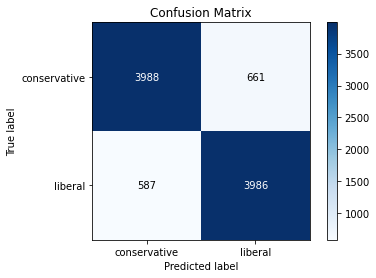

In [ ]:
plot_confusion_matrix(cmtrain_grid1,['conservative','liberal'],False)

Confusion Matrix, without Normalization


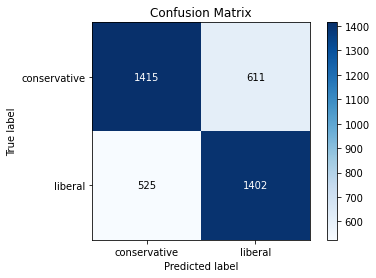

In [ ]:
plot_confusion_matrix(cmtest_grid1,['conservative','liberal'],False)

###### Best Grid Search 2 Parameters

In [ ]:
rf_grid2 = RandomForestClassifier(**best_grid_params2)
cmtrain_grid2,cmtest_grid2 = run_evaluate_model(rf_grid2,X,Y)

Scores on Training Data:
--------------------
Accuracy: 0.8875515072652354
Precision: 0.884180790960452
Recall: 0.8897878854143888
----------------------------------------
Scores on Test Data:
--------------------
Accuracy: 0.7113584619276498
Precision: 0.6959122632103689
Recall: 0.7244421380384016
----------------------------------------


Confusion Matrix, without Normalization


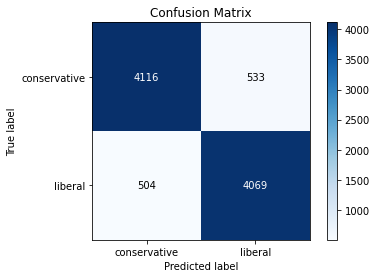

In [ ]:
plot_confusion_matrix(cmtrain_grid2,['conservative','liberal'],False)

Confusion Matrix, without Normalization


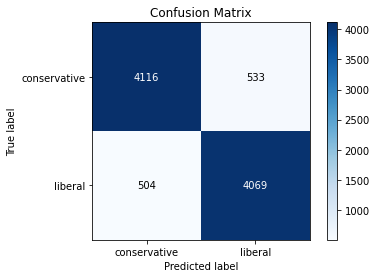

In [ ]:
plot_confusion_matrix(cmtrain_grid2,['conservative','liberal'],False)

Unfortunately after an extensive random search and grid search process, the results are not that much better than the default parameters. 

#### Best Random Forest Model

The best Random Forest model found uses the parameters found during the Random Search. Although the accuracy is still quite low at ~70%, and it is not the highest accuracy, it's the one that accounts for overfitting the most, although it still overfits quite a bit.

In [ ]:
final_rf_params = {'bootstrap': True,
 'max_depth': 30,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 400}

rf_final = RandomForestClassifier(**final_rf_params)

rf_final.fit(X_train,y_train)
rf_final_trainscore = rf_final.score(X_train,y_train)
rf_final_testscore = rf_final.score(X_test,y_test)

cmtrain_rf_final,cmtest_rf_final = run_evaluate_model(rf_final,X,Y)

Scores on Training Data:
--------------------
Accuracy: 0.8402732595966168
Precision: 0.8282507412113511
Recall: 0.8552372621911218
----------------------------------------
Scores on Test Data:
--------------------
Accuracy: 0.7052871237035163
Precision: 0.68603515625
Recall: 0.7291126102750389
----------------------------------------


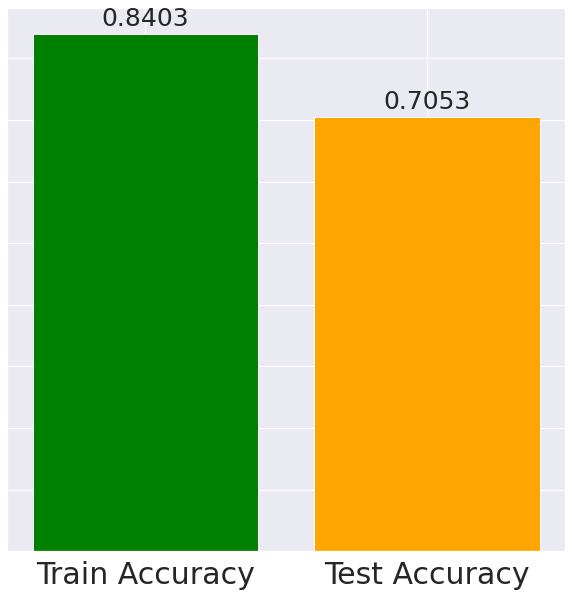

In [ ]:
height = [.8403,.7053]
bars = ('Train Accuracy','Test Accuracy')
y_pos = np.arange(len(bars))

rf_graphic = plt.figure(figsize=(10,10))
plt.bar(y_pos,height,color=['green','orange'])
plt.xticks(y_pos, bars)
plt.annotate('{}'.format(height[0]),xy = (y_pos[0],height[0]),xytext=(0,3),fontsize=25,textcoords='offset points',ha='center',va='bottom')
plt.annotate('{}'.format(height[1]),xy = (y_pos[1],height[1]),xytext=(0,3),fontsize=25,textcoords='offset points',ha='center',va='bottom')
plt.tick_params(labelsize=30)
plt.tick_params(axis='y',labelleft=False)
plt.show()


In [ ]:
rf_graphic.savefig('rf_graphic.png')
files.download('rf_graphic.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Confusion Matrix, without Normalization


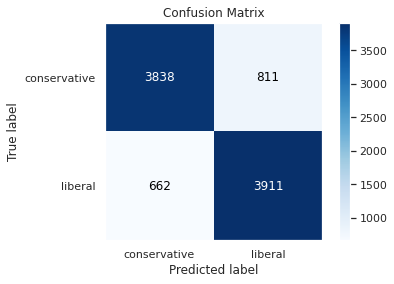

In [ ]:
plot_confusion_matrix(cmtrain_rf_final,['conservative','liberal'],False)

Confusion Matrix, without Normalization


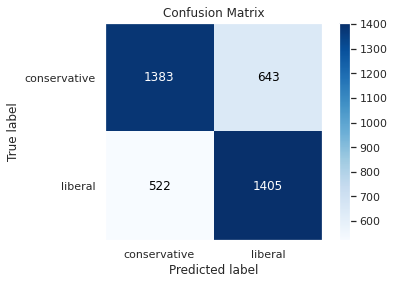

In [ ]:
plot_confusion_matrix(cmtest_rf_final,['conservative','liberal'],False)

### K-Nearest Neighbors 

#### Base Model

In [ ]:
knn = KNeighborsClassifier(n_neighbors=10)
cmtrain_knn,cmtest_knn=run_evaluate_model(knn,X,Y)

Scores on Training Data:
--------------------
Accuracy: 0.7938625027109087
Precision: 0.8387423935091278
Recall: 0.723376339383337
----------------------------------------
Scores on Test Data:
--------------------
Accuracy: 0.7245130280799393
Precision: 0.7533252720677146
Recall: 0.6466009340944473
----------------------------------------


#### Investigating Different Parameters of n_neighbors

In [ ]:
neighbors_list = np.arange(3,20,1)

In [ ]:
train_accuracy = []
test_accuracy = []

for n in neighbors_list:
  knn=KNeighborsClassifier(n_neighbors=n)
  knn.fit(X_train,y_train)
  train_pred = knn.predict(X_train)
  test_pred = knn.predict(X_test)
  train_score = accuracy_score(train_pred,y_train)
  train_accuracy.append(train_score)
  test_score = accuracy_score(test_pred,y_test)
  test_accuracy.append(test_score)


In [ ]:
test_accuracy = [0.7105995446496332,
 0.7012395648874272,
 0.7229951935239058,
 0.7232481659499115,
 0.7260308626359727,
 0.717682772577789,
 0.7295724766000506,
 0.7245130280799393,
 0.7323551732861118,
 0.7288135593220338,
 0.7303313938780673,
 0.7257778902099671,
 0.7224892486718948,
 0.7146471034657222,
 0.7207184416898558,
 0.7232481659499115,
 0.7143941310397167]

In [ ]:
train_accuracy = [0.8566471481240512,
 0.8044892648015615,
 0.8219475168076339,
 0.798091520277597,
 0.808067664281067,
 0.7951637388852744,
 0.8013446107135112,
 0.7938625027109087,
 0.7954890479288658,
 0.7851875948818043,
 0.7881153762741271,
 0.7815007590544351,
 0.7777054868792019,
 0.7723921058338755,
 0.7734764693125136,
 0.7690305790500976,
 0.7661027976577749]

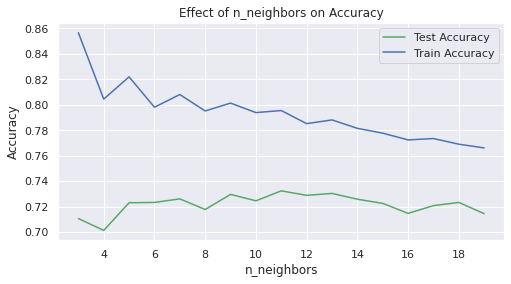

In [ ]:
# Plot a graph to show the accuracy of the test data versus the accuracy of the training data. Select an appropriate value for C and explain why that may be the best value.
fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(1,1,1)
ax1.plot(neighbors_list,test_accuracy,'-g',label='Test Accuracy')
ax1.plot(neighbors_list,train_accuracy,'-b',label='Train Accuracy')
ax1.set(xlabel='n_neighbors',ylabel='Accuracy')
ax1.set_title('Effect of n_neighbors on Accuracy')
ax1.legend()
plt.show()

In [ ]:
fig.savefig('knn_valcurve.png')
files.download('knn_valcurve.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
max(test_accuracy)

0.7323551732861118

In [ ]:
for i in range(len(test_accuracy)):
  if test_accuracy[i] == max(test_accuracy):
    print(i)

8


In [ ]:
test_accuracy[8]

0.7323551732861118

In [ ]:
neighbors_list[8]

11

The maximum test accuracy occurs at n_neighbors = 11

In [ ]:
knn=KNeighborsClassifier(n_neighbors=11)
cmtrain_knn,cmtest_knn=run_evaluate_model(knn,X,Y)

Scores on Training Data:
--------------------
Accuracy: 0.7954890479288658
Precision: 0.793020719738277
Recall: 0.7951016837961951
----------------------------------------
Scores on Test Data:
--------------------
Accuracy: 0.7323551732861118
Precision: 0.7204464738711314
Recall: 0.7368967306694344
----------------------------------------


Confusion Matrix, without Normalization


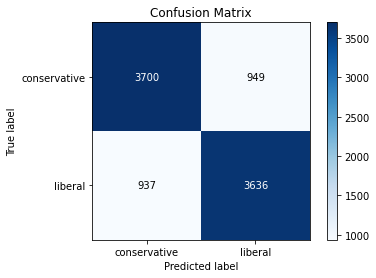

In [ ]:
plot_confusion_matrix(cmtrain_knn,['conservative','liberal'],False)

Confusion Matrix, without Normalization


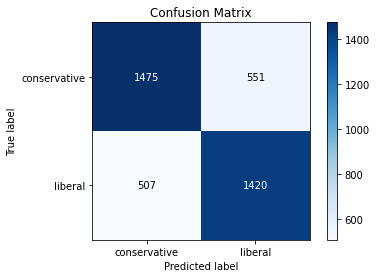

In [ ]:
plot_confusion_matrix(cmtest_knn,['conservative','liberal'],False)

In [ ]:
accuracy_diffs = []

for i in range(len(train_accuracy)):
  accuracy_diffs.append(train_accuracy[i]-test_accuracy[i])

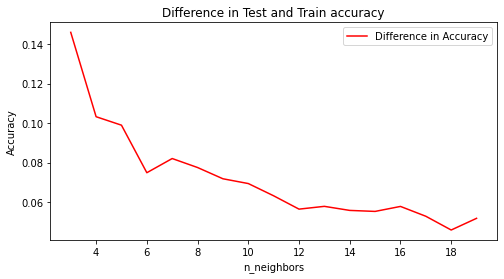

In [ ]:
# Plot a graph to show the accuracy of the test data versus the accuracy of the training data.
fig = plt.figure(figsize=(8,4))
plt.plot(neighbors_list,accuracy_diffs, '-r',label='Difference in Accuracy')
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.title('Difference in Test and Train accuracy')
plt.legend()
plt.show()

In [ ]:
for i in range(len(accuracy_diffs)):
  if accuracy_diffs[i] == min(accuracy_diffs):
    print(i)

15


In [ ]:
neighbors_list[15]

18

In [ ]:
ratio = []

for i in range(len(accuracy_diffs)):
  ratio.append(accuracy_diffs[i]/test_accuracy[i])

In [ ]:
min(ratio)

0.06330111192201325

In [ ]:
for i in range(len(ratio)):
  if ratio[i] == min(ratio):
    print(i)

15


In [ ]:
test_accuracy[15]

0.7232481659499115

#### Best KNN Model

The best KNN model is one which uses n_neighbors = 18

In [ ]:
knn_final = KNeighborsClassifier(n_neighbors=18)
knn_final.fit(X_train,y_train)
knn_final_trainscore = knn_final.score(X_train,y_train)
knn_final_testcore = knn_final.score(X_test,y_test)
cmtrain_knn_final,cmtest_knn_final=run_evaluate_model(knn_final,X,Y)

Scores on Training Data:
--------------------
Accuracy: 0.7690305790500976
Precision: 0.7866697958225769
Recall: 0.7329980319265252
----------------------------------------
Scores on Test Data:
--------------------
Accuracy: 0.7232481659499115
Precision: 0.732811626607043
Recall: 0.6803321224701608
----------------------------------------


Confusion Matrix, without Normalization


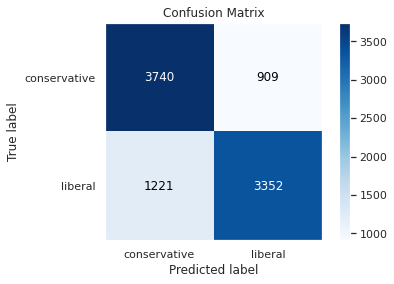

In [ ]:
plot_confusion_matrix(cmtrain_knn_final,['conservative','liberal'],False)

Confusion Matrix, without Normalization


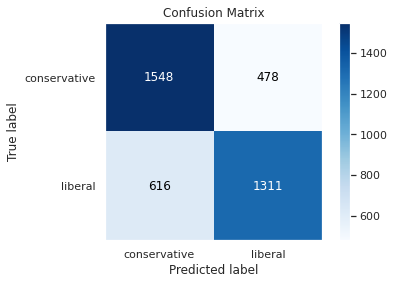

In [ ]:
plot_confusion_matrix(cmtest_knn_final,['conservative','liberal'],False)

### Gradient Boosting Model

#### Base Model

In [ ]:
# Using a classifier, we'll set the original params

params1 = {'n_estimators':500,
           'max_depth': 2,
           'loss':'deviance'}

In [ ]:
# Initiate and fit the model
clf = GradientBoostingClassifier(**params1)
clf.fit(X_train,y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=2,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=500,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
# Predict outcomes for X_train and y_train
# Save outcomes to variables
predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

Confusion Matrix, without Normalization


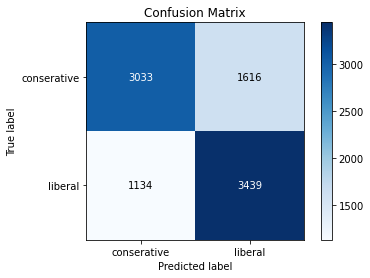

In [ ]:
cmtrain = confusion_matrix(y_train,predict_train)
cmtest = confusion_matrix(y_test,predict_test)
# Training Data Confusion Matrix
plot_confusion_matrix(cmtrain,['conserative','liberal'],False)

Confusion Matrix, without Normalization


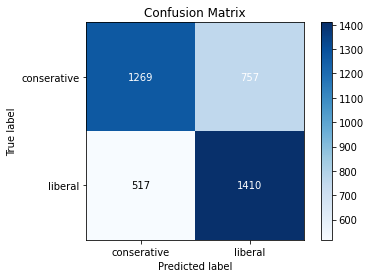

In [ ]:
# Test Data Confusion Matrix
plot_confusion_matrix(cmtest,['conserative','liberal'],False)

In [ ]:
original_train_accuracy = accuracy_score(predict_train,y_train)
original_test_accuracy = accuracy_score(predict_test,y_test)
precision_og = cmtest[1][1] / (cmtest[1][1] + cmtest[0][1])
recall_og = cmtest[1][1] / (cmtest[1][1] + cmtest[1][0])
print(f'Train Accuracy: {original_train_accuracy}\nTest Accuracy: {original_test_accuracy}\nPrecision: {precision_og}\nRecall: {recall_og}')

Train Accuracy: 0.7018000433745392
Test Accuracy: 0.6777131292689097
Precision: 0.6506691278264882
Recall: 0.7317073170731707


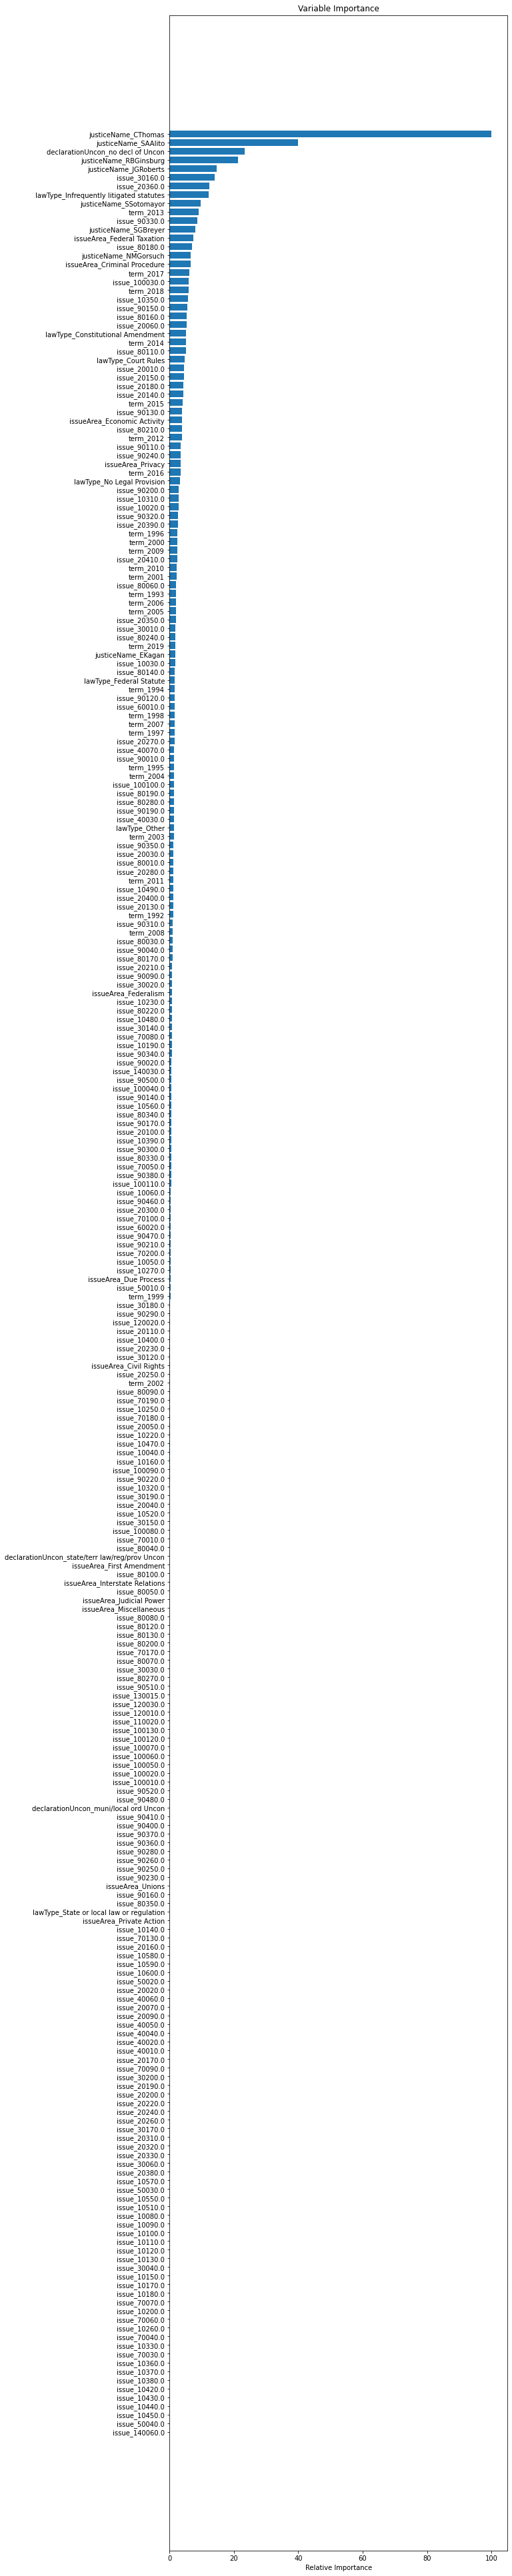

In [ ]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(20,70))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [ ]:
clf.get_params

<bound method BaseEstimator.get_params of GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=2,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=500,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)>

#### Investigating Different Parameters

In [ ]:
original_test_accuracy = 0.6777131292689097
precision_og = 0.6506691278264882
recall_og = 0.7317073170731707

In [ ]:
# Write a function to run the model with only X, y, and params as inputs

def run_boost_model(x, y, params):
  # Create training and test sets
  X_train,X_test,y_train,y_test = train_test_split(X,y,test_size= 0.3,random_state=42)

  # Initiate and fit the model
  clf = GradientBoostingClassifier(**params)
  clf.fit(X_train,y_train)

  # Predict outcomes for X_train and y_train
  # Save outcomes to variables
  predict_train = clf.predict(X_train)
  predict_test = clf.predict(X_test)

  cmtest = confusion_matrix(y_test,predict_test)
  cmtrain = confusion_matrix(y_train,predict_train)

  test_score = clf.score(X_test, y_test)
  train_score = clf.score(X_train,y_train)
  precision = cmtest[1][1] / (cmtest[1][1] + cmtest[0][1])
  recall = cmtest[1][1] / (cmtest[1][1] + cmtest[1][0])
  print('Train Accuracy: {}\nTest Accuracy: {}\nOriginal Accuracy {}'.format(train_score,test_score,original_test_accuracy))
  if test_score > original_test_accuracy:
    print('GAIN')
  else:
    print('LOSS')
  print('-'*20)
  print('Precision: {}\nOriginal Precision {}'.format(precision,precision_og))
  if precision > precision_og:
    print('GAIN')
  else:
    print('LOSS')
  print('-'*20)
  print('Recall: {}\nOriginal Recall {}'.format(recall,recall_og))
  if recall > recall_og:
    print('GAIN')
  else:
    print('LOSS')
  return train_score,test_score

##### loss

In [ ]:
params={'loss':'exponential'}
run_boost_model(X,Y,params)

Train Accuracy: 0.6862936456300152
Test Accuracy: 0.6688590943587149
Original Accuracy 0.6777131292689097
LOSS
--------------------
Precision: 0.6395663956639567
Original Precision 0.6506691278264882
LOSS
--------------------
Recall: 0.7348209652309289
Original Recall 0.7317073170731707
GAIN


Changing the 'loss' param to exponential only improved recall. 

##### learning rates

In [ ]:
train_scores_learningrate = []
test_scores_learningrate = []
learning_rates = [0.1, 0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
for learning_rate in learning_rates:
  params = {'learning_rate': learning_rate}
  print('Learning Rate = {}'.format(learning_rate))
  print('-'*40)
  train_score_lr,test_score_lr = run_boost_model(X,Y,params)
  print('-'*40)
  train_scores_learningrate.append(train_score_lr)
  test_scores_learningrate.append(test_score_lr)

Learning Rate = 0.1
----------------------------------------
Train Accuracy: 0.6851008458035134
Test Accuracy: 0.6696180116367316
Original Accuracy 0.6777131292689097
LOSS
--------------------
Precision: 0.643021649009673
Original Precision 0.6506691278264882
LOSS
--------------------
Recall: 0.7244421380384016
Original Recall 0.7317073170731707
LOSS
----------------------------------------
Learning Rate = 0.2
----------------------------------------
Train Accuracy: 0.7096074604207331
Test Accuracy: 0.6761952947128763
Original Accuracy 0.6777131292689097
LOSS
--------------------
Precision: 0.6463138851198552
Original Precision 0.6506691278264882
LOSS
--------------------
Recall: 0.7415672029060716
Original Recall 0.7317073170731707
GAIN
----------------------------------------
Learning Rate = 0.3
----------------------------------------
Train Accuracy: 0.7248969854695294
Test Accuracy: 0.6893498608651657
Original Accuracy 0.6777131292689097
GAIN
--------------------
Precision: 0.66188

In [ ]:
learning_rates = [0.1, 0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

In [ ]:
train_scores_learningrate = [0.6851008458035134,
 0.7096074604207331,
 0.7248969854695294,
 0.7410540013012362,
 0.7491867273910214,
 0.7548254174799393,
 0.7722836694860117,
 0.7821513771416179,
 0.7786814140099761,
 0.7826935588809368]

In [ ]:
test_scores_learningrate = [0.6696180116367316,
 0.6761952947128763,
 0.6893498608651657,
 0.6984568682013661,
 0.7075638755375664,
 0.7014925373134329,
 0.7156589931697445,
 0.7131292689096889,
 0.7138881861877056,
 0.7171768277257778]

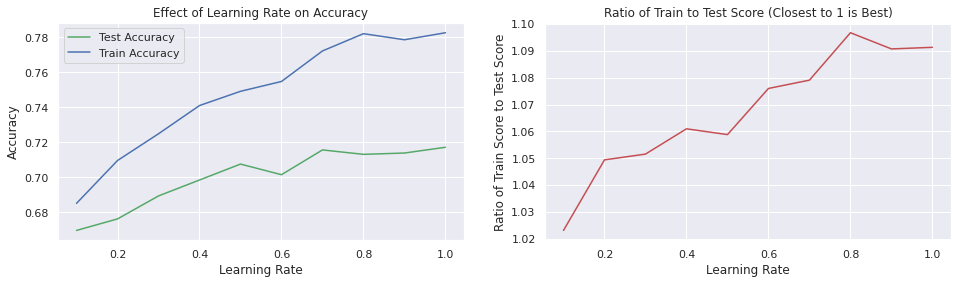

In [ ]:
ratio_learnrate = []

for i in range(len(test_scores_learningrate)):
  ratio_learnrate.append(train_scores_learningrate[i]/test_scores_learningrate[i])

# Plot a graph to show the accuracy of the test data versus the accuracy of the training data. 
fig = plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.plot(learning_rates,test_scores_learningrate,'-g',label='Test Accuracy')
ax1.plot(learning_rates,train_scores_learningrate,'-b',label='Train Accuracy')
ax1.set(xlabel='Learning Rate',ylabel='Accuracy')
ax1.set_title('Effect of Learning Rate on Accuracy')
ax1.legend()
ax2.plot(learning_rates,ratio_learnrate,'-r')
ax2.set(xlabel='Learning Rate',ylabel='Ratio of Train Score to Test Score')
ax2.set_title('Ratio of Train to Test Score (Closest to 1 is Best)')
plt.show()

In [ ]:
fig.savefig('learningrate.png')
files.download('learningrate.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

We see that as we increase the learning rate, the model is tending to overfit significantly. We can play with a learning rate of .3, but ultimately I think a learning rate of 0.1 will help, and we'll use n_estimators to increase the accuracy considering it is fairly robust to overfitting.

##### n_estimators

In [ ]:
test_accuracy_n = []
train_accuracy_n = []
n_estimators_list = np.arange(100,2000,100)
for n_estimators in n_estimators_list:
  params = {'loss': 'deviance', 'max_depth': 2,'learning_rate':0.3, 'n_estimators': n_estimators}
  print('Estimator Number = {}'.format(n_estimators))
  print('-'*40)
  train_score_n,test_score_n = run_boost_model(X,Y,params)
  print('-'*40)
  test_accuracy_n.append(test_score_n)
  train_accuracy_n.append(train_score_n)

Estimator Number = 100
----------------------------------------
Train Accuracy: 0.6912817176317502
Test Accuracy: 0.6761952947128763
Original Accuracy 0.6777131292689097
LOSS
--------------------
Precision: 0.6490096729617688
Original Precision 0.6506691278264882
LOSS
--------------------
Recall: 0.7311883757135443
Original Recall 0.7317073170731707
LOSS
----------------------------------------
Estimator Number = 200
----------------------------------------
Train Accuracy: 0.7126436781609196
Test Accuracy: 0.6853023020490766
Original Accuracy 0.6777131292689097
GAIN
--------------------
Precision: 0.662078785002373
Original Precision 0.6506691278264882
GAIN
--------------------
Recall: 0.7239231966787752
Original Recall 0.7317073170731707
LOSS
----------------------------------------
Estimator Number = 300
----------------------------------------
Train Accuracy: 0.7235957492951638
Test Accuracy: 0.6926385024032381
Original Accuracy 0.6777131292689097
GAIN
--------------------
Precision

In [ ]:
n_estimators_list = np.arange(100,2000,100)

In [ ]:
test_accuracy_n = [0.6761952947128763,
 0.6853023020490766,
 0.6926385024032381,
 0.6946622818112825,
 0.7017455097394384,
 0.7075638755375664,
 0.7088287376675942,
 0.7121173792056665,
 0.7232481659499115,
 0.7303313938780673,
 0.7379205666582342,
 0.7422210979003289,
 0.7450037945863901,
 0.7493043258284847,
 0.7523399949405515,
 0.7553756640526182,
 0.7576524158866683,
 0.7561345813306349,
 0.7571464710346573]

In [ ]:
train_accuracy_n = [0.6912817176317502,
 0.7126436781609196,
 0.7235957492951638,
 0.7380177835610496,
 0.7474517458252006,
 0.7561266536543049,
 0.7685968336586424,
 0.7783561049663847,
 0.7867057037518976,
 0.7978746475818694,
 0.8088267187161137,
 0.8167425721101713,
 0.8217306441119063,
 0.8262849707221861,
 0.8313814790717848,
 0.8394057688137063,
 0.842875731945348,
 0.8452613315983518,
 0.8486228583821297]

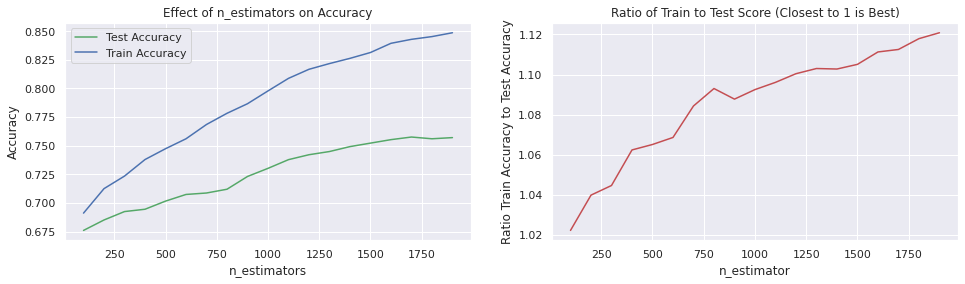

In [ ]:
ratio_n = []

for i in range(len(test_accuracy_n)):
  ratio_n.append(train_accuracy_n[i]/ test_accuracy_n[i])

# Plot a graph to show the accuracy of the test data versus the accuracy of the training data. 
fig = plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.plot(n_estimators_list,test_accuracy_n,'-g',label='Test Accuracy')
ax1.plot(n_estimators_list,train_accuracy_n,'-b',label='Train Accuracy')
ax1.set(xlabel='n_estimators',ylabel='Accuracy')
ax1.set_title('Effect of n_estimators on Accuracy')
ax1.legend()
ax2.plot(n_estimators_list,ratio_n,'-r')
ax2.set(xlabel='n_estimator',ylabel='Ratio Train Accuracy to Test Accuracy')
ax2.set_title('Ratio of Train to Test Score (Closest to 1 is Best)')
plt.show()

In [ ]:
fig.savefig('nests.png')
files.download('nests.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The test accuracy continually increases but starts to do so less steeply at around 1100 or so. 

##### subsample

In [ ]:
train_accuracy_sub = []
test_accuracy_sub = []
subsamples = np.arange(.5,1.01,.1)
for subsample in subsamples:
  params = {'loss': 'deviance', 'max_depth': 2,'learning_rate':0.3, 'n_estimators': 1100,'subsample':subsample}
  print('Subsample Param = {}'.format(subsample))
  print('-'*40)
  train_sub, test_sub = run_boost_model(X,Y,params)
  print('-'*40)
  train_accuracy_sub.append(train_sub)
  test_accuracy_sub.append(test_sub)

Subsample Param = 0.5
----------------------------------------
Train Accuracy: 0.8022121014964216
Test Accuracy: 0.7315962560080951
Original Accuracy 0.6777131292689097
GAIN
--------------------
Precision: 0.7211440245148111
Original Precision 0.6506691278264882
GAIN
--------------------
Recall: 0.7327451997924235
Original Recall 0.7317073170731707
GAIN
----------------------------------------
Subsample Param = 0.6
----------------------------------------
Train Accuracy: 0.7817176317501626
Test Accuracy: 0.7212243865418669
Original Accuracy 0.6777131292689097
GAIN
--------------------
Precision: 0.7129581827568404
Original Precision 0.6506691278264882
GAIN
--------------------
Recall: 0.7166580176440063
Original Recall 0.7317073170731707
LOSS
----------------------------------------
Subsample Param = 0.7
----------------------------------------
Train Accuracy: 0.8216222077640425
Test Accuracy: 0.7460156842904123
Original Accuracy 0.6777131292689097
GAIN
--------------------
Precision: 

In [ ]:
train_accuracy_sub

[0.8022121014964216,
 0.7817176317501626,
 0.8216222077640425,
 0.8208631533289958,
 0.8170678811537627,
 0.8062242463673823]

In [ ]:
test_accuracy_sub

[0.7315962560080951,
 0.7212243865418669,
 0.7460156842904123,
 0.74045029091829,
 0.7399443460662788,
 0.7313432835820896]

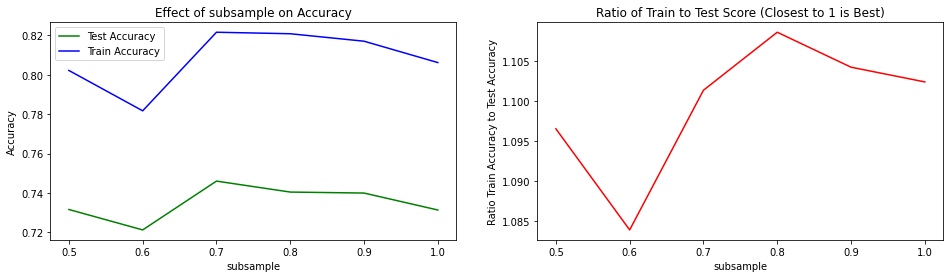

In [ ]:
ratio_sub = []

for i in range(len(test_accuracy_sub)):
  ratio_sub.append(train_accuracy_sub[i]/ test_accuracy_sub[i])

# Plot a graph to show the accuracy of the test data versus the accuracy of the training data. 
fig = plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.plot(subsamples,test_accuracy_sub,'-g',label='Test Accuracy')
ax1.plot(subsamples,train_accuracy_sub,'-b',label='Train Accuracy')
ax1.set(xlabel='subsample',ylabel='Accuracy')
ax1.set_title('Effect of subsample on Accuracy')
ax1.legend()
ax2.plot(subsamples,ratio_sub,'-r')
ax2.set(xlabel='subsample',ylabel='Ratio Train Accuracy to Test Accuracy')
ax2.set_title('Ratio of Train to Test Score (Closest to 1 is Best)')
plt.show()

Best is at subsample = 0.6

##### max_depth

In [ ]:
test_accuracy_depth = []
train_accuracy_depth = []
max_depths = np.arange(1,25,1)
for max_depth in max_depths:
  params = {'loss': 'deviance', 'subsample':0.6,'learning_rate':0.3,'max_depth': max_depth, 'n_estimators': 1750}
  print('Max Depth = {}'.format(max_depth))
  print('-'*40)
  train_depth, test_depth=run_boost_model(X,Y,params)
  print('-'*40)
  test_accuracy_depth.append(test_depth)
  train_accuracy_depth.append(train_depth)

Max Depth = 1
----------------------------------------
Train Accuracy: 0.6807633918889612
Test Accuracy: 0.6637996458386036
Original Accuracy 0.6777131292689097
LOSS
--------------------
Precision: 0.648019801980198
Original Precision 0.6506691278264882
LOSS
--------------------
Recall: 0.6792942397509082
Original Recall 0.7317073170731707
LOSS
----------------------------------------
Max Depth = 2
----------------------------------------
Train Accuracy: 0.8045977011494253
Test Accuracy: 0.7288135593220338
Original Accuracy 0.6777131292689097
GAIN
--------------------
Precision: 0.7188940092165899
Original Precision 0.6506691278264882
GAIN
--------------------
Recall: 0.7285936689154126
Original Recall 0.7317073170731707
LOSS
----------------------------------------
Max Depth = 3
----------------------------------------
Train Accuracy: 0.8751897636087617
Test Accuracy: 0.7616999747027574
Original Accuracy 0.6777131292689097
GAIN
--------------------
Precision: 0.7488630621526023
Origin

In [ ]:
max_depths = np.arange(1,25,1)

In [ ]:
train_accuracy_depth = [0.6807633918889612,
 0.8045977011494253,
 0.8751897636087617,
 0.9290826284970722,
 0.9413359358056821,
 0.945781826068098,
 0.9455649533723705,
 0.9449143352851876,
 0.9427456083279115,
 0.9427456083279115,
 0.9416612448492735,
 0.9345044458902624,
 0.9227933203209716,
 0.9367816091954023,
 0.9116243764909998,
 0.8695510735198438,
 0.862828019952288,
 0.9112990674474084,
 0.8699848189112991,
 0.8512253307308609,
 0.8640208197787899,
 0.87941878117545,
 0.930275428323574,
 0.8183691173281283]
test_accuracy_depth = [0.6637996458386036,
 0.7288135593220338,
 0.7616999747027574,
 0.7654945610928409,
 0.7647356438148242,
 0.763723754110802,
 0.7576524158866683,
 0.7551226916266127,
 0.760182140146724,
 0.746774601568429,
 0.7490513534024791,
 0.7457627118644068,
 0.7376675942322287,
 0.7437389324563622,
 0.7313432835820896,
 0.7022514545914496,
 0.7037692891474829,
 0.7343789526941563,
 0.7027573994434607,
 0.6797369086769542,
 0.6989628130533772,
 0.7014925373134329,
 0.736908676954212,
 0.6541866936503921]

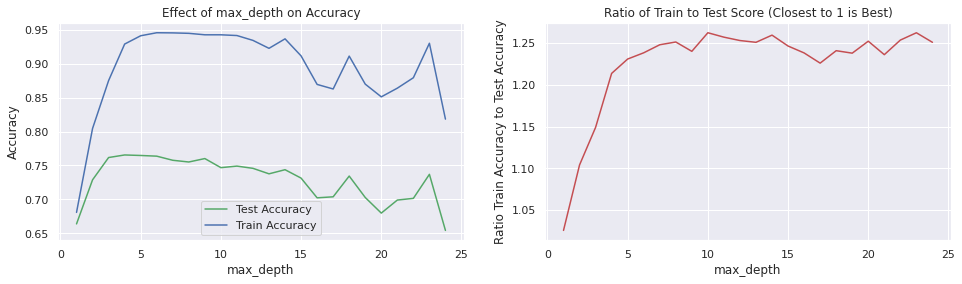

In [ ]:
ratio_depth = []

for i in range(len(test_accuracy_depth)):
  ratio_depth.append(train_accuracy_depth[i]/ test_accuracy_depth[i])

# Plot a graph to show the accuracy of the test data versus the accuracy of the training data. 
fig = plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.plot(max_depths,test_accuracy_depth,'-g',label='Test Accuracy')
ax1.plot(max_depths,train_accuracy_depth,'-b',label='Train Accuracy')
ax1.set(xlabel='max_depth',ylabel='Accuracy')
ax1.set_title('Effect of max_depth on Accuracy')
ax1.legend()
ax2.plot(max_depths,ratio_depth,'-r')
ax2.set(xlabel='max_depth',ylabel='Ratio Train Accuracy to Test Accuracy')
ax2.set_title('Ratio of Train to Test Score (Closest to 1 is Best)')
plt.show()

In [ ]:
fig.savefig('depth.png')
files.download('depth.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The best max_depth is the default, at 2. When max_depth is set to 2, our model still demonstrates reasonably high accuracy on the test data while not overfitting drastically with the training data. 

##### min_samples_split

In [ ]:
test_accuracy_split = []
train_accuracy_split = []
splits = [2,4,6,8,10,20,40,60,100]
for split in splits:
  params = {'loss': 'deviance', 'max_depth':3, 'n_estimators': 1750, 'subsample':.7,'learning_rate':0.1, 'min_samples_split':split}
  print('Min Samples Split = {}'.format(split))
  print('-'*40)
  train_split,test_split = run_boost_model(X,Y,params)
  print('-'*40)
  test_accuracy_split.append(test_split)
  train_accuracy_split.append(train_split)

Min Samples Split = 2
----------------------------------------
Train Accuracy: 0.8494903491650401
Test Accuracy: 0.7563875537566406
Original Accuracy 0.6777131292689097
GAIN
--------------------
Precision: 0.743680485338726
Original Precision 0.6506691278264882
GAIN
--------------------
Recall: 0.7633627400103788
Original Recall 0.7317073170731707
GAIN
----------------------------------------
Min Samples Split = 4
----------------------------------------
Train Accuracy: 0.8502494036000867
Test Accuracy: 0.7589172780166962
Original Accuracy 0.6777131292689097
GAIN
--------------------
Precision: 0.75
Original Precision 0.6506691278264882
GAIN
--------------------
Recall: 0.7581733264141152
Original Recall 0.7317073170731707
GAIN
----------------------------------------
Min Samples Split = 6
----------------------------------------
Train Accuracy: 0.8464541314248536
Test Accuracy: 0.7533518846445737
Original Accuracy 0.6777131292689097
GAIN
--------------------
Precision: 0.7416243654822

In [ ]:
test_accuracy_split = [0.7563875537566406,
 0.7589172780166962,
 0.7533518846445737,
 0.7566405261826461,
 0.7508221603845181,
 0.7482924361244624,
 0.7394384012142676,
 0.7288135593220338,
 0.7219833038198836]

In [ ]:
train_accuracy_split = [0.8494903491650401,
 0.8502494036000867,
 0.8464541314248536,
 0.8405985686402082,
 0.8338755150726523,
 0.8249837345478205,
 0.8045977011494253,
 0.792561266536543,
 0.7770548687920191]

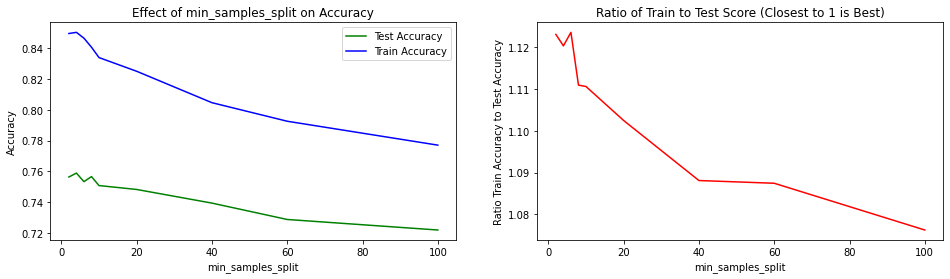

In [ ]:
ratio_split = []

for i in range(len(test_accuracy_split)):
  ratio_split.append(train_accuracy_split[i]/ test_accuracy_split[i])

# Plot a graph to show the accuracy of the test data versus the accuracy of the training data. 
fig = plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.plot(splits,test_accuracy_split,'-g',label='Test Accuracy')
ax1.plot(splits,train_accuracy_split,'-b',label='Train Accuracy')
ax1.set(xlabel='min_samples_split',ylabel='Accuracy')
ax1.set_title('Effect of min_samples_split on Accuracy')
ax1.legend()
ax2.plot(splits,ratio_split,'-r')
ax2.set(xlabel='min_samples_split',ylabel='Ratio Train Accuracy to Test Accuracy')
ax2.set_title('Ratio of Train to Test Score (Closest to 1 is Best)')
plt.show()

It appears that min_samples_split might be best at 40, which maximixes the test accuracy but minimizes the distance between the test and train accuracy

##### min_samples_leaf

In [ ]:
min_samples_leafs = [1,10,20,50,100,200,300]

test_accuracy_leaf = []
train_accuracy_leaf = []
for leaf in min_samples_leafs:
  params = {'loss': 'deviance', 'max_depth':2, 'n_estimators': 1750, 'subsample':.7,'learning_rate':0.1, 'min_samples_split':40,'min_samples_leaf': leaf}
  print('Min Samples Leaf = {}'.format(leaf))
  print('-'*40)
  train_leaf,test_leaf = run_boost_model(X,Y,params)
  print('-'*40)
  test_accuracy_leaf.append(test_leaf)
  train_accuracy_leaf.append(train_leaf)

Min Samples Leaf = 1
----------------------------------------
Train Accuracy: 0.7495120364346128
Test Accuracy: 0.7100935997976221
Original Accuracy 0.6777131292689097
GAIN
--------------------
Precision: 0.69418199900547
Original Precision 0.6506691278264882
GAIN
--------------------
Recall: 0.7244421380384016
Original Recall 0.7317073170731707
LOSS
----------------------------------------
Min Samples Leaf = 10
----------------------------------------
Train Accuracy: 0.740620255909781
Test Accuracy: 0.6939033645332658
Original Accuracy 0.6777131292689097
GAIN
--------------------
Precision: 0.6765140324963073
Original Precision 0.6506691278264882
GAIN
--------------------
Recall: 0.7130254281266217
Original Recall 0.7317073170731707
LOSS
----------------------------------------
Min Samples Leaf = 20
----------------------------------------
Train Accuracy: 0.7240294946866189
Test Accuracy: 0.6830255502150265
Original Accuracy 0.6777131292689097
GAIN
--------------------
Precision: 0.66

In [ ]:
train_accuracy_leaf

[0.7495120364346128,
 0.740620255909781,
 0.7240294946866189,
 0.7052700065061809,
 0.686944263717198,
 0.6644979397093906,
 0.6495337237041856]

In [ ]:
test_accuracy_leaf

[0.7100935997976221,
 0.6939033645332658,
 0.6830255502150265,
 0.6706299013407538,
 0.665317480394637,
 0.6455856311662029,
 0.6372375411080192]

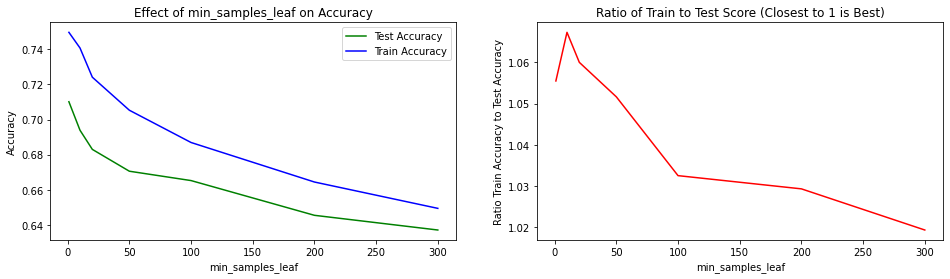

In [ ]:
ratio_leaf = []

for i in range(len(test_accuracy_leaf)):
  ratio_leaf.append(train_accuracy_leaf[i]/ test_accuracy_leaf[i])

# Plot a graph to show the accuracy of the test data versus the accuracy of the training data. 
fig = plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.plot(min_samples_leafs,test_accuracy_leaf,'-g',label='Test Accuracy')
ax1.plot(min_samples_leafs,train_accuracy_leaf,'-b',label='Train Accuracy')
ax1.set(xlabel='min_samples_leaf',ylabel='Accuracy')
ax1.set_title('Effect of min_samples_leaf on Accuracy')
ax1.legend()
ax2.plot(min_samples_leafs,ratio_leaf,'-r')
ax2.set(xlabel='min_samples_leaf',ylabel='Ratio Train Accuracy to Test Accuracy')
ax2.set_title('Ratio of Train to Test Score (Closest to 1 is Best)')
plt.show()

#### Best Gradient Boosting Model

In [ ]:
final_clf_params = {'loss': 'deviance',
               'max_depth': 2,
               'learning_rate':0.3,
               'n_estimators': 1500,
                }
clf_final = GradientBoostingClassifier(**final_clf_params)
clf_final.fit(X_train,y_train)
clf_final_trainscore = clf_final.score(X_train,y_train)
clf_final_testscore = clf_final.score(X_test,y_test)
cmtrain_clf_final,cmtest_clf_final = run_evaluate_model(clf_final,X,Y)

Scores on Training Data:
--------------------
Accuracy: 0.8313814790717848
Precision: 0.8240979381443299
Recall: 0.8390553247321233
----------------------------------------
Scores on Test Data:
--------------------
Accuracy: 0.752592967366557
Precision: 0.740253164556962
Recall: 0.7586922677737415
----------------------------------------


Confusion Matrix, without Normalization


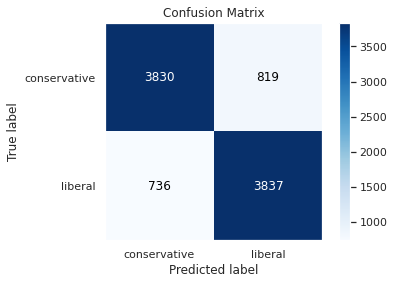

In [ ]:
plot_confusion_matrix(cmtrain_clf_final,['conservative','liberal'],False)

Confusion Matrix, without Normalization


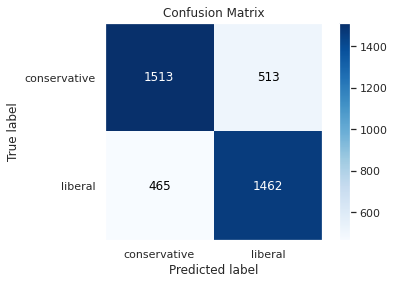

In [ ]:
plot_confusion_matrix(cmtest_clf_final,['conservative','liberal'],False)

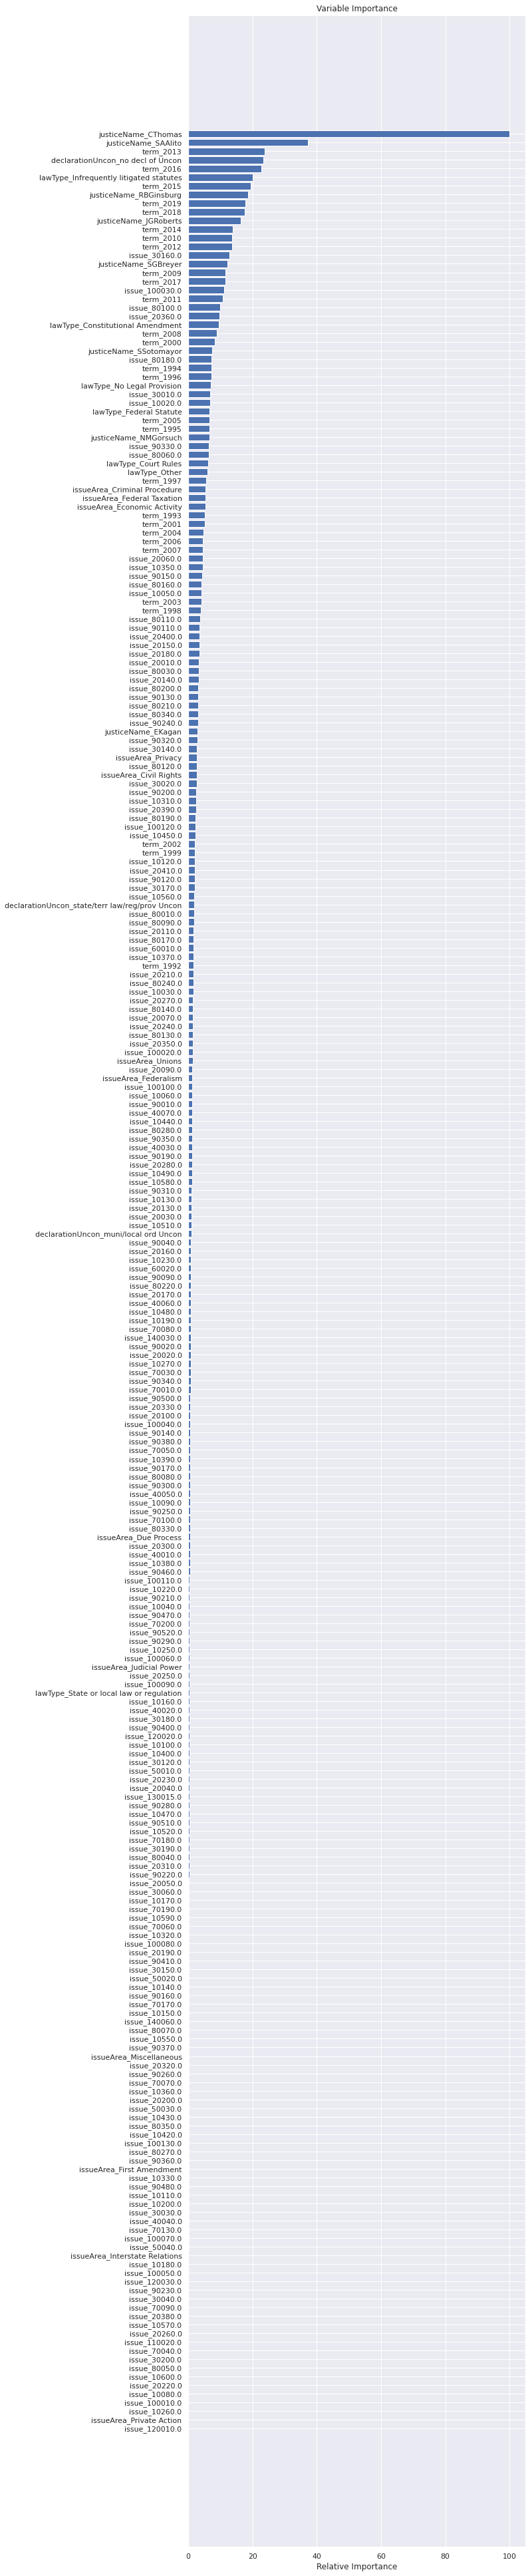

In [ ]:
feature_importance = clf_final.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
importance_plot = plt.figure(figsize=(20,70))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [ ]:
importance_plot.savefig('importance_plot.png')
files.download('importance_plot.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Model Comparisons and the Final Model

### Comparing Models

Let's plot the final train and test scores in a bar chart to make it clear which model we are choosing and why. 

In [ ]:
# Saving the training and testing scores to their own variables
lr_final_trainscore = 0.6813055736282801
lr_final_testscore = 0.6673412598026816
rf_final_trainscore = 0.8414660594231186
rf_final_testscore = 0.7057930685555275
knn_final_trainscore = 0.7690305790500976
knn_final_testscore = 0.7232481659499115
clf_final_trainscore = 0.8313814790717848
clf_final_testscore = 0.752592967366557

# Saving the scores to their own DataFrame
model_comparison_df = pd.DataFrame({
    'Logistic Regression':[lr_final_trainscore,lr_final_testscore],
    'Random Forest':[rf_final_trainscore,rf_final_testscore],
    'K-Nearest Neighbors': [knn_final_trainscore,knn_final_testscore],
    'Gradient Boosting': [clf_final_trainscore,clf_final_testscore]
    },index = ['Train Score','Test Score'])

model_comparison_df

Logistic Regression  ...  Gradient Boosting
Train Score             0.681306  ...           0.831381
Test Score              0.667341  ...           0.752593

[2 rows x 4 columns]

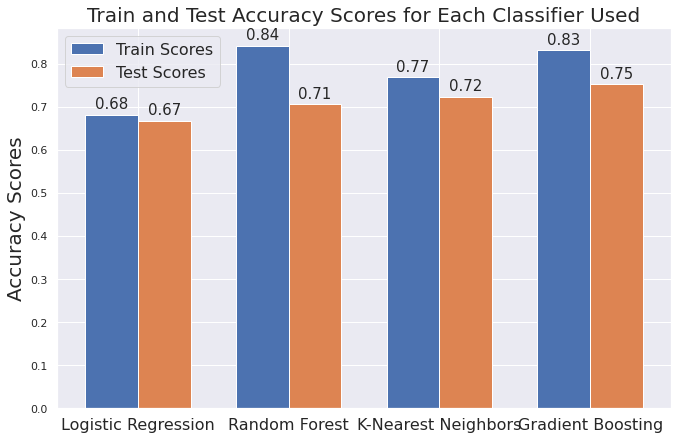

In [ ]:
# Plotting the Training and Testing Scores per Model to a Bar Chart for Visual Comparison

labels = model_comparison_df.columns.tolist()
train_scores = model_comparison_df.iloc[0,:].values.tolist()
test_scores = model_comparison_df.iloc[1,:].values.tolist()

x = np.arange(len(labels)) # Label Locations
width = 0.35 # Width of the bars


fig,ax = plt.subplots(figsize=(11,7))
rects1 = ax.bar(x - width/2, train_scores,width,label='Train Scores')
rects2 = ax.bar(x + width/2, test_scores,width,label='Test Scores')

# Add some Text for Labels, Title, and Custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy Scores',fontsize=20)
ax.set_title('Train and Test Accuracy Scores for Each Classifier Used',fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels(labels,fontsize=16)
ax.legend()

def autolabel(rects):
  for rect in rects:
    height = rect.get_height()
    ax.annotate('{}'.format(round(height,2)),
                xy=(rect.get_x() + rect.get_width() /2,height),
                xytext = (0,3), # 3 points vertical offset
                fontsize=15,
                textcoords = 'offset points',
                ha='center',va='bottom')

autolabel(rects1)
autolabel(rects2)
plt.legend(['Train Scores','Test Scores'],fontsize=16)

plt.show()

In [ ]:
fig.savefig('comparison.png')
files.download('comparison.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The Gradient Boosting Model clearly has the highest test accuracy, and although it is just barely not the highest training accuracy, this is a testament to less overfitting of the Gradient Boosting Model compared to the Random Forest Model. 

### Final Model

The final model that represents the test data reasonably well without drastically overfitting on the training data is a Gradient Boosting Model. 

The final score on the test data is ~75%.

This model can determine how the individual justices will vote given featurest that include the term year, the justices themselves, and certain issues.

This model is also very valuable because we are able to examine which features are the most important in determining how a justice might vote, which is interesting in this case because we can examine what the most contention issues are. 

### Feature Importance

As predicted, the certain justices with a higher record count are considered more important than other features. 

Additionally, as predicted, certain terms are considered more important, suggesting that there may be a trend in voting patterns over time with certain justices. 

Top 3 Feature Importances besides Justice and Term year are 
1. Whether or not there is a declaration of Unconstitutionality, which may be predicted
2. Interestingly, whether the statute that is being litigated has been argued infrequently. 
3. Decisions made considering a Constitutional Amendment as the deciding factor in the case. 

TOP 5 ISSUES:
1. Free Exercise of Religion
2. Federal Pre-Emption of State Legislation or Regulation
3. State or Local Government Tax
4. Indigents: US Supreme Court Docketing Fee
5. Patents and Copyright: Patents

# What Would RBG Do? (WWRBGD)

Ruth Bader Ginsburg has become an iconic of leftist politics and ideals. 

I think it would be fun to extrapolate on this model, and take only her cases, and build a model that can predict how she might have voted on future cases given her voting behaviors in the past. This is really, in all its glory, just fun for me. 

- Term
- Issue
- Issue Area
- Legal Provisions Considered by the Court
- Declaration of Unconstitutionality
- Decision Direction
- Direction of Individual Justices's Votes
- VOTE (TARGET)

In [ ]:
keep_list = ['term','issue','issueArea','decisionDirection','lawType','declarationUncon','justiceName','direction'] + ['vote']
original_df = original_df[keep_list]
original_df = original_df.dropna()
rbg_df = original_df.loc[original_df['justiceName'] == 'RBGinsburg',:]
rbg_df = rbg_df.drop('justiceName',axis=1)
rbg_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2729 entries, 8094 to 11054
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   term               2729 non-null   int64  
 1   issue              2729 non-null   float64
 2   issueArea          2729 non-null   float64
 3   decisionDirection  2729 non-null   float64
 4   lawType            2729 non-null   float64
 5   declarationUncon   2729 non-null   float64
 6   direction          2729 non-null   float64
 7   vote               2729 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 191.9 KB


In [ ]:
rbg_df['vote'].value_counts()

1.0    1839
2.0     613
3.0     167
4.0     109
5.0       1
Name: vote, dtype: int64

In [ ]:
rbg_df.drop(rbg_df[rbg_df['vote']==5.0].index,inplace=True)

In [ ]:
rbg_df['vote'].value_counts()

1.0    1839
2.0     613
3.0     167
4.0     109
Name: vote, dtype: int64

## Label Encoding

In [ ]:
# Label Encoding for Issue

rbg_df = pd.concat([rbg_df,pd.get_dummies(rbg_df['issue'],prefix='issue',drop_first=True)],axis=1)
issue_dummy_names = pd.get_dummies(rbg_df['issue'],prefix='issue',drop_first=True).columns.tolist()

# Label Encoding for Issue Area

issueAreas = ['Criminal Procedure','Civil Rights','First Amendment','Due Process','Privacy','Attorneys','Unions','Economic Activity','Judicial Power','Federalism','Interstate Relations','Federal Taxation','Miscellaneous','Private Action']

for i in range(len(issueAreas)):
  rbg_df.loc[rbg_df['issueArea'] == i+1,'issueArea'] = issueAreas[i]

# Label encoding for Decision Direction
rbg_df.loc[rbg_df.decisionDirection == 1.0,'decisionDirection'] = 'conservative'
rbg_df.loc[rbg_df.decisionDirection == 2.0,'decisionDirection'] = 'liberal'

# Label encoding for the Law considered in the decision
lawTypes = ['Constitution',
'Constitutional Amendment',
'Federal Statute',
'Court Rules',
'Other',
'Infrequently litigated statutes',
'State or local law or regulation',
'No Legal Provision']

rbg_df.loc[rbg_df['lawType'] == 1.0,'lawType'] = lawTypes[0]
rbg_df.loc[rbg_df['lawType'] == 2.0,'lawType'] = lawTypes[1]
rbg_df.loc[rbg_df['lawType'] == 3.0,'lawType'] = lawTypes[2]
rbg_df.loc[rbg_df['lawType'] == 4.0,'lawType'] = lawTypes[3]
rbg_df.loc[rbg_df['lawType'] == 5.0,'lawType'] = lawTypes[4]
rbg_df.loc[rbg_df['lawType'] == 6.0,'lawType'] = lawTypes[5]
rbg_df.loc[rbg_df['lawType'] == 8.0,'lawType'] = lawTypes[6]
rbg_df.loc[rbg_df['lawType'] == 9.0,'lawType'] = lawTypes[7]

declaresUncon = ['no decl of Uncon','congress act Uncon','state/terr law/reg/prov Uncon','muni/local ord Uncon']

# Label encoding for whether there was a declaration of Unconstitutionality
for i in range(len(declaresUncon)):
  rbg_df.loc[rbg_df['declarationUncon'] == i+1,'declarationUncon'] = declaresUncon[i]

# Label encoding the target variable, the judge's direction of decision
rbg_df.loc[rbg_df.direction == 1.0,'direction'] = 'conservative'
rbg_df.loc[rbg_df.direction == 2.0,'direction'] = 'liberal'

# Label Encoding for the Vote
rbg_df.loc[rbg_df['vote'] == 1,'vote'] = 'Voted_Majority_OR_Reg_Concurrence'
rbg_df.loc[rbg_df['vote'] == 3,'vote'] = 'Voted_Majority_OR_Reg_Concurrence'
rbg_df.loc[rbg_df['vote'] == 2,'vote'] = 'Dissent_OR_special_Concurrence'
rbg_df.loc[rbg_df['vote'] == 4,'vote'] = 'Dissent_OR_special_Concurrence'

In [ ]:
rbg_df

term     issue  ... issue_140030.0 issue_140060.0
8094   1993   20390.0  ...              0              0
8095   1993   20390.0  ...              0              0
8096   1993   20390.0  ...              0              0
8097   1993   20390.0  ...              0              0
8098   1993   20390.0  ...              0              0
...     ...       ...  ...            ...            ...
11050  2019  130015.0  ...              0              0
11051  2019   80120.0  ...              0              0
11052  2019   20010.0  ...              0              0
11053  2019  130015.0  ...              0              0
11054  2019  130015.0  ...              0              0

[2728 rows x 210 columns]

### One Hot Encoding

In [ ]:
rbg_df = pd.concat([rbg_df,pd.get_dummies(rbg_df['issueArea'],prefix='issueArea',drop_first=True)],axis=1)
issueArea_dummy_names = pd.get_dummies(rbg_df['issueArea'],prefix='issueArea',drop_first=True).columns.tolist()

dummy_variable_names = []
rbg_df = pd.concat([rbg_df,pd.get_dummies(rbg_df['lawType'],prefix='lawType',drop_first=True)],axis=1)
dummy_variable_names = dummy_variable_names + pd.get_dummies(rbg_df['lawType'],prefix='lawType',drop_first=True).columns.tolist()

rbg_df = pd.concat([rbg_df,pd.get_dummies(rbg_df['declarationUncon'],prefix='declarationUncon',drop_first=True)],axis=1)
dummy_variable_names = dummy_variable_names + pd.get_dummies(rbg_df['declarationUncon'],prefix='declarationUncon',drop_first=True).columns.tolist()

rbg_df = pd.concat([rbg_df,pd.get_dummies(rbg_df['term'],prefix='term',drop_first=True)],axis=1)
dummy_term_years = pd.get_dummies(rbg_df['term'],prefix='term',drop_first=True).columns.tolist()

In [ ]:
dummy_variable_names

['lawType_Constitutional Amendment',
 'lawType_Court Rules',
 'lawType_Federal Statute',
 'lawType_Infrequently litigated statutes',
 'lawType_No Legal Provision',
 'lawType_Other',
 'lawType_State or local law or regulation',
 'declarationUncon_muni/local ord Uncon',
 'declarationUncon_no decl of Uncon',
 'declarationUncon_state/terr law/reg/prov Uncon']

In [ ]:
rbg_df.shape

(2728, 259)

In [ ]:
rbg_df.shape[0] / rbg_df.shape[1]

10.532818532818533

## Models

In [ ]:
rbg_feature_list = rbg_df.drop(['vote','term','issue','issueArea','decisionDirection','lawType','declarationUncon','direction'],axis=1).columns.tolist()

X = rbg_df[rbg_feature_list]
Y = rbg_df['vote']
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

### Balance of Target Classes

In [ ]:
rbg_df['vote'].value_counts()

Voted_Majority_OR_Reg_Concurrence    2006
Dissent_OR_special_Concurrence        722
Name: vote, dtype: int64

The target classes here are quite unbalanced, so we'll have to look at the Confusion Matrix to see if this creates any bias in the predictions. 

### Logistic Regression

In [ ]:
params = {
    'C':2.0,
    'solver':'lbfgs',
    'random_state':42
}
lr=LogisticRegression(**params)
cmtrain,cmtest=run_evaluate_model(lr,X,Y)

Scores on Training Data:
--------------------
Accuracy: 0.7794656888423258
Precision: 0.7908378541289933
Recall: 0.9466089466089466
----------------------------------------
Scores on Test Data:
--------------------
Accuracy: 0.7448107448107448
Precision: 0.7818930041152263
Recall: 0.9193548387096774
----------------------------------------


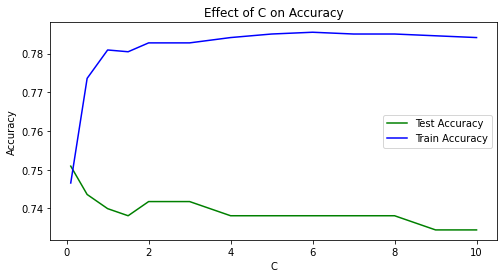

In [ ]:
# Use a loop to test the effect of varying the C parameter from 0.05 to 1.5 in increments of 0.05.
c_vals = [0.1,0.5,1.0,1.5,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0]
test_accuracy = []
train_accuracy = []

for c in c_vals:
  lr = LogisticRegression(solver='lbfgs',C=c,max_iter=1000,random_state=42)
  lr.fit(X_train,y_train)
  test_accuracy.append(lr.score(X_test,y_test))
  train_accuracy.append(lr.score(X_train,y_train))

# Plot a graph to show the accuracy of the test data versus the accuracy of the training data. Select an appropriate value for C and explain why that may be the best value.
fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(1,1,1)
ax1.plot(c_vals,test_accuracy,'-g',label='Test Accuracy')
ax1.plot(c_vals,train_accuracy,'-b',label='Train Accuracy')
ax1.set(xlabel='C',ylabel='Accuracy')
ax1.set_title('Effect of C on Accuracy')
ax1.legend()
plt.show()

In [ ]:
max(test_accuracy)

0.7509157509157509

In [ ]:
for i in range(len(test_accuracy)):
  if test_accuracy[i] == max(test_accuracy):
    print(i)

0


In [ ]:
c_vals[0]

0.1

In [ ]:
params = {
    'C':0.1,
    'solver':'lbfgs',
    'random_state':42
}
lr=LogisticRegression(**params)
cmtrain,cmtest=run_evaluate_model(lr,X,Y)

Scores on Training Data:
--------------------
Accuracy: 0.7380827658459926
Precision: 0.7399783315276273
Recall: 0.9855699855699855
----------------------------------------
Scores on Test Data:
--------------------
Accuracy: 0.7496947496947497
Precision: 0.7616645649432535
Recall: 0.9741935483870968
----------------------------------------


Confusion Matrix, without Normalization


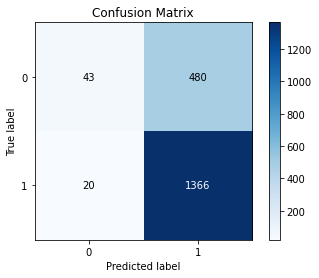

In [ ]:
plot_confusion_matrix(cmtrain,['dissent','majority'],False)

Confusion Matrix, without Normalization


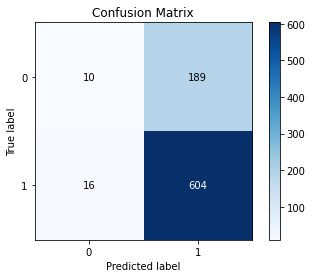

In [ ]:
plot_confusion_matrix(cmtest,[0,1],False)

In [ ]:
max_iters = [100,1000,10000,100000]
test_accuracy = []
train_accuracy = []
for iters in max_iters:
  params = {
    'C':0.1,
    'solver':'lbfgs',
    'max_iter':iters,
    'random_state':42
    }
  lr=LogisticRegression(**params)
  lr.fit(X_train,y_train)
  test_accuracy.append(lr.score(X_test,y_test))
  train_accuracy.append(lr.score(X_train,y_train))

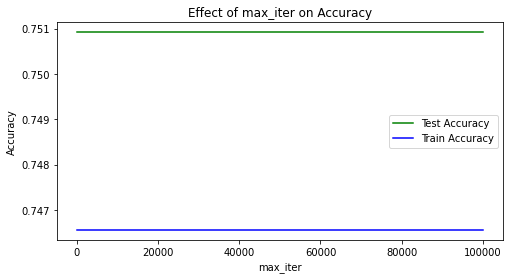

In [ ]:
# Plot a graph to show the accuracy of the test data versus the accuracy of the training data. Select an appropriate value for C and explain why that may be the best value.
fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(1,1,1)
ax1.plot(max_iters,test_accuracy,'-g',label='Test Accuracy')
ax1.plot(max_iters,train_accuracy,'-b',label='Train Accuracy')
ax1.set(xlabel='max_iter',ylabel='Accuracy')
ax1.set_title('Effect of max_iter on Accuracy')
ax1.legend()
plt.show()

### Random Forest Model

In [ ]:
rf = RandomForestClassifier()
cmtrain_rf,cmtest_rf = run_evaluate_model(rf,X,Y)

Scores on Training Data:
--------------------
Accuracy: 0.9554740701938188
Precision: 0.9590684544812985
Recall: 0.9805194805194806
----------------------------------------
Scores on Test Data:
--------------------
Accuracy: 0.7667887667887668
Precision: 0.833592534992224
Recall: 0.864516129032258
----------------------------------------


Confusion Matrix, without Normalization


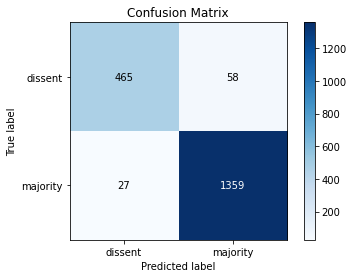

In [ ]:
plot_confusion_matrix(cmtrain_rf,['dissent','majority'],False)

Confusion Matrix, without Normalization


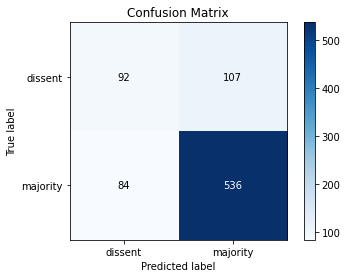

In [ ]:
plot_confusion_matrix(cmtest_rf,['dissent','majority'],False)

In [ ]:
rf.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)>

In [ ]:
params1={'bootstrap': True,
 'max_depth': 40,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 7,
 'n_estimators': 300}
rf = RandomForestClassifier(**params1)

cmtrain_rf,cmtest_rf = run_evaluate_model(rf,X,Y)

Scores on Training Data:
--------------------
Accuracy: 0.8638030382399162
Precision: 0.8475308641975309
Recall: 0.9906204906204906
----------------------------------------
Scores on Test Data:
--------------------
Accuracy: 0.7875457875457875
Precision: 0.8046448087431693
Recall: 0.95
----------------------------------------


Confusion Matrix, without Normalization


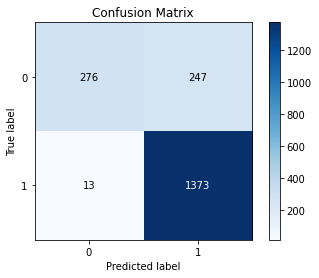

In [ ]:
plot_confusion_matrix(cmtrain_rf,[0,1],False)

Confusion Matrix, without Normalization


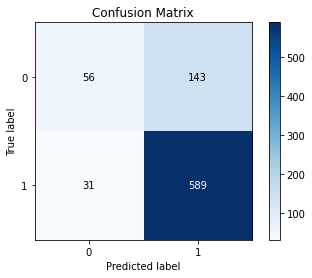

In [ ]:
plot_confusion_matrix(cmtest_rf,[0,1],False)

### K-Nearest Neighbors

In [ ]:
knn = KNeighborsClassifier(n_neighbors=10)
cmtrain_knn,cmtest_knn = run_evaluate_model(knn,X,Y)

Scores on Training Data:
--------------------
Accuracy: 0.7946568884232582
Precision: 0.8265440210249672
Recall: 0.9076479076479076
----------------------------------------
Scores on Test Data:
--------------------
Accuracy: 0.7045177045177046
Precision: 0.7872340425531915
Recall: 0.8354838709677419
----------------------------------------


Confusion Matrix, without Normalization


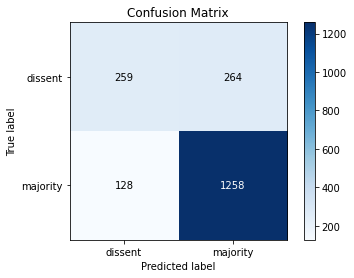

In [ ]:
plot_confusion_matrix(cmtrain_knn,['dissent','majority'],False)

Confusion Matrix, without Normalization


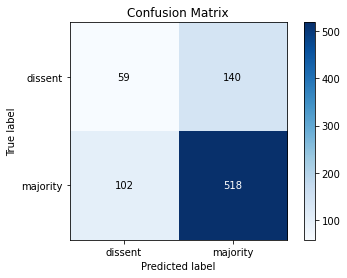

In [ ]:
plot_confusion_matrix(cmtest_knn,['dissent','majority'],False)

In [ ]:
neighbors_list = np.arange(3,20,1)
train_accuracy = []
test_accuracy = []

for n in neighbors_list:
  knn=KNeighborsClassifier(n_neighbors=n)
  knn.fit(X_train,y_train)
  train_pred = knn.predict(X_train)
  test_pred = knn.predict(X_test)
  train_score = accuracy_score(train_pred,y_train)
  train_accuracy.append(train_score)
  test_score = accuracy_score(test_pred,y_test)
  test_accuracy.append(test_score)

In [ ]:
train_accuracy = [0.8661778185151238,
 0.8304307974335472,
 0.8240146654445463,
 0.8024747937671861,
 0.7983501374885427,
 0.7965169569202566,
 0.7978918423464711,
 0.7901008249312558,
 0.7901008249312558,
 0.7896425297891843,
 0.7846012832263978,
 0.7823098075160403,
 0.7791017415215399,
 0.775435380384968,
 0.7717690192483959,
 0.7749770852428964,
 0.7722273143904674]

In [ ]:
test_accuracy = [0.7545787545787546,
 0.7161172161172161,
 0.7490842490842491,
 0.6978021978021978,
 0.7252747252747253,
 0.7051282051282052,
 0.7289377289377289,
 0.7142857142857143,
 0.7289377289377289,
 0.7271062271062271,
 0.7435897435897436,
 0.7417582417582418,
 0.7509157509157509,
 0.73992673992674,
 0.7417582417582418,
 0.7417582417582418,
 0.76007326007326]

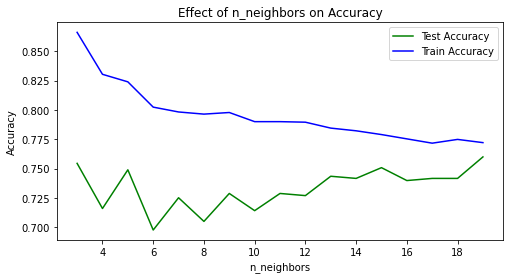

In [ ]:
# Plot a graph to show the accuracy of the test data versus the accuracy of the training data. Select an appropriate value for C and explain why that may be the best value.
fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(1,1,1)
ax1.plot(neighbors_list,test_accuracy,'-g',label='Test Accuracy')
ax1.plot(neighbors_list,train_accuracy,'-b',label='Train Accuracy')
ax1.set(xlabel='n_neighbors',ylabel='Accuracy')
ax1.set_title('Effect of n_neighbors on Accuracy')
ax1.legend()
plt.show()

In [ ]:
max(test_accuracy)

0.76007326007326

In [ ]:
for i in range(len(test_accuracy)):
  if test_accuracy[i] == max(test_accuracy):
    print(i)

16


In [ ]:
neighbors_list[16]

19

Neighbors is best at n_neighbors = 19

In [ ]:
knn = KNeighborsClassifier(n_neighbors=19)
cmtrain_knn,cmtest_knn = run_evaluate_model(knn,X,Y)

Scores on Training Data:
--------------------
Accuracy: 0.7716081718177056
Precision: 0.7764842840512224
Recall: 0.9624819624819625
----------------------------------------
Scores on Test Data:
--------------------
Accuracy: 0.7472527472527473
Precision: 0.7779273216689099
Recall: 0.932258064516129
----------------------------------------


Confusion Matrix, without Normalization


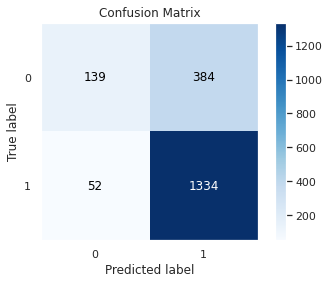

In [ ]:
plot_confusion_matrix(cmtrain_knn,[0,1],False)

Confusion Matrix, without Normalization


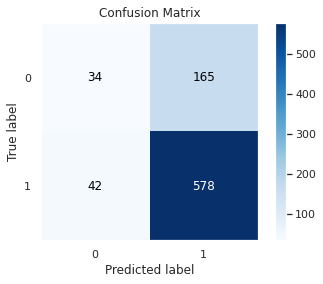

In [ ]:
plot_confusion_matrix(cmtest_knn,[0,1],False)

### Boosting Models

In [ ]:
params1 = {'n_estimators':500,
           'max_depth': 2,
           'loss':'deviance'}

# Initiate and fit the model
clf = GradientBoostingClassifier(**params1)
cmtrain_clf,cmtest_clf = run_evaluate_model(clf,X,Y)

Scores on Training Data:
--------------------
Accuracy: 0.8171817705605029
Precision: 0.8037492677211482
Recall: 0.98989898989899
----------------------------------------
Scores on Test Data:
--------------------
Accuracy: 0.7753357753357754
Precision: 0.7906666666666666
Recall: 0.9564516129032258
----------------------------------------


Confusion Matrix, without Normalization


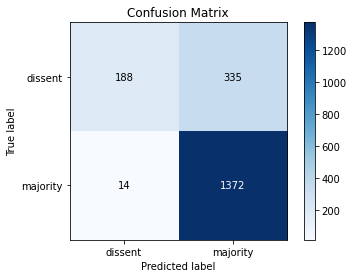

In [ ]:
plot_confusion_matrix(cmtrain_clf,['dissent','majority'],False)

Confusion Matrix, without Normalization


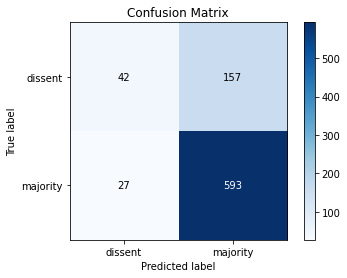

In [ ]:
plot_confusion_matrix(cmtest_clf,['dissent','majority'],False)

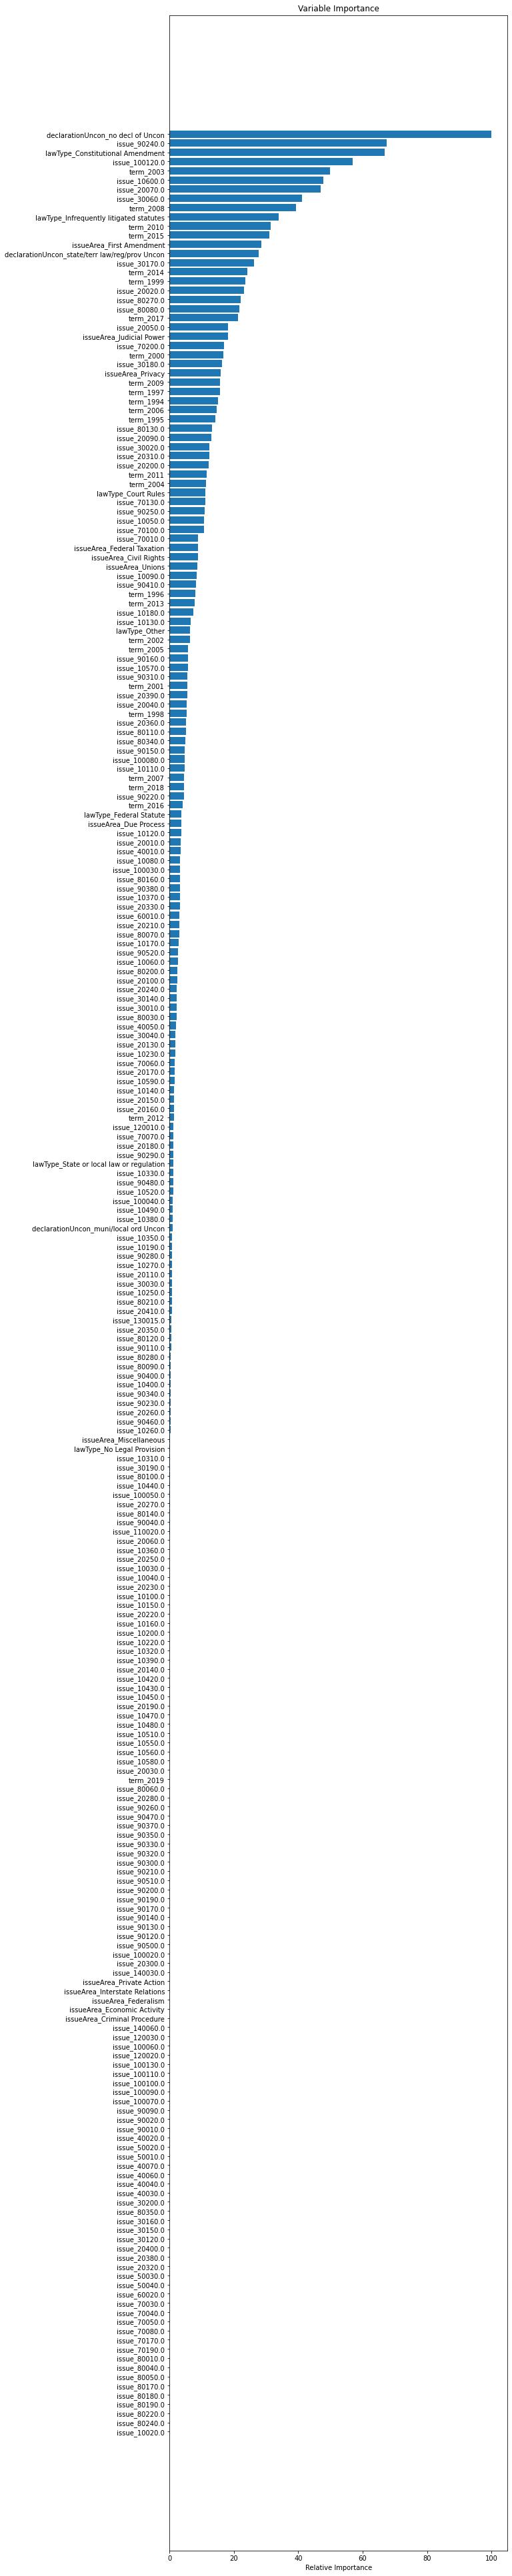

In [ ]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(20,70))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

#### Exploring n_estimators

In [ ]:
original_test_accuracy = 0.7692307692307693
precision_og = 0.7869507323568575
recall_og = 0.9532258064516129

In [ ]:
test_accuracy_n = []
train_accuracy_n = []
n_estimators_list = np.arange(100,2000,100)
for n_estimators in n_estimators_list:
  params = {'loss': 'deviance', 'max_depth': 2,'learning_rate':0.1, 'n_estimators': n_estimators}
  print('Estimator Number = {}'.format(n_estimators))
  print('-'*40)
  train_score_n,test_score_n = run_boost_model(X,Y,params)
  print('-'*40)
  test_accuracy_n.append(test_score_n)
  train_accuracy_n.append(train_score_n)

Estimator Number = 100
----------------------------------------
Train Accuracy: 0.78365636458879
Test Accuracy: 0.7741147741147741
Original Accuracy 0.7692307692307693
GAIN
--------------------
Precision: 0.7770700636942676
Original Precision 0.7869507323568575
LOSS
--------------------
Recall: 0.9838709677419355
Original Recall 0.9532258064516129
GAIN
----------------------------------------
Estimator Number = 200
----------------------------------------
Train Accuracy: 0.7946568884232582
Test Accuracy: 0.7704517704517705
Original Accuracy 0.7692307692307693
GAIN
--------------------
Precision: 0.7790697674418605
Original Precision 0.7869507323568575
LOSS
--------------------
Recall: 0.9725806451612903
Original Recall 0.9532258064516129
GAIN
----------------------------------------
Estimator Number = 300
----------------------------------------
Train Accuracy: 0.8072289156626506
Test Accuracy: 0.7741147741147741
Original Accuracy 0.7692307692307693
GAIN
--------------------
Precision:

In [ ]:
test_accuracy_n = [0.7741147741147741,
 0.7704517704517705,
 0.7741147741147741,
 0.7741147741147741,
 0.7704517704517705,
 0.7692307692307693,
 0.7692307692307693,
 0.7680097680097681,
 0.7728937728937729,
 0.7777777777777778,
 0.7716727716727717,
 0.7777777777777778,
 0.7753357753357754,
 0.7655677655677655,
 0.778998778998779,
 0.7704517704517705,
 0.7728937728937729,
 0.7704517704517705,
 0.7728937728937729]
train_accuracy_n = [0.78365636458879,
 0.7946568884232582,
 0.8072289156626506,
 0.8108957569408067,
 0.8182294394971189,
 0.8239916186485071,
 0.8318491356731272,
 0.8349921424829754,
 0.8313253012048193,
 0.8397066526977475,
 0.8486118386589837,
 0.8507071765322158,
 0.8543740178103719,
 0.8606600314300681,
 0.8638030382399162,
 0.8674698795180723,
 0.8695652173913043,
 0.8732320586694604,
 0.8758512310110005]

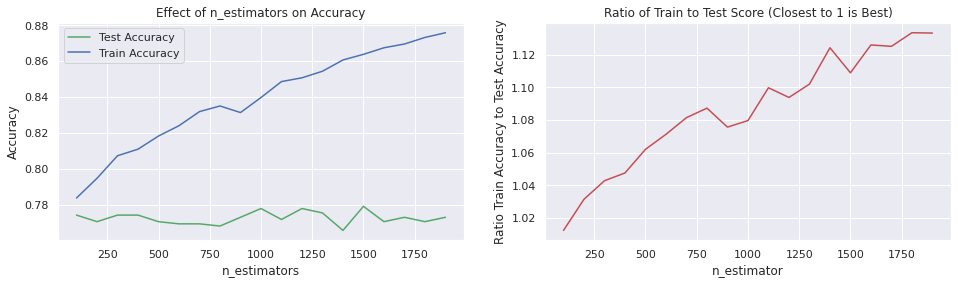

In [ ]:
ratio_n = []

for i in range(len(test_accuracy_n)):
  ratio_n.append(train_accuracy_n[i]/ test_accuracy_n[i])

# Plot a graph to show the accuracy of the test data versus the accuracy of the training data. 
fig = plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.plot(n_estimators_list,test_accuracy_n,'-g',label='Test Accuracy')
ax1.plot(n_estimators_list,train_accuracy_n,'-b',label='Train Accuracy')
ax1.set(xlabel='n_estimators',ylabel='Accuracy')
ax1.set_title('Effect of n_estimators on Accuracy')
ax1.legend()
ax2.plot(n_estimators_list,ratio_n,'-r')
ax2.set(xlabel='n_estimator',ylabel='Ratio Train Accuracy to Test Accuracy')
ax2.set_title('Ratio of Train to Test Score (Closest to 1 is Best)')
plt.show()

In [ ]:
for i in range(len(test_accuracy_n)):
  if test_accuracy_n[i] == max(test_accuracy_n):
    print(i)

14


In [ ]:
train_accuracy_n[14]

0.8638030382399162

As n_estimators goes up, it does not drastically affect the test accuracy,and instead contributes to overfitting. It looks like the best n_estimators mihgt be somewhere around 30, let's see. 

In [ ]:
n_estimators_list[2]

300

In [ ]:
test_accuracy_n[2]

0.7741147741147741

In [ ]:
train_accuracy_n[2]

0.8072289156626506

Yes, we'll stick with n=300

The test accuracy never increases drastically, 

#### Exploring max_depths

In [ ]:
train_scores_depth = []
test_scores_depth = []
depths = [2,3,4,5,6,7,8,9,10]
for depth in depths:
  params = {'learning_rate': 0.1,'n_estimators':300,'max_depth':depth}
  print('Max Depth = {}'.format(depth))
  print('-'*40)
  train_score_clf,test_score_clf = run_boost_model(X,Y,params)
  print('-'*40)
  train_scores_depth.append(train_score_clf)
  test_scores_depth.append(test_score_clf)

Max Depth = 2
----------------------------------------
Train Accuracy: 0.8067050811943426
Test Accuracy: 0.7741147741147741
Original Accuracy 0.7692307692307693
GAIN
--------------------
Precision: 0.7865612648221344
Original Precision 0.7869507323568575
LOSS
--------------------
Recall: 0.9629032258064516
Original Recall 0.9532258064516129
GAIN
----------------------------------------
Max Depth = 3
----------------------------------------
Train Accuracy: 0.8308014667365112
Test Accuracy: 0.7851037851037851
Original Accuracy 0.7692307692307693
GAIN
--------------------
Precision: 0.8008130081300813
Original Precision 0.7869507323568575
GAIN
--------------------
Recall: 0.9532258064516129
Original Recall 0.9532258064516129
LOSS
----------------------------------------
Max Depth = 4
----------------------------------------
Train Accuracy: 0.8601361969617601
Test Accuracy: 0.78998778998779
Original Accuracy 0.7692307692307693
GAIN
--------------------
Precision: 0.8146067415730337
Origina

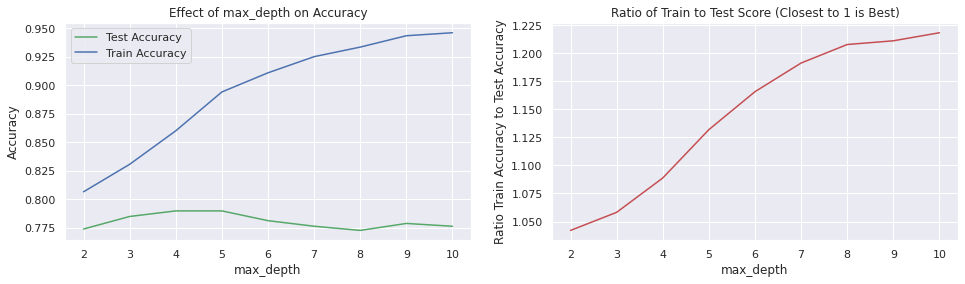

In [ ]:
ratio_depth = []

for i in range(len(test_scores_depth)):
  ratio_depth.append(train_scores_depth[i]/ test_scores_depth[i])

# Plot a graph to show the accuracy of the test data versus the accuracy of the training data. 
fig = plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.plot(depths,test_scores_depth,'-g',label='Test Accuracy')
ax1.plot(depths,train_scores_depth,'-b',label='Train Accuracy')
ax1.set(xlabel='max_depth',ylabel='Accuracy')
ax1.set_title('Effect of max_depth on Accuracy')
ax1.legend()
ax2.plot(depths,ratio_depth,'-r')
ax2.set(xlabel='max_depth',ylabel='Ratio Train Accuracy to Test Accuracy')
ax2.set_title('Ratio of Train to Test Score (Closest to 1 is Best)')
plt.show()

In [ ]:
for i in range(len(test_scores_depth)):
  if test_scores_depth[i] == max(test_scores_depth):
    print(i)

2
3


In [ ]:
test_scores_depth[2:4]

[0.78998778998779, 0.78998778998779]

In [ ]:
depths[2:4]

[4, 5]

In [ ]:
train_scores_depth[2:4]

[0.8601361969617601, 0.894185437401781]

A max depth of 4 increases the tst score but does not drastically overfit. However, the test score at the max_depth of 2 is comparable and overfitting is even less. We will stick with 2. 

In [ ]:
test_scores_depth[0]

0.7741147741147741

#### Exploring learning rates

In [ ]:
train_scores_learningrate = []
test_scores_learningrate = []
learning_rates = [0.1, 0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
for learning_rate in learning_rates:
  params = {'learning_rate': learning_rate,'n_estimators':300,'max_depth':2}
  print('Learning Rate = {}'.format(learning_rate))
  print('-'*40)
  train_score_lr,test_score_lr = run_boost_model(X,Y,params)
  print('-'*40)
  train_scores_learningrate.append(train_score_lr)
  test_scores_learningrate.append(test_score_lr)

Learning Rate = 0.1
----------------------------------------
Train Accuracy: 0.8051335777894185
Test Accuracy: 0.7741147741147741
Original Accuracy 0.7692307692307693
GAIN
--------------------
Precision: 0.7865612648221344
Original Precision 0.7869507323568575
LOSS
--------------------
Recall: 0.9629032258064516
Original Recall 0.9532258064516129
GAIN
----------------------------------------
Learning Rate = 0.2
----------------------------------------
Train Accuracy: 0.8266107909900472
Test Accuracy: 0.7667887667887668
Original Accuracy 0.7692307692307693
LOSS
--------------------
Precision: 0.7918367346938775
Original Precision 0.7869507323568575
GAIN
--------------------
Recall: 0.9387096774193548
Original Recall 0.9532258064516129
LOSS
----------------------------------------
Learning Rate = 0.3
----------------------------------------
Train Accuracy: 0.8522786799371399
Test Accuracy: 0.7643467643467643
Original Accuracy 0.7692307692307693
LOSS
--------------------
Precision: 0.7986

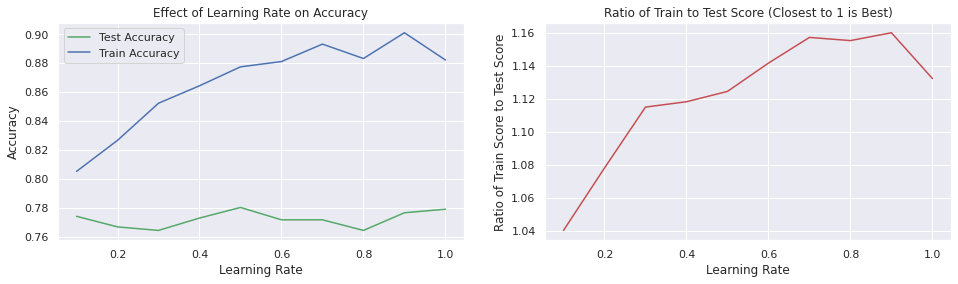

In [ ]:
ratio_learnrate = []

for i in range(len(test_scores_learningrate)):
  ratio_learnrate.append(train_scores_learningrate[i]/test_scores_learningrate[i])

# Plot a graph to show the accuracy of the test data versus the accuracy of the training data. 
fig = plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.plot(learning_rates,test_scores_learningrate,'-g',label='Test Accuracy')
ax1.plot(learning_rates,train_scores_learningrate,'-b',label='Train Accuracy')
ax1.set(xlabel='Learning Rate',ylabel='Accuracy')
ax1.set_title('Effect of Learning Rate on Accuracy')
ax1.legend()
ax2.plot(learning_rates,ratio_learnrate,'-r')
ax2.set(xlabel='Learning Rate',ylabel='Ratio of Train Score to Test Score')
ax2.set_title('Ratio of Train to Test Score (Closest to 1 is Best)')
plt.show()

Learning rate of 0.1 is definitely best. 

## Narrowing Features Based on Feature Importance

In [ ]:
sorted_idx_list = X.columns[sorted_idx].tolist()
sorted_idx_list.reverse()
rbg_feature_importance_list = sorted_idx_list

In [ ]:
rbg_top_50 = rbg_feature_importance_list[:50]
rbg_top_100 = rbg_feature_importance_list[:100]

In [ ]:
X = rbg_df[rbg_top_50]
Y = rbg_df['vote']
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.3,random_state=42)

### Logistic Regression

In [ ]:
params = {
    'C':2.0,
    'solver':'lbfgs',
    'random_state':42
}
lr=LogisticRegression(**params)
cmtrain,cmtest=run_evaluate_model(lr,X,Y)

Scores on Training Data:
--------------------
Accuracy: 0.7757988475641697
Precision: 0.7824292452830188
Recall: 0.9574314574314574
----------------------------------------
Scores on Test Data:
--------------------
Accuracy: 0.7496947496947497
Precision: 0.7777777777777778
Recall: 0.9370967741935484
----------------------------------------


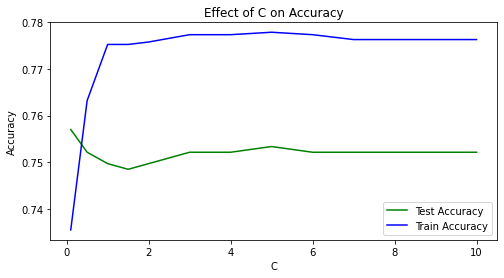

In [ ]:
# Use a loop to test the effect of varying the C parameter from 0.05 to 1.5 in increments of 0.05.
c_vals = [0.1,0.5,1.0,1.5,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0]
test_accuracy = []
train_accuracy = []

for c in c_vals:
  lr = LogisticRegression(solver='lbfgs',C=c,max_iter=1000,random_state=42)
  lr.fit(X_train,y_train)
  test_accuracy.append(lr.score(X_test,y_test))
  train_accuracy.append(lr.score(X_train,y_train))

# Plot a graph to show the accuracy of the test data versus the accuracy of the training data. Select an appropriate value for C and explain why that may be the best value.
fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(1,1,1)
ax1.plot(c_vals,test_accuracy,'-g',label='Test Accuracy')
ax1.plot(c_vals,train_accuracy,'-b',label='Train Accuracy')
ax1.set(xlabel='C',ylabel='Accuracy')
ax1.set_title('Effect of C on Accuracy')
ax1.legend()
plt.show()

In [ ]:
for i in range(len(test_accuracy)):
  if test_accuracy[i] == max(test_accuracy):
    print(i)

0


In [ ]:
params = {
    'C':0.1,
    'solver':'lbfgs',
    'random_state':42
}
lr=LogisticRegression(**params)
cmtrain,cmtest=run_evaluate_model(lr,X,Y)

Scores on Training Data:
--------------------
Accuracy: 0.7354635935044526
Precision: 0.7361930294906166
Recall: 0.9906204906204906
----------------------------------------
Scores on Test Data:
--------------------
Accuracy: 0.757020757020757
Precision: 0.7634543178973717
Recall: 0.9838709677419355
----------------------------------------


Confusion Matrix, without Normalization


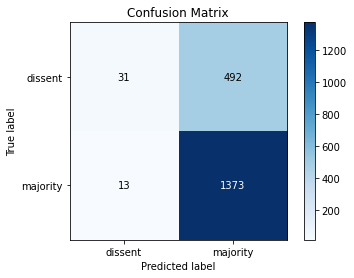

In [ ]:
plot_confusion_matrix(cmtrain,['dissent','majority'],False)

Confusion Matrix, without Normalization


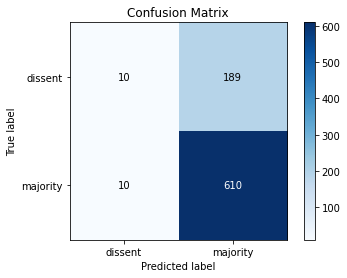

In [ ]:
plot_confusion_matrix(cmtest,['dissent','majority'],False)

### Random Forest

In [ ]:
rf = RandomForestClassifier()
cmtrain_rf,cmtest_rf = run_evaluate_model(rf,X,Y)

Scores on Training Data:
--------------------
Accuracy: 0.8412781561026715
Precision: 0.841640378548896
Recall: 0.9624819624819625
----------------------------------------
Scores on Test Data:
--------------------
Accuracy: 0.7631257631257631
Precision: 0.8016997167138811
Recall: 0.9129032258064517
----------------------------------------


Confusion Matrix, without Normalization


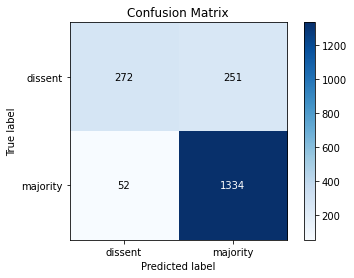

In [ ]:
plot_confusion_matrix(cmtrain_rf,['dissent','majority'],False)

Confusion Matrix, without Normalization


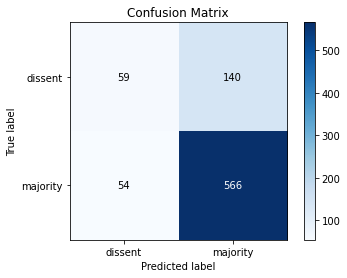

In [ ]:
plot_confusion_matrix(cmtest_rf,['dissent','majority'],False)

### K-Nearest Neighbors

In [ ]:
knn = KNeighborsClassifier(n_neighbors=10)
cmtrain_knn,cmtest_knn = run_evaluate_model(knn,X,Y)

Scores on Training Data:
--------------------
Accuracy: 0.785227867993714
Precision: 0.8197903014416776
Recall: 0.9025974025974026
----------------------------------------
Scores on Test Data:
--------------------
Accuracy: 0.7411477411477412
Precision: 0.8035714285714286
Recall: 0.8709677419354839
----------------------------------------


Confusion Matrix, without Normalization


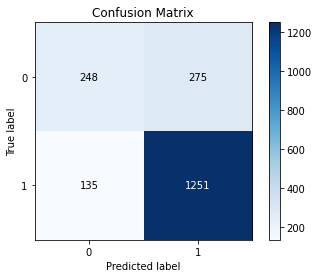

In [ ]:
plot_confusion_matrix(cmtrain_knn,[0,1],False)

Confusion Matrix, without Normalization


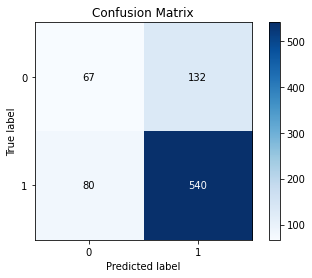

In [ ]:
plot_confusion_matrix(cmtest_knn,[0,1],False)

In [ ]:
neighbors_list = np.arange(3,20,1)
train_accuracy = []
test_accuracy = []

for n in neighbors_list:
  knn=KNeighborsClassifier(n_neighbors=n)
  knn.fit(X_train,y_train)
  train_pred = knn.predict(X_train)
  test_pred = knn.predict(X_test)
  train_score = accuracy_score(train_pred,y_train)
  train_accuracy.append(train_score)
  test_score = accuracy_score(test_pred,y_test)
  test_accuracy.append(test_score)

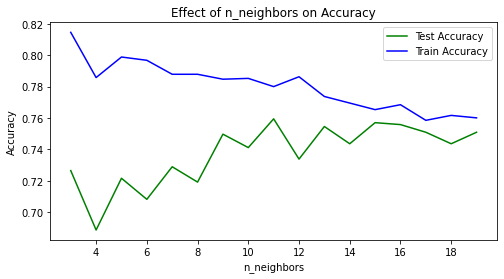

In [ ]:
# Plot a graph to show the accuracy of the test data versus the accuracy of the training data. Select an appropriate value for C and explain why that may be the best value.
fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(1,1,1)
ax1.plot(neighbors_list,test_accuracy,'-g',label='Test Accuracy')
ax1.plot(neighbors_list,train_accuracy,'-b',label='Train Accuracy')
ax1.set(xlabel='n_neighbors',ylabel='Accuracy')
ax1.set_title('Effect of n_neighbors on Accuracy')
ax1.legend()
plt.show()

In [ ]:
knn = KNeighborsClassifier(n_neighbors=19)
cmtrain_knn,cmtest_knn = run_evaluate_model(knn,X,Y)

Scores on Training Data:
--------------------
Accuracy: 0.7600838135149293
Precision: 0.7645381984036488
Recall: 0.9675324675324676
----------------------------------------
Scores on Test Data:
--------------------
Accuracy: 0.7509157509157509
Precision: 0.7715404699738904
Recall: 0.9532258064516129
----------------------------------------


Confusion Matrix, without Normalization


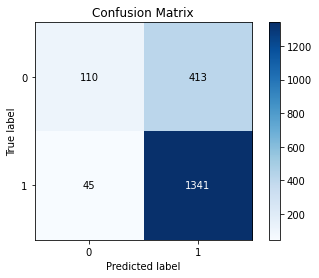

In [ ]:
plot_confusion_matrix(cmtrain_knn,[0,1],False)

Confusion Matrix, without Normalization


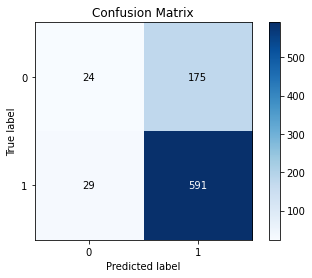

In [ ]:
plot_confusion_matrix(cmtest_knn,[0,1],False)

### Boosting Model

In [ ]:
params1 = {'n_estimators':500,
           'max_depth': 2,
           'loss':'deviance'}

# Initiate and fit the model
clf = GradientBoostingClassifier(**params1)
cmtrain_clf,cmtest_clf = run_evaluate_model(clf,X,Y)

Scores on Training Data:
--------------------
Accuracy: 0.8124672603457308
Precision: 0.7998833138856476
Recall: 0.9891774891774892
----------------------------------------
Scores on Test Data:
--------------------
Accuracy: 0.7692307692307693
Precision: 0.7869507323568575
Recall: 0.9532258064516129
----------------------------------------


Confusion Matrix, without Normalization


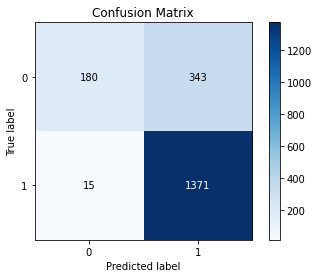

In [ ]:
plot_confusion_matrix(cmtrain_clf,[0,1],False)

Confusion Matrix, without Normalization


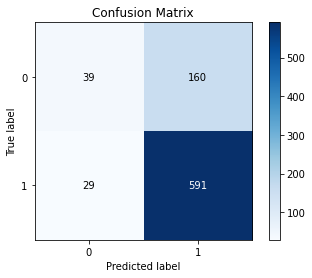

In [ ]:
plot_confusion_matrix(cmtest_clf,[0,1],False)

#### Exploring n_estimators

In [ ]:
original_test_accuracy = 0.7692307692307693
precision_og = 0.7869507323568575
recall_og = 0.9532258064516129

In [ ]:
test_accuracy_n = []
train_accuracy_n = []
n_estimators_list = np.arange(100,2000,100)
for n_estimators in n_estimators_list:
  params = {'loss': 'deviance', 'max_depth': 2,'learning_rate':0.1, 'n_estimators': n_estimators}
  print('Estimator Number = {}'.format(n_estimators))
  print('-'*40)
  train_score_n,test_score_n = run_boost_model(X,Y,params)
  print('-'*40)
  test_accuracy_n.append(test_score_n)
  train_accuracy_n.append(train_score_n)

Estimator Number = 100
----------------------------------------
Train Accuracy: 0.78365636458879
Test Accuracy: 0.7741147741147741
Original Accuracy 0.7692307692307693
GAIN
--------------------
Precision: 0.7770700636942676
Original Precision 0.7869507323568575
LOSS
--------------------
Recall: 0.9838709677419355
Original Recall 0.9532258064516129
GAIN
----------------------------------------
Estimator Number = 200
----------------------------------------
Train Accuracy: 0.7946568884232582
Test Accuracy: 0.7704517704517705
Original Accuracy 0.7692307692307693
GAIN
--------------------
Precision: 0.7790697674418605
Original Precision 0.7869507323568575
LOSS
--------------------
Recall: 0.9725806451612903
Original Recall 0.9532258064516129
GAIN
----------------------------------------
Estimator Number = 300
----------------------------------------
Train Accuracy: 0.8051335777894185
Test Accuracy: 0.7741147741147741
Original Accuracy 0.7692307692307693
GAIN
--------------------
Precision:

KeyboardInterrupt: ignored

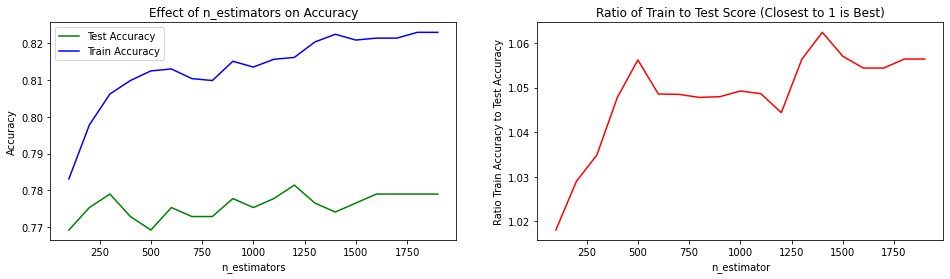

In [ ]:
ratio_n = []

for i in range(len(test_accuracy_n)):
  ratio_n.append(train_accuracy_n[i]/ test_accuracy_n[i])

# Plot a graph to show the accuracy of the test data versus the accuracy of the training data. 
fig = plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.plot(n_estimators_list,test_accuracy_n,'-g',label='Test Accuracy')
ax1.plot(n_estimators_list,train_accuracy_n,'-b',label='Train Accuracy')
ax1.set(xlabel='n_estimators',ylabel='Accuracy')
ax1.set_title('Effect of n_estimators on Accuracy')
ax1.legend()
ax2.plot(n_estimators_list,ratio_n,'-r')
ax2.set(xlabel='n_estimator',ylabel='Ratio Train Accuracy to Test Accuracy')
ax2.set_title('Ratio of Train to Test Score (Closest to 1 is Best)')
plt.show()

n_estimators is best at 300

#### Exploring Learning Rates

In [ ]:
train_scores_learningrate = []
test_scores_learningrate = []
learning_rates = [0.1, 0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
for learning_rate in learning_rates:
  params = {'learning_rate': learning_rate,'n_estimators':300}
  print('Learning Rate = {}'.format(learning_rate))
  print('-'*40)
  train_score_lr,test_score_lr = run_boost_model(X,Y,params)
  print('-'*40)
  train_scores_learningrate.append(train_score_lr)
  test_scores_learningrate.append(test_score_lr)

Learning Rate = 0.1
----------------------------------------
Train Accuracy: 0.8161341016238869
Test Accuracy: 0.7753357753357754
Original Accuracy 0.6777131292689097
GAIN
--------------------
Precision: 0.7898936170212766
Original Precision 0.6506691278264882
GAIN
--------------------
Recall: 0.9580645161290322
Original Recall 0.7317073170731707
GAIN
----------------------------------------
Learning Rate = 0.2
----------------------------------------
Train Accuracy: 0.8266107909900472
Test Accuracy: 0.7741147741147741
Original Accuracy 0.6777131292689097
GAIN
--------------------
Precision: 0.7967257844474761
Original Precision 0.6506691278264882
GAIN
--------------------
Recall: 0.9419354838709677
Original Recall 0.7317073170731707
GAIN
----------------------------------------
Learning Rate = 0.3
----------------------------------------
Train Accuracy: 0.8328968046097434
Test Accuracy: 0.7814407814407814
Original Accuracy 0.6777131292689097
GAIN
--------------------
Precision: 0.8058

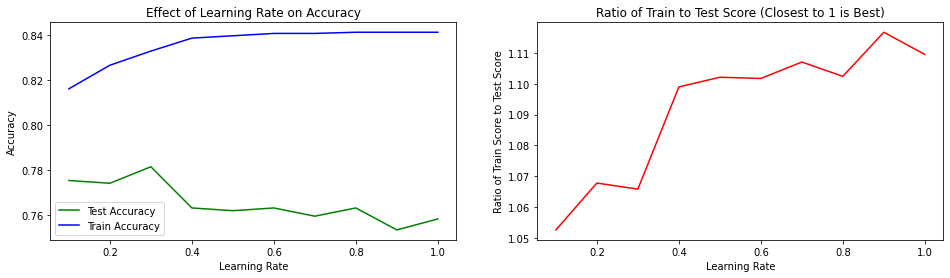

In [ ]:
ratio_learnrate = []

for i in range(len(test_scores_learningrate)):
  ratio_learnrate.append(train_scores_learningrate[i]/test_scores_learningrate[i])

# Plot a graph to show the accuracy of the test data versus the accuracy of the training data. 
fig = plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.plot(learning_rates,test_scores_learningrate,'-g',label='Test Accuracy')
ax1.plot(learning_rates,train_scores_learningrate,'-b',label='Train Accuracy')
ax1.set(xlabel='Learning Rate',ylabel='Accuracy')
ax1.set_title('Effect of Learning Rate on Accuracy')
ax1.legend()
ax2.plot(learning_rates,ratio_learnrate,'-r')
ax2.set(xlabel='Learning Rate',ylabel='Ratio of Train Score to Test Score')
ax2.set_title('Ratio of Train to Test Score (Closest to 1 is Best)')
plt.show()

#### Best Boosting Model

In [ ]:
rbg_params = {'loss':'deviance','max_depth':2,'n_estimators':300,'learning_rate':0.3}
clf_rbg = GradientBoostingClassifier(**rbg_params)
cmtrain_rbg,cmtest_rbg = run_evaluate_model(clf_rbg,X,Y)

Scores on Training Data:
--------------------
Accuracy: 0.8161341016238869
Precision: 0.8074866310160428
Recall: 0.9805194805194806
----------------------------------------
Scores on Test Data:
--------------------
Accuracy: 0.7741147741147741
Precision: 0.7959183673469388
Recall: 0.9435483870967742
----------------------------------------


Confusion Matrix, without Normalization


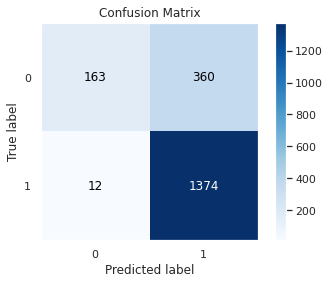

In [ ]:
plot_confusion_matrix(cmtrain_rbg,[0,1],False)

Confusion Matrix, without Normalization


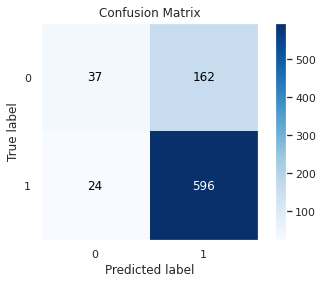

In [ ]:
plot_confusion_matrix(cmtest_rbg,[0,1],False)

## Model Comparisons and the Final Model

### Comparing Models

In [ ]:
# Saving the training and testing scores to their own variables
lr_final_trainscore_all = 0.7380827658459926
lr_final_testscore_all = 0.7496947496947497
rf_final_trainscore_all = 0.8638030382399162
rf_final_testscore_all = 0.7875457875457875
knn_final_trainscore_all = 0.7716081718177056
knn_final_testscore_all = 0.7472527472527473
clf_final_trainscore_all = 0.8171817705605029
clf_final_testscore_all = 0.7753357753357754

lr_final_trainscore_50 = 0.7753357753357754
lr_final_testscore_50 = 0.757020757020757
rf_final_trainscore_50 = 0.8412781561026715
rf_final_testscore_50 = 0.7631257631257631
knn_final_trainscore_50 = 0.7600838135149293
knn_final_testscore_50 = 0.7509157509157509
clf_final_trainscore_50 = 0.8051335777894185
clf_final_testscore_50 = 0.7728937728937729

# Saving the scores to their own DataFrame for All Features
rbg_model_comparison_df_all = pd.DataFrame({
    'Logistic Regression':[lr_final_trainscore_all,lr_final_testscore_all],
    'Random Forest':[rf_final_trainscore_all,rf_final_testscore_all],
    'K-Nearest Neighbors': [knn_final_trainscore_all,knn_final_testscore_all],
    'Gradient Boosting': [clf_final_trainscore_all,clf_final_testscore_all]
    },index = ['Train Score','Test Score'])

# Saving the scores to their own DataFrame for Top 50 Features
rbg_model_comparison_df_50 = pd.DataFrame({
    'Logistic Regression':[lr_final_trainscore_50,lr_final_testscore_50],
    'Random Forest':[rf_final_trainscore_50,rf_final_testscore_50],
    'K-Nearest Neighbors': [knn_final_trainscore_50,knn_final_testscore_50],
    'Gradient Boosting': [clf_final_trainscore_50,clf_final_testscore_50]
    },index = ['Train Score','Test Score'])

In [ ]:
rbg_model_comparison_df_all

Logistic Regression  ...  Gradient Boosting
Train Score             0.738083  ...           0.817182
Test Score              0.749695  ...           0.775336

[2 rows x 4 columns]

In [ ]:
rbg_model_comparison_df_50

Logistic Regression  ...  Gradient Boosting
Train Score             0.775336  ...           0.805134
Test Score              0.757021  ...           0.772894

[2 rows x 4 columns]

#### Comparing Test Scores for Using All Features vs. Top 50 Features

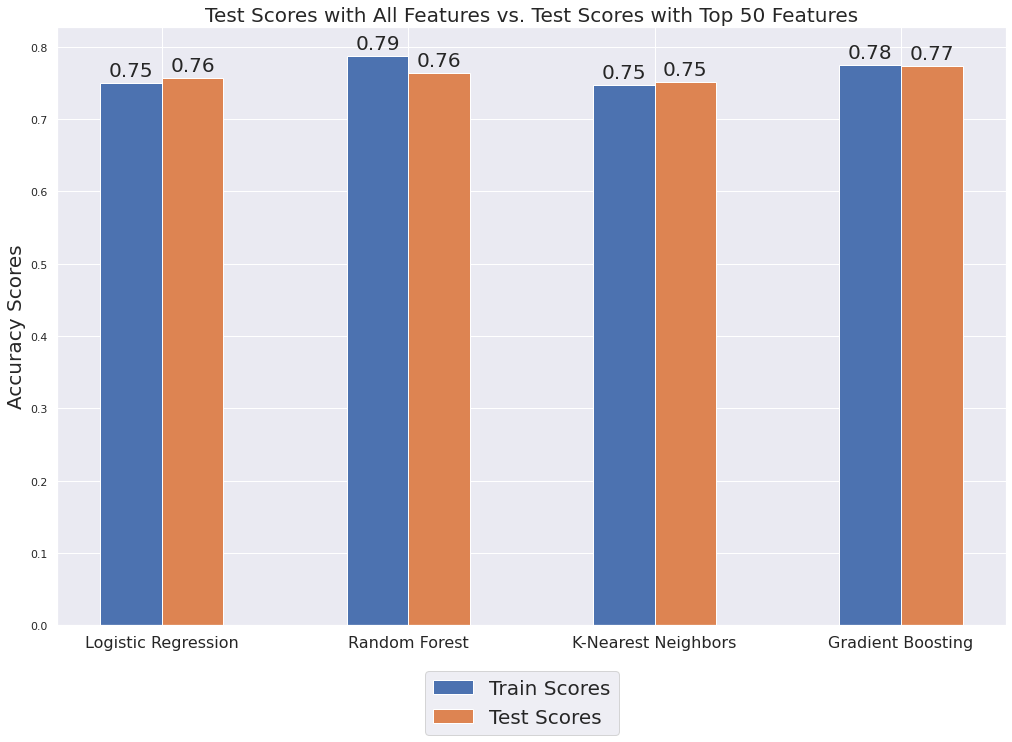

In [ ]:
# Plotting the Testing Scores per Feature Set to a Bar Chart for Visual Comparison

labels = rbg_model_comparison_df_all.columns.tolist()
test_scores_all = rbg_model_comparison_df_all.iloc[1,:].values.tolist()
test_scores_50 = rbg_model_comparison_df_50.iloc[1,:].values.tolist()

x = np.arange(len(labels)) # Label Locations
width = 0.25 # Width of the bars


fig,ax = plt.subplots(figsize=(17,11))
rects1 = ax.bar(x - width/2, test_scores_all,width,label='Test Scores with All Features')
rects2 = ax.bar(x + width/2, test_scores_50,width,label='Test Scores with Top 50 Features')

# Add some Text for Labels, Title, and Custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy Scores',fontsize=20)
ax.set_title('Test Scores with All Features vs. Test Scores with Top 50 Features',fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels(labels,fontsize=16)
ax.legend()

def autolabel(rects):
  for rect in rects:
    height = rect.get_height()
    ax.annotate('{}'.format(round(height,2)),
                xy=(rect.get_x() + rect.get_width() /2,height),
                xytext = (0,3), # 3 points vertical offset
                fontsize=20,
                textcoords = 'offset points',
                ha='center',va='bottom')

autolabel(rects1)
autolabel(rects2)
plt.legend(['Train Scores','Test Scores'], loc="lower center", bbox_to_anchor=(0.49, -0.2),fontsize=20)

plt.show()

It appears that reducing the feature set only improved the Logistic Regression model. This being considered, we will analyze which model to use based on the training and testing scores from the models using all features as opposed to the Top 50.

#### Comparing Train and Test Scores Between Models Using All Features

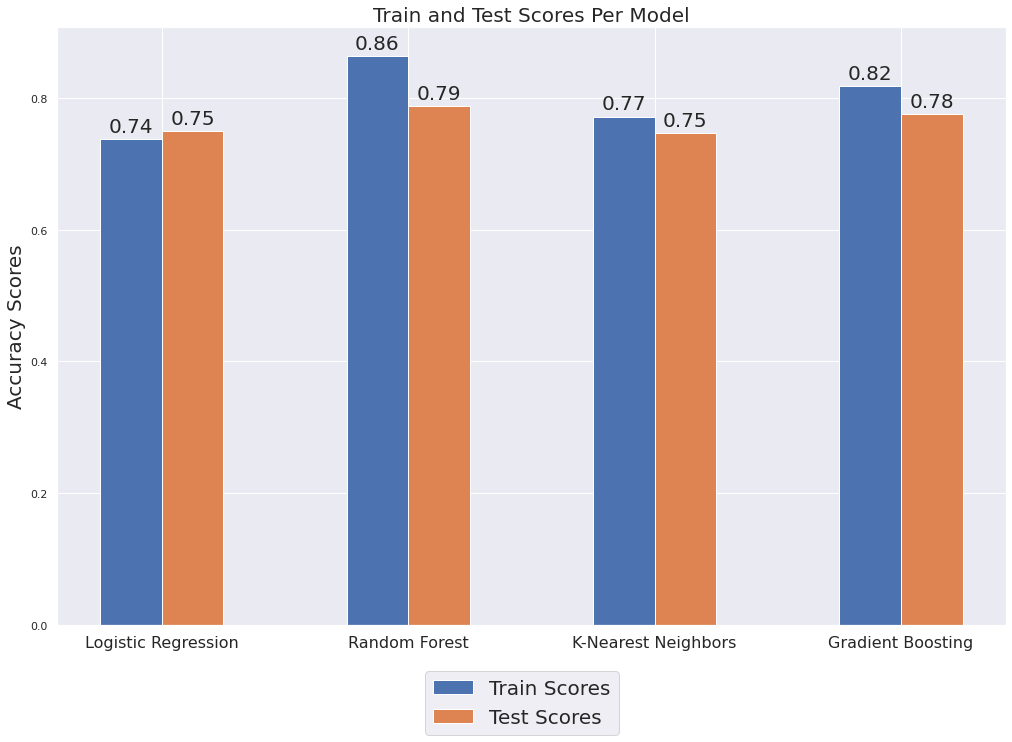

In [ ]:
# Plotting the Testing Scores per Feature Set to a Bar Chart for Visual Comparison

labels = rbg_model_comparison_df_all.columns.tolist()
train_scores_all = rbg_model_comparison_df_all.iloc[0,:].values.tolist()
test_scores_all = rbg_model_comparison_df_all.iloc[1,:].values.tolist()

x = np.arange(len(labels)) # Label Locations
width = 0.25 # Width of the bars


fig,ax = plt.subplots(figsize=(17,11))
rects1 = ax.bar(x - width/2, train_scores_all,width,label='Train Scores')
rects2 = ax.bar(x + width/2, test_scores_all,width,label='Test Scores')

# Add some Text for Labels, Title, and Custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy Scores',fontsize=20)
ax.set_title('Train and Test Scores Per Model',fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels(labels,fontsize=16)
ax.legend()

def autolabel(rects):
  for rect in rects:
    height = rect.get_height()
    ax.annotate('{}'.format(round(height,2)),
                xy=(rect.get_x() + rect.get_width() /2,height),
                xytext = (0,3), # 3 points vertical offset
                textcoords = 'offset points',
                fontsize=20,
                ha='center',va='bottom')

autolabel(rects1)
autolabel(rects2)
plt.legend(['Train Scores','Test Scores'], loc="lower center", bbox_to_anchor=(0.49, -0.2),fontsize=20)

plt.show()

Although the testing score is better for the Random Forest Model, there is significant overfitting occuring. The Gradient Boosting Model demonstrates less underfitting and a comparable test score, and therefore that is the final model. 

### Final Model for 'WWRBGD'



The final model is a Gradient Boosting Classifier that uses ALL FEATURES.

In [ ]:
X = rbg_df[rbg_feature_list]
Y = rbg_df['vote']
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

final_rbg_params = {'n_estimators':300,
           'max_depth': 2,
           'learning_rate':.1,
           'loss':'deviance'}

# Initiate and fit the model
rbg_clf_final = GradientBoostingClassifier(**final_rbg_params)
cmtrain_clf_rbg,cmtest_clf_rbg = run_evaluate_model(rbg_clf_final,X,Y)

Scores on Training Data:
--------------------
Accuracy: 0.8072289156626506
Precision: 0.7942196531791907
Recall: 0.9913419913419913
----------------------------------------
Scores on Test Data:
--------------------
Accuracy: 0.7741147741147741
Precision: 0.7865612648221344
Recall: 0.9629032258064516
----------------------------------------


Confusion Matrix, without Normalization


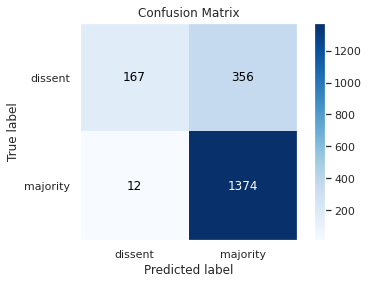

In [ ]:
plot_confusion_matrix(cmtrain_clf_rbg,['dissent','majority'],False)

Confusion Matrix, without Normalization


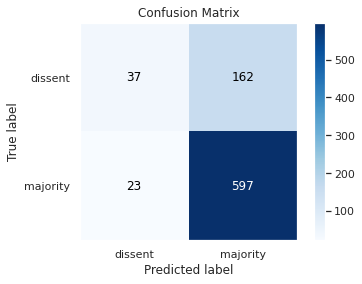

In [ ]:
plot_confusion_matrix(cmtest_clf_rbg,['dissent','majority'],False)

### Feature Importance

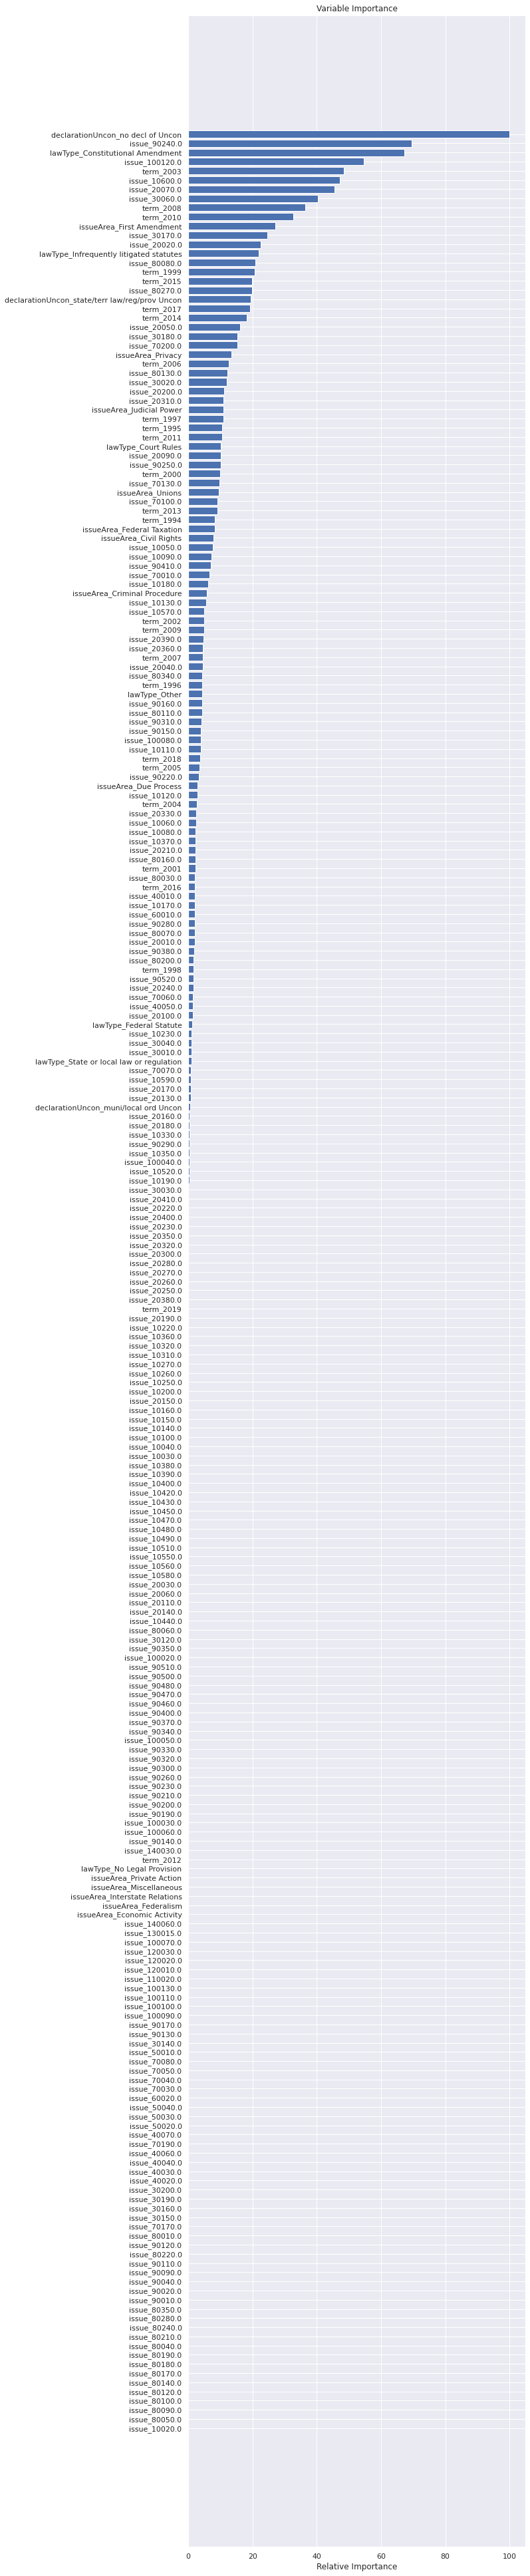

In [ ]:
feature_importance = rbg_clf_final.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(20,70))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

### What Matters for RBG

TOP DECIDING FEATURE:

- Whether or not there is a declaration of Unconstitutionality.

TOP LAW TYPES IN CONSIDERATION
1. Constitutional Amendments
2. Infrequently Litigated Statutes
3. Court Rules

TOP ISSUE AREAS
1. First Amendment
2. Judicial Power
3. Privacy
4. Unions
5. Federal Taxation
6. Civil Rights

TOP ISSUES:
1. Standing to Sue: Personal Injury
2. National Supremacy: Miscellaneous
3. Miscellaneous Criminal Procedure
4. Affirmative Action
5. Federal or State Internal Security Legislation
6. Establishment of Religion
7. Voting Rights Act of 1965, plus amendments
8. Federal and Some Few State Regulation of Public Utilities Regulation: Electric Power
9. Liability, Punitive Damages
10. Desegregation, Schools
